# spaCy/HDBScan Feature Extraction Pipeline

### Note: it can be quite complicated to install spaCy and sense2vec, given conflicting low-level requirements, so at this point I wouldn't suggest that others try to install the libraries and run this notebook.
  
However, it is well worth scanning down to the cell titled ***Harvesting Word Features***. In the output of that cell, there are examples of 52 feature clusters harvested by this process. The ultimate output of this process will produce a dataset containing a product ID (asin), overall rating, and word feature, for each word feature found in each product review. I don't consider these feature clusters as the final product, and we should discuss.


### We can use this output for several purposes. 

1. First, we should be able to quite easily make the data available to th web interface, so that we can display the top n word features (by overall rating) associated with products returned.

2. We will want to also include the user's selected word features in our model evaluation, to enable them to "drill into" selected features and thus explore the product/feature landscape.

3. Finally, I think it would be worth training a model on a vectorized representation of the top n most highly rated features, which may give us another dimension for predicting rating based on feature combination/interaction.

In [1]:
import pandas as pd
import gzip
import random
import time
# Install a few python packages using pip

#import enchant
import html
#!conda install pytables


# PyTables will be used to create huge matrices stored on disk, via HDF
import tables
from tables import *

from common import utils
utils.require_package("wget")      # for fetching dataset

In [2]:
# Standard python helper libraries.
from __future__ import print_function
from __future__ import division
import os, sys, time
import collections
from collections import Counter
import itertools

# Numerical manipulation libraries.
import numpy as np

import pickle 

#Visualization
import matplotlib
%matplotlib inline

import spacy
#activated = spacy.prefer_gpu()

import hdbscan
import seaborn as sns
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
from spacy.tokens import Doc
import tqdm
utils.require_package("wget") 
import nltk
from nltk.corpus import stopwords

In [3]:
#%lsmagic

plotting = True
labels_words = False

language_model = 'en_core_web_md'

start = time.time()
print("Reading spaCy language model {}...".format(language_model))
nlp = spacy.load(language_model, entity=False)
print("...finished reading English language model '{}' in {} seconds.".format(language_model, time.time()-start))

from nltk.corpus import stopwords
 
stopWords = set(stopwords.words('english'))
for stop_word in stopWords:
    nlp.vocab[stop_word].is_stop = True

Reading spaCy language model en_core_web_md...
...finished reading English language model 'en_core_web_md' in 12.770122051239014 seconds.


In [43]:
debug = False

# Paths for output files
path_for_tf_metadata = './logdir/embedding_test'
path_for_tf_ckpt = path_for_tf_metadata+'/embedding_test.ckpt'
vectors_filepath = './data/vectors_each.pytab'
metadata_filepath = './data/metadata_each.tsv'

In [5]:
def display_local_time():
    localTime = time.localtime()
    print("Local time = {}:{}".format(localTime.tm_hour, format(localTime.tm_min,'02')))    


In [6]:
def parse(path):
  print('start parse')
  start_parse = time.time()
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
  end_parse = time.time()
  print('end parse with time for parse',end_parse - start_parse)

def getDF(path):
  print('start getDF')
  start = time.time()
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  print('end getDF')
  end = time.time()
  print('time taken to load data = ',end-start)
  return pd.DataFrame.from_dict(df, orient='index')

start = time.time()
print("Reading Pandas dataframe from reviews_Toys_and_Games_5.json.gz...")
df = getDF('./data/reviews_Toys_and_Games_5.json.gz')
print("...read reviews_Toys_and_Games_5.json.gz in {} seconds.".format(time.time()-start))

Reading Pandas dataframe from reviews_Toys_and_Games_5.json.gz...
start getDF
start parse
end parse with time for parse 7.545560121536255
end getDF
time taken to load data =  7.546141147613525
...read reviews_Toys_and_Games_5.json.gz in 9.873693943023682 seconds.


In [ ]:
# meta_Toys_and_Games.json.gz
print("Loading related metadata dataset:")
print()
# file = 'metadata.json.gz'
file = './data/meta_Toys_and_Games.json.gz'
start = time.time()
md = getDF(file)
print('Total time taken for loading the metadata dataset: {} minutes.'.format(np.round((time.time() - start)/60),2))
print()
print(md.columns)
print()
print("Number of records in metadata dataset: {}".format(len(md)))
print()
print(md.head(1))

In [7]:
print(df.shape)
print(df.columns)
df.head(2)

(167597, 9)
Index(['overall', 'reviewerID', 'reviewText', 'unixReviewTime', 'reviewTime',
       'reviewerName', 'helpful', 'summary', 'asin'],
      dtype='object')


overall      reviewerID                                         reviewText  \
0      5.0  A1VXOAVRGKGEAK  I like the item pricing. My granddaughter want...   
1      4.0   A8R62G708TSCM  Love the magnet easel... great for moving to d...   

   unixReviewTime   reviewTime reviewerName helpful  \
0      1390953600  01 29, 2014        Angie  [0, 0]   
1      1395964800  03 28, 2014      Candace  [1, 1]   

                                             summary        asin  
0                                     Magnetic board  0439893577  
1  it works pretty good for moving to different a...  0439893577

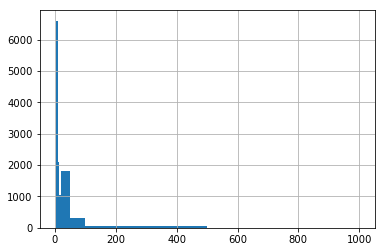

In [8]:
#Number of reviews by product
cnt_by_product = df[['asin','reviewText']].groupby('asin').agg('count')
cnt_by_product['reviewText'].hist(bins = [0,1,2,3,4,5,10,15,20,50,100,500,1000])

In [9]:
#Number of reviews by reviewer
cnt_by_reviewer = df[['reviewerID','reviewText']].groupby('reviewerID').agg('count').reset_index()

good_reviewers = cnt_by_reviewer[cnt_by_reviewer['reviewText']>4]
print(good_reviewers[:5])

good_products = cnt_by_product[cnt_by_product['reviewText']>4].reset_index()
print(good_products[:5])

              reviewerID  reviewText
0  A012468118FTQAINEI0OQ           6
1   A0182108CPDLPRCXQUZQ           8
2  A026961431MGW0616BRS3           6
3  A034597326Z83X79S50FI           7
4  A04295422T2ZG087R17FX           5
         asin  reviewText
0  0439893577          17
1  048645195X          11
2  0545496470           6
3  0615444172           6
4  0670010936          10


In [10]:
# Preprocess the reviews by HTML unescaping them

df = df.groupby(['asin','overall'], as_index=True)['reviewText'].apply(' '.join).apply(html.unescape).reset_index()
print("cleaned df columns:", list(df))


cleaned df columns: ['asin', 'overall', 'reviewText']


In [11]:
print("Cleaned DF", df[:5])
print("...{} records".format(len(df)))

Cleaned DF          asin  overall                                         reviewText
0  0439893577      3.0  this is a nice magnetic board for the kids to ...
1  0439893577      4.0  Love the magnet easel... great for moving to d...
2  0439893577      5.0  I like the item pricing. My granddaughter want...
3  048645195X      3.0  The pictures in this book are very detailed an...
4  048645195X      4.0  Working with Mandala type coloring books can t...
...34881 records


In [12]:
def remove_file(file_path):
    if os.path.isfile(file_path):
        print("Removing file '{}'...".format(file_path))
        os.remove(file_path)

In [116]:
from string import punctuation

IGNORED_LEMMAS = ['-PRON-', 'PRON', 'i']
IGNORED_POS = ['PUNCT', 'DET']
MAX_FEATURES_PER_REVIEW = 10

def check_embedded_punctuation(input_str):
    """ Check for 2 sequential punctuation characters in a string """
    from string import punctuation
    
    punct_count = 0
    
    for char in input_str:
        if char in punctuation:
            punct_count += 1
            if punct_count == 2:
                return True
        else:
            punct_count = 0
            
    return False
        

def get_lemmatized_chunk(chunk):
    """ Filter a noun chunk to exclude IGNORED_LEMMAS and return the remaining text and a computed word vector. """
    processed_text = []
    vector = np.zeros(300)
    stop_count = 0
    non_stop_count = 0
    doc = chunk
    for token in doc:
        if (token.lemma_ not in IGNORED_LEMMAS) and (token.pos_ not in IGNORED_POS):            
            this_text = token.text.strip()
            
            # check if this token contains 2 or more sequential punctuation characters
            if check_embedded_punctuation(this_text):
                stop_count += 1
                continue
            else:  
                non_stop_count += 1
                vector = vector + token.vector

            if this_text != token.text:
                processed_text.append(this_text)
            else:
                processed_text.append(token.lemma_.lower())   
        
    if (non_stop_count > 0) and (stop_count > 0):
        vector = np.divide(vector, non_stop_count)
    
    return " ".join(processed_text), vector


def get_vectors(text, nlp):
    """ <generator> Get embedding word vectors from a given text object. 
    Args
    ----------
    text (string)            text to be parsed, tokenized, and vectorized
    nlp (spaCy pipeline)     pipeline to use for processing the input text
    
    Generates:
    ----------
    processed text (string) 
    phrase vector (numpy.ndarray)
    """          
    # first, strip out the stop words and lowercase the words
    text = ' '.join([word.lower() for word in text.split() if not word in stopWords])
    
    doc = nlp(text)
    #####
    # Next, iterate through the sentences and within those the noun chunks.
    # These noun chunks will be lemmatized and collected as potential features.
    #####
    
    collected_terms = []
    term_vector_map = {}
    
    for sent in doc.sents:
        for chunk in sent.noun_chunks:
            #yield chunk.text, chunk.vector
            lemmatized_text, vect = get_lemmatized_chunk(chunk)
            if len(lemmatized_text) >0:
                collected_terms.append(lemmatized_text)
                term_vector_map[lemmatized_text] = vect
                
    term_rank = Counter(collected_terms)
    
    for ranked_term in term_rank.most_common(MAX_FEATURES_PER_REVIEW):
        term = ranked_term[0]
        yield term, term_vector_map[term]

In [117]:
def write_vectors(word_vects, out_m, product, rating, processed_text, concept_vec):
    """Write product, rating, phrase and sense vector to metadata and vectors files"""
    phrase = processed_text
    sense_vector = concept_vec
    print('\t'.join([product, str(rating),phrase]), file=out_m)
    word_vects.append([sense_vector])


In [118]:
# The following boolean controls whether the index list and the output np matrix are build by the vectorizing process.
# This can be used if appropriate for small datasets, but the repeated stacking of numpy arrays is expensive.
# Otherwise, these item are already written out to the files in metadata_filepath and vectors_filepath, using PyTables.
build_vects = False

remove_file(vectors_filepath)
remove_file(metadata_filepath)

# Create a sample vector, to determine the word vect dimension of a single entry
sample_vect = [vec for vec in get_vectors("example", nlp)][0][1]
vect_dim = sample_vect.shape
print("Sample vect[{}]".format(vect_dim))
index = []
output = None
vectors_count = 0

total_start = time.time()

#good_reviews = df[df['reviewerID'].isin(good_reviewers['reviewerID'])][df['asin'].isin(good_products['asin'])]
good_reviews = df[df['asin'].isin(good_products['asin'])]

#print("There are {} total reviews for reviewers with at least 5 reviews each and products with at least 5 reviews each".format(len(good_reviews)))
print("There are {} total reviews for products with at least 5 reviews each".format(len(good_reviews)))

start_ind = 0
iteration_size = 1000
#iter_limit = len(good_reviews)
iter_limit = 10000


print("\nCollecting word concept vectors for {} product/rating/reviews...".format(iter_limit))
display_local_time()

with open_file(vectors_filepath, mode="w", title="Word Vectors") as out_v:
    
    atom = tables.Float32Atom(vect_dim[0])
    shape = (0,)
    filters = tables.Filters(complevel=5, complib='zlib')
    word_vect = out_v.create_earray(out_v.root, 'vector', atom, shape, filters=filters)

with open(metadata_filepath, 'a') as out_m, open_file(vectors_filepath, mode="a", title="Word Vectors") as out_v:
    
    print("Word Vectors: ", out_v)
    
    for iteration in range(int(iter_limit/iteration_size)):

        print("Starting iteration over reviews {}-{}...".format(start_ind + iteration*iteration_size,
                                                                start_ind + (iteration+1)*iteration_size-1))
        
        iter_start_time = time.time()
        for iter_ind in range(iteration_size):
    
            review_ind = start_ind + iteration*iteration_size + iter_ind
        
            #reviewer = good_reviews['reviewerID'].iloc[review_ind]
            product = good_reviews['asin'].iloc[review_ind]
            rating = good_reviews['overall'].iloc[review_ind]
            review = good_reviews['reviewText'].iloc[review_ind]
    
            #print(review)
            for processed_text, concept_vec in get_vectors(review, nlp):
            
                # If there were no non-stop words in a given noun chunk, we will not add it to the vectors and metadata
                if (len(processed_text)>0):

                    write_vectors(out_v.root.vector, out_m, product, rating, processed_text, concept_vec)
                    vectors_count += 1
                    
                    # If this run is not just writing to disk, but should also build the vectors
                    if build_vects:                    
                        # Append data to a list and a numpy array
                        index.append([product, rating, processed_text])
        
                        if output is None:
                            # Create an np.array with the first row as the retrieved word vector
                            output = np.array([concept_vec])
                        else:
                            # Append the next vector to the end of the vectors array
                            output = np.append(output, [concept_vec], axis=0)            

        print("...completed processing {} reviews in {} seconds.".format(iteration_size, time.time()-iter_start_time))
    
print("...processed {} reviews in {} seconds, producing {} word vectors.".format((iteration+1)*iteration_size, time.time()-total_start, vectors_count))


Sample vect[(300,)]
There are 34881 total reviews for products with at least 5 reviews each

Local time = 18:39
Word Vectors:  ./data/vectors_each.pytab (File) 'Word Vectors'
Last modif.: 'Thu Jul  4 18:39:37 2019'
Object Tree: 
/ (RootGroup) 'Word Vectors'
/vector (EArray(0,), shuffle, zlib(5)) ''

Starting iteration over reviews 0-999...
...completed processing 1000 reviews in 58.74003481864929 seconds.
Starting iteration over reviews 1000-1999...
...completed processing 1000 reviews in 51.11882710456848 seconds.
Starting iteration over reviews 2000-2999...
...completed processing 1000 reviews in 51.081284046173096 seconds.
Starting iteration over reviews 3000-3999...
...completed processing 1000 reviews in 49.95612597465515 seconds.
Starting iteration over reviews 4000-4999...
...completed processing 1000 reviews in 40.65075492858887 seconds.
Starting iteration over reviews 5000-5999...
...completed processing 1000 reviews in 50.58773899078369 seconds.
Starting iteration over review

In [119]:
phrases = []
with open(metadata_filepath, 'r') as in_m:
    for line in in_m:
        phrase = line.split('\t')[2]
        phrases.append(phrase.strip())
        
phrase_count = Counter(phrases)

print("Here are the top {} phrases and their counts...".format(MAX_FEATURES_PER_REVIEW))

for counted_phrase in phrase_count.most_common(MAX_FEATURES_PER_REVIEW):
        phrase = counted_phrase[0]
        print(counted_phrase)


Here are the top 10 phrases and their counts...
('son', 1899)
('toy', 1785)
('kid', 1732)
('daughter', 1544)
('game', 1198)
('piece', 923)
('child', 804)
('thing', 623)
('something', 591)
('product', 501)


In [120]:
# Fit an HDBScan model using the sampled sense vectors

HDBSCAN_METRIC = 'manhattan'

with open_file(vectors_filepath, mode="r", title="Word Vectors") as word_vectors:

    print("word_vectors: ", word_vectors)
    
    start = time.time()
    print("Creating word clusters from word vectors...")
    display_local_time()
    hdbscanner = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, 
                                 metric=HDBSCAN_METRIC, gen_min_span_tree=True, prediction_data=True)
    hdbscanner.fit(word_vectors.root.vector)
    print("...completed clustering in {} seconds.".format(time.time()-start))

word_vectors:  ./data/vectors_each.pytab (File) 'Word Vectors'
Last modif.: 'Thu Jul  4 18:47:31 2019'
Object Tree: 
/ (RootGroup) 'Word Vectors'
/vector (EArray(89869,), shuffle, zlib(5)) ''

Creating word clusters from word vectors...
Local time = 18:51
...completed clustering in 4356.584135055542 seconds.


In [121]:
with open_file(vectors_filepath, mode="r", title="Word Vectors") as word_vectors:
    vdim = len(word_vectors.root.vector)
    print("word-vectors{}: ".format(vdim), word_vectors.root.vector)
# Save the HDBScan model with a name indicating the number of word vectors clustered
    with open('./data/hdbscanner.{}.pickle'.format(vdim), 'wb') as pickle_file:
        pickle.dump(hdbscanner, pickle_file)

word-vectors89869:  /vector (EArray(89869,), shuffle, zlib(5)) ''


Condensing the linkage tree and then plotting...
...plotted condensed tree in 41.51271414756775 seconds.
Found 1190 clusters


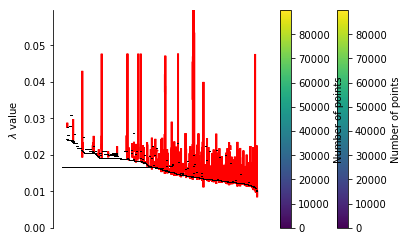

In [122]:
# Plot the condensed cluster tree


if plotting:
	start = time.time()
	print("Condensing the linkage tree and then plotting...")
	#hdbscanner.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
	hdbscanner.condensed_tree_.plot()
	hdbscanner.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
	print("...plotted condensed tree in {} seconds.".format(time.time()-start))
	tree = hdbscanner.condensed_tree_
	print("Found {} clusters".format(len(tree._select_clusters())))
	matplotlib.pyplot.show()

In [123]:
display_local_time()
print("Saving the CondensedTree to disk...")
start = time.time()
np.save("./data/condensedTree.npy", tree)
print("...finished saving the CondensedTree in {} seconds.".format(time.time()-start))

Local time = 20:21
Saving the CondensedTree to disk...
...finished saving the CondensedTree in 0.01604604721069336 seconds.


In [124]:
print("Saving spacy language model to disk...")
display_local_time()
start = time.time()
nlp.to_disk("./data/spacy.language.model.nlp")
print("...finished saving spacy language model in {} seconds.".format(time.time()-start))

Saving spacy language model to disk...
Local time = 20:21
...finished saving spacy language model in 5.6898651123046875 seconds.


In [125]:
def get_exemplars(cluster_id, condensed_tree):
    """ Collect and return the exemplar words for each cluster. """
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) & 
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)

In [126]:
with open(metadata_filepath, 'r') as in_m, open("data/metadata_ouch.tsv", 'w') as out_m:
    item = 0
    for line in in_m:
        fields = line.split('\t')
        if len(fields) > 1:
            print("Fields: ", fields)
            phrase = fields[2]
            phrase = phrase[0:-1:2]
            print("Phrase: ", phrase.split())
            fields[:2]=phrase[:len(phrase)-1]
            out_line = '\t'.join(fields)
            print("Out line: ", out_line)
            item += 1
            if item == 10:
                break

Fields:  ['0439893577', '3.0', 'board\n']
Phrase:  ['bad']
Out line:  b	a	board

Fields:  ['0439893577', '3.0', 'note\n']
Phrase:  ['nt']
Out line:  n	note

Fields:  ['0439893577', '3.0', 'wooden letter\n']
Phrase:  ['woe', 'etr']
Out line:  w	o	e	 	e	t	wooden letter

Fields:  ['0439893577', '3.0', 'additional magnetic piece\n']
Phrase:  ['adtoa', 'antcpee']
Out line:  a	d	t	o	a	 	a	n	t	c	p	e	additional magnetic piece

Fields:  ['0439893577', '3.0', 'grandson\n']
Phrase:  ['gado']
Out line:  g	a	d	grandson

Fields:  ['0439893577', '3.0', 'top hallway table\n']
Phrase:  ['tphlwytbe']
Out line:  t	p	h	l	w	y	t	b	top hallway table

Fields:  ['0439893577', '3.0', 'age\n']
Phrase:  ['ae']
Out line:  a	age

Fields:  ['0439893577', '3.0', 'thi play time hope\n']
Phrase:  ['tipa', 'iehp']
Out line:  t	i	p	a	 	i	e	h	thi play time hope

Fields:  ['0439893577', '3.0', 'quality magnet\n']
Phrase:  ['qaiymge']
Out line:  q	a	i	y	m	g	quality magnet

Fields:  ['0439893577', '3.0', 'size\n']
Phrase:  [

In [130]:
tree = hdbscanner.condensed_tree_

#print('Index, for reference:')
#for ind, entry in enumerate(index):
#    print("cluster: {}, ind: {}, entry: {}".format(hdbscanner.labels_[ind], ind, entry))

start = time.time()
print("Selecting clusters in tree...")
clusters = tree._select_clusters()
print("...finished selecting clusters in {} seconds.".format(time.time()-start))

initial_cluster_count = len(clusters)
print("Found {} clusters".format(initial_cluster_count))

index = []
all_points = []
labels = []

# iterate through the input metadata once, to collect all words and the word labels for the sampled points
with open(metadata_filepath, 'r') as in_m:
	mdim = None
	curr_line = 0
	for line in in_m:
		if mdim is None:
			mdim = line.count('\t')+1
			print('File {} contains index entries of of dimension {}'.format(metadata_filepath, vdim))
		if line.endswith('\n'):
			line = line[:-1]
		all_points.append(line.split('\t'))
		sample_this_row = True
		if sample_this_row:
			meta_line = line.split('\t')
			index.append(meta_line)
			if labels_words:
				labels.append(meta_line[2])
		curr_line += 1

print("All Points({}, {}): {}".format(len(all_points), len(all_points[0]), all_points[:5]))

# then, iterate through the input metadata again, to apply the cluster labels, if labels_words is False
with open(metadata_filepath, 'r') as in_m:
	mdim = None
	curr_line = 0
	curr_sample = 0

	for line in in_m:
		if mdim is None:
			mdim = line.count('\t')+1
			print('File {} contains {} index entries.'.format(metadata_filepath, vdim))
		if line.endswith('\n'):
			line = line[:-1]
		sample_this_row = True
		if sample_this_row:
			index.append(line.split('\t'))
			if not labels_words:
				labels.append("-")
			curr_sample += 1
		curr_line += 1


Selecting clusters in tree...
...finished selecting clusters in 0.33533215522766113 seconds.
Found 1190 clusters
File ./data/metadata_each.tsv contains index entries of of dimension 89869
All Points(89869, 3): [['0439893577', '3.0', 'board'], ['0439893577', '3.0', 'note'], ['0439893577', '3.0', 'wooden letter'], ['0439893577', '3.0', 'additional magnetic piece'], ['0439893577', '3.0', 'grandson']]
File ./data/metadata_each.tsv contains 89869 index entries.


In [136]:
print(hdbscanner.exemplars_)

[array([[ 0.96969   ,  0.564992  , -0.55678   , ..., -0.39916   ,
         0.3121927 , -0.62304   ],
       [ 0.64261   ,  0.352752  , -0.720364  , ..., -0.38665   ,
         0.1105727 , -0.39114   ],
       [ 0.5646    ,  0.081752  , -0.27850997, ..., -0.79247   ,
        -0.17438729, -0.393485  ],
       ...,
       [ 0.5646    ,  0.081752  , -0.27850997, ..., -0.79247   ,
        -0.17438729, -0.393485  ],
       [ 0.5646    ,  0.081752  , -0.27850997, ..., -0.79247   ,
        -0.17438729, -0.393485  ],
       [ 0.873371  ,  0.353642  , -0.48068398, ..., -1.36851   ,
         0.00339571, -0.318036  ]], dtype=float32), array([[-1.4575441 , -0.42575002, -0.11413301, ..., -0.26433   ,
         0.51432   ,  1.38579   ],
       [-1.689657  , -0.65515   , -0.298969  , ..., -0.406197  ,
         0.64261   ,  1.48489   ],
       [-1.689657  , -0.65515   , -0.298969  , ..., -0.406197  ,
         0.64261   ,  1.48489   ],
       ...,
       [-1.4772971 , -0.9645    , -0.08754901, ..., -0.298

In [139]:
print(nlp.vocab.vectors.most_similar(hdbscanner.exemplars_[1]))

(array([11927340208749493983, 11927340208749493983, 11927340208749493983,
       10690717480206833971, 11927340208749493983, 11927340208749493983,
       11927340208749493983, 11927340208749493983, 11927340208749493983,
       10690717480206833971], dtype=uint64), array([1048, 1048, 1048,  445, 1048, 1048, 1048, 1048, 1048,  445],
      dtype=int32), array([0.7306235, 0.7272396, 0.7272396, 0.7507367, 0.7774488, 0.7774488,
       0.7774488, 0.7774488, 0.7774488, 0.7033991], dtype=float32))


In [133]:
selected_clusters = []
cluster_map = {}
cluster_exemplar_map = {}

for i, c in enumerate(clusters):
    c_exemplars = get_exemplars(c, tree)

    point_label = None
    cluster_exemplars = set()
    for ind, ex_ind in enumerate(c_exemplars):
        #print("Exemplar -- {} : {}".format(index[ex_ind][0], index[ex_ind][2]))
        cluster_exemplars.add(index[ex_ind][2])
        if point_label is None:
            point_label = index[ex_ind][2]
    
    members = set()
    for label_ind, label in np.ndenumerate(hdbscanner.labels_):
        if label == i:
            members.add(index[label_ind[0]][2])
            if not labels_words:
                labels[label_ind[0]] = point_label
            
            #print("Member: {} : {}".format(index[label_ind[0]][0], index[label_ind[0]][2]))
    
    exemplars_len = float(len(cluster_exemplars))
    members_len = float(len(members))
    
    # Look for clusters where the members outnumber the exemplars by 2 times
    if ((exemplars_len>0) and (len(members)>(2.0*exemplars_len))):
    
        example_cluster_exemplars = "|".join(cluster_exemplars)
        example_cluster_members = "|".join(members)
        
        selected_clusters.append((example_cluster_exemplars, example_cluster_members))
        # with the index of the cluster (treated as label by hdbscanner) as a key, store the index into selected_clusters
        cluster_map[str(i)] = len(selected_clusters)-1
        cluster_exemplar_map[str(i)] = cluster_exemplars

selected_cluster_count = len(selected_clusters)
if (selected_cluster_count>0):
    print("\nFound {} clusters ({}% of initially collected):".
          format(len(selected_clusters), 100.0*float(selected_cluster_count)/float(initial_cluster_count)))
    for example in selected_clusters:
        print("\nExemplars: {}".format(example[0]))
        print("Members: {}".format(example[1]))

with open(path_for_tf_metadata+'/metadata.tsv', 'w') as out_tf_meta:
    for label in labels:
        out_tf_meta.write(str(label)+'\n')
                                                                    
noise_count = sum([1 for label in hdbscanner.labels_ if label == -1])
print("\nThere were {} words that were considered noise.".format(noise_count))

np.save('./data/selected_clusters.npy', selected_clusters)



Found 447 clusters (37.563025210084035% of initially collected):

Exemplars: zingo|fluxx
Members: rule fluxx|idea fluxx|zombie fluxx|pirate fluxx|fluxx|star fluxx|fluxx game|zingo

Exemplars: 2-year old daughter|1-year old daughter|3-year old daughter|2-year old granddaughter|3-year old granddaughter
Members: 1-year old daughter|3-year old daughter|2-year old boy|3-year old brother|3-year old granddaughter|3-year old grandson|nearly 3-year old granddaughter|3-year old son|2-year old granddaughter|2-year old daughter|3-year old girl|2-year old love

Exemplars: yasmin
Members: yasmin|poor yasmin|yasmin doll

Exemplars: 2 year old|3 year old
Members: right 2 year old|1 year old|2 year old|2 two year old|little 3 year old|3 & 5 year old|three four year old|10 year old|3 year old|three year old|many 2 year old|2 3 year old|12 month old|four year old|6 3 year old|4 1 year old|18 month old|13 month old|5 & 6 year old|8 year old|4 year old|even two year old|6 year old|two year old|4 5 year ol

In [135]:
print(hdbscanner.labels_)

[ 935  908   -1 ...   -1   -1 1063]


In [142]:
def get_scored_exemplars(phrase, cluster_id):
    """ TODO -- Given a phase and a cluster_id (the label from hdbscanner for the phrase) return a set of scored exemplars.
    
    Note that this function doesn't yet return the results it should. The cell below does produce the right results though, and should be used instead.
    """
    scored_exemplars = {}
    exemplars = cluster_exemplar_map.get(str(cluster_id))
    if exemplars is None:
        return None
        exemplars = get_exemplars(cluster_id, hdbscanner.condensed_tree_)
        cluster_exemplars[str(cluster_id)]=exemplars
        
    phrase_doc = nlp(phrase)
    for exemplar in exemplars:
        exemp_doc = nlp(exemplar)
        scored_exemplars[exemplar]=phrase_doc.similarity(exemp_doc)
        
    return scored_exemplars

clustered_labels = [labels for labels, _ in cluster_exemplar_map.items()]

for ind, label in enumerate(hdbscanner.labels_):
    product = index[ind][0]
    phrase = index[ind][2]
    cluster_id = label
    
    if (cluster_id >= 0) and (cluster_id in clustered_labels):
        
        print("Product: {}, phrase: '{}', scored_exemplars: {}".format(product, phrase, 
                                                                       get_scored_exemplars(phrase, cluster_id,)))

In [140]:
print("selected_clusters:", selected_clusters[:5])
print("cluster_map:", [item for item in cluster_map.items()][:5])

def get_score(exem_tuple):
    return -exem_tuple[1]

with open('./data/product_features.csv', 'w') as prod_features_file:
    
    # create an empty dict in which to hold phrases we've already seen associated with a product
    visited_product_phrases = {}
    
    for ind, cluster_ind in enumerate(hdbscanner.labels_):
        # A non-negative hdbscanner label for a point indicates assignment to a cluster
        if cluster_ind >= 0:
            cluster_detail_ind = cluster_map.get(str(cluster_ind))
            if cluster_detail_ind is None:
                continue
            else:
                print("Found detail for cluster {} : {}".format(cluster_ind, cluster_detail_ind))
            cluster_detail = selected_clusters[cluster_detail_ind]
            product = index[ind][0]
            rating = index[ind][1]
            phrase = index[ind][2]
            
            # see if we've already seen this phrase in this product, if so skip it
            already_visited_list = visited_product_phrases.get(product)
            if already_visited_list is None:
                visited_product_phrases[product]=[phrase]
            else:
                if phrase in already_visited_list:
                    continue
                else:
                    already_visited_list.append(phrase)
                    visited_product_phrases[product] = already_visited_list
                    
            phrase_doc = nlp(phrase)

            exemplars = cluster_detail[0]
            scored_exemplars = []
            for exemp in exemplars.split("|"):
                exemp_doc = nlp(exemp)
                ex_similarity = phrase_doc.similarity(exemp_doc)
                scored_exemplars.append((exemp, ex_similarity))
            scored_exemplars = sorted(scored_exemplars, key=get_score)
        
            print("product:{}, rating:{}, phrase:'{}', cluster:{}, exemplars:{}".format(product, rating, phrase, cluster_ind, scored_exemplars))
            print("{}, {}, {}, '{}', {}".format(product, rating, cluster_ind, scored_exemplars[0][0], scored_exemplars), file=prod_features_file)

selected_clusters: [('zingo|fluxx', 'rule fluxx|idea fluxx|zombie fluxx|pirate fluxx|fluxx|star fluxx|fluxx game|zingo'), ('2-year old daughter|1-year old daughter|3-year old daughter|2-year old granddaughter|3-year old granddaughter', '1-year old daughter|3-year old daughter|2-year old boy|3-year old brother|3-year old granddaughter|3-year old grandson|nearly 3-year old granddaughter|3-year old son|2-year old granddaughter|2-year old daughter|3-year old girl|2-year old love'), ('yasmin', 'yasmin|poor yasmin|yasmin doll'), ('2 year old|3 year old', 'right 2 year old|1 year old|2 year old|2 two year old|little 3 year old|3 & 5 year old|three four year old|10 year old|3 year old|three year old|many 2 year old|2 3 year old|12 month old|four year old|6 3 year old|4 1 year old|18 month old|13 month old|5 & 6 year old|8 year old|4 year old|even two year old|6 year old|two year old|4 5 year old|ten one year old'), ('kite|kite herself!update', 'kite|one kite|kite gift|kite herself!update|look 

product:074242720X, rating:5.0, phrase:'high quality', cluster:782, exemplars:[('high quality', 1.0)]
Found detail for cluster 132 : 54
product:0786950072, rating:1.0, phrase:'shame hasbro', cluster:132, exemplars:[('nintendo', 0.841826716188697), ('hasbro', 0.841826716188697)]
Found detail for cluster 76 : 30
product:0786950072, rating:1.0, phrase:'cheap cardboard', cluster:76, exemplars:[('cheap plastic', 0.8889827756914634), ('plastic cheap', 0.8889827756914634)]
Found detail for cluster 579 : 244
product:0786950072, rating:3.0, phrase:'magic', cluster:579, exemplars:[('magic', 1.0), ('magic pegausus', 0.9999999844261754), ('magician', 0.9999999844261754)]
Found detail for cluster 591 : 249
product:0786950072, rating:3.0, phrase:'company', cluster:591, exemplars:[('company', 1.0), ('inspiration!great company', 0.9999999520291755)]
Found detail for cluster 743 : 320
product:0786950072, rating:3.0, phrase:'world point', cluster:743, exemplars:[('world', 0.8632048851618238)]
Found deta

product:0975855603, rating:3.0, phrase:'seat', cluster:274, exemplars:[('seat', 1.0)]
Found detail for cluster 463 : 200
product:0975855603, rating:3.0, phrase:'plastic case', cluster:463, exemplars:[('flimy plastic', 0.8658618940098562), ('him.the plastic', 0.8658618940098562), ('plastic', 0.8658618940098562)]
Found detail for cluster 1164 : 444
product:0975855603, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 761 : 329
product:0976142503, rating:1.0, phrase:'school', cluster:761, exemplars:[('school', 1.0)]
Found detail for cluster 1007 : 412
product:0976142503, rating:3.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 363 : 152
product:0976142503, rating:3.0, phrase:'working mechanism', cluster:363, exemplars:[('mechanism', 0.849585905831999)]
Found detail for cluster 631 : 265
product:0976142503, rating:3.0, phrase:'even instruction', cluster:631, exemplars:[('instruction', 0.8587462971993838)]


product:0984608028, rating:5.0, phrase:'version', cluster:781, exemplars:[('version', 1.0)]
Found detail for cluster 782 : 337
product:0984608028, rating:5.0, phrase:'high quality', cluster:782, exemplars:[('high quality', 1.0)]
Found detail for cluster 743 : 320
product:0992251656, rating:2.0, phrase:'world', cluster:743, exemplars:[('world', 1.0)]
Found detail for cluster 580 : 245
product:0992251656, rating:2.0, phrase:'niska win', cluster:580, exemplars:[('squawker winner', 0.7326611501454113), ('winner', 0.7326611501454113)]
Found detail for cluster 412 : 179
product:0992251656, rating:4.0, phrase:'theme', cluster:412, exemplars:[('theme', 1.0)]
Found detail for cluster 738 : 315
product:0992251656, rating:5.0, phrase:'job', cluster:738, exemplars:[('job', 1.0), ('job ideal.we', 0.9999999130286567)]
Found detail for cluster 647 : 274
product:0992251656, rating:5.0, phrase:'action', cluster:647, exemplars:[('action', 1.0)]
Found detail for cluster 276 : 119
product:0992251656, rati

product:1564518531, rating:5.0, phrase:'1.5-year old daughter', cluster:636, exemplars:[('old daughter', 1.0000000190977187), ('1.5-year old daughter', 1.0)]
Found detail for cluster 744 : 321
product:1570545340, rating:4.0, phrase:'clothe', cluster:744, exemplars:[('clothe', 1.0)]
Found detail for cluster 606 : 254
product:1570545340, rating:5.0, phrase:'great project', cluster:606, exemplars:[('project', 0.8366879534603279)]
Found detail for cluster 469 : 203
product:1570545340, rating:5.0, phrase:'paper', cluster:469, exemplars:[('paper', 1.0), ('aremade paper', 0.9999999135991271), ('paper machet', 0.9999999135991271)]
Found detail for cluster 469 : 203
product:1570545340, rating:5.0, phrase:'run paper', cluster:469, exemplars:[('aremade paper', 0.8187642348848835), ('paper machet', 0.8187642348848835), ('paper', 0.8187642348848835)]
Found detail for cluster 96 : 37
product:1579822460, rating:3.0, phrase:'manner finger puppet', cluster:96, exemplars:[('puppet', 0.7283203924169581)]

product:158994206X, rating:5.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 535 : 228
product:158994206X, rating:5.0, phrase:'role', cluster:535, exemplars:[('role', 1.0)]
Found detail for cluster 838 : 362
product:1589942108, rating:1.0, phrase:'order', cluster:838, exemplars:[('order', 1.0)]
Found detail for cluster 935 : 393
product:1589942108, rating:1.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 604 : 253
product:1589942108, rating:2.0, phrase:'monster', cluster:604, exemplars:[('monster', 1.0)]
Found detail for cluster 935 : 393
Found detail for cluster 608 : 256
product:1589942108, rating:2.0, phrase:'item', cluster:608, exemplars:[('item', 1.0), ('well.the item', 0.9999999838617295), ('thias item', 0.9999999838617295), ('great.this item', 0.9999999838617295)]
Found detail for cluster 507 : 217
product:1589942108, rating:3.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071

product:1591747775, rating:4.0, phrase:'lego set', cluster:228, exemplars:[('playmobile', 0.8430491387179707), ('lego', 0.8430491387179707), ('legos', 0.8430491387179707), ('knex', 0.8430491387179707), ('marklin', 0.8430491387179707), ('playmobil', 0.8430491387179707), ('duplo', 0.8430491387179707), ('playskool', 0.8430491387179707)]
Found detail for cluster 992 : 409
product:1591747775, rating:4.0, phrase:'little boy', cluster:992, exemplars:[('little girl', 0.9315662745856108)]
Found detail for cluster 228 : 100
product:1591747775, rating:5.0, phrase:'lego', cluster:228, exemplars:[('playmobile', 1.0000000499331854), ('legos', 1.0000000499331854), ('knex', 1.0000000499331854), ('marklin', 1.0000000499331854), ('playmobil', 1.0000000499331854), ('duplo', 1.0000000499331854), ('playskool', 1.0000000499331854), ('lego', 1.0)]
Found detail for cluster 755 : 326
product:1591747775, rating:5.0, phrase:'car', cluster:755, exemplars:[('car', 1.0)]
Found detail for cluster 433 : 187
product:1

product:1616611359, rating:3.0, phrase:'defeat', cluster:580, exemplars:[('squawker winner', 0.33444641038446854), ('winner', 0.33444641038446854)]
Found detail for cluster 128 : 51
Found detail for cluster 507 : 217
product:1616611359, rating:4.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 507 : 217
Found detail for cluster 604 : 253
product:1616611359, rating:5.0, phrase:'monster', cluster:604, exemplars:[('monster', 1.0)]
Found detail for cluster 128 : 51
Found detail for cluster 507 : 217
product:1616611626, rating:5.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 766 : 331
product:1616611626, rating:5.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 259 : 111
product:1616611715, rating:4.0, phrase:'fish', cluster:259, exemplars:[('fish', 1.0)]
Found detail for cluster 837 : 361
product:1616611715, rating:4.0, phras

product:1616614609, rating:5.0, phrase:'corp', cluster:591, exemplars:[('company', 0.41785168356649327), ('inspiration!great company', 0.41785168356649327)]
Found detail for cluster 363 : 152
product:1616615044, rating:4.0, phrase:'mechanism', cluster:363, exemplars:[('mechanism', 1.0)]
Found detail for cluster 128 : 51
product:1616615044, rating:5.0, phrase:'two dice', cluster:128, exemplars:[('chessex dice', 0.8347057975802606), ('dice', 0.8347057975802606)]
Found detail for cluster 507 : 217
product:1616615044, rating:5.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 638 : 269
product:1616615354, rating:3.0, phrase:'3game system', cluster:638, exemplars:[('3game system', 1.0), ('mobigo system', 0.9999999127908461), ('geotrax system', 0.9999999127908461), ('system', 0.9999999127908461), ('3rules system', 0.9999999127908461)]
Found detail for cluster 276 : 119
product:1616615354, rating:5.0, phrase:'ship', cluster:276

product:1892069725, rating:5.0, phrase:'gold', cluster:152, exemplars:[('gold', 1.0)]
Found detail for cluster 645 : 273
product:1892069725, rating:5.0, phrase:'different goal', cluster:645, exemplars:[('goal', 0.8493622498428034)]
Found detail for cluster 645 : 273
product:192978001X, rating:1.0, phrase:'goal', cluster:645, exemplars:[('goal', 1.0)]
Found detail for cluster 794 : 343
product:192978001X, rating:2.0, phrase:'decision', cluster:794, exemplars:[('decision', 1.0)]
Found detail for cluster 295 : 126
product:192978001X, rating:2.0, phrase:'mix', cluster:295, exemplars:[('mix', 1.0)]
Found detail for cluster 687 : 291
product:192978001X, rating:2.0, phrase:'little strategy', cluster:687, exemplars:[('strategy', 0.8180438235870015)]
Found detail for cluster 507 : 217
product:192978001X, rating:3.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 507 : 217
Found detail for cluster 2 : 0
product:192978001X, rating:

product:1933054395, rating:5.0, phrase:'strategy', cluster:687, exemplars:[('strategy', 1.0)]
Found detail for cluster 1042 : 419
product:1933054913, rating:3.0, phrase:'occuply child', cluster:1042, exemplars:[('operate.both child', 1.0000000381415877), ('child', 1.0000000381415877), ('occuply child', 1.0)]
Found detail for cluster 891 : 383
product:1933054913, rating:4.0, phrase:'long time', cluster:891, exemplars:[('long time', 1.0)]
Found detail for cluster 654 : 279
product:1933054913, rating:4.0, phrase:'lot patience', cluster:654, exemplars:[('patience', 0.8692983614659595)]
Found detail for cluster 717 : 307
product:1933054913, rating:5.0, phrase:'santa', cluster:717, exemplars:[('santa', 1.0)]
Found detail for cluster 211 : 90
product:1933318430, rating:2.0, phrase:'lot movie', cluster:211, exemplars:[('movie', 0.8742820423501041), ('arr movie preimere', 0.5499076349559662)]
Found detail for cluster 211 : 90
product:1933318430, rating:3.0, phrase:'movie', cluster:211, exemplar

product:1936300036, rating:4.0, phrase:'10 yr old daughter', cluster:440, exemplars:[('10 yr old daughter', 1.0), ('8 yr old daughter', 0.9881034541300816), ('5 yr old daughter', 0.9854443019219706), ('6 yr old daughter', 0.9852148867192407), ('4 yr old daughter', 0.9739902568886329), ('8 yr old granddaughter', 0.9658568934200024), ('4 yr old granddaughter', 0.9504686159494832)]
Found detail for cluster 1132 : 439
Found detail for cluster 889 : 382
product:1936300036, rating:5.0, phrase:'number', cluster:889, exemplars:[('number', 1.0)]
Found detail for cluster 756 : 327
product:1936300036, rating:5.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 902 : 387
product:1938146905, rating:4.0, phrase:'point', cluster:902, exemplars:[('point', 1.0)]
Found detail for cluster 128 : 51
product:1938146999, rating:4.0, phrase:'dice', cluster:128, exemplars:[('dice', 1.0), ('chessex dice',

product:8499009522, rating:4.0, phrase:'christma toy', cluster:239, exemplars:[('toy christma', 0.9999999842704513)]
Found detail for cluster 275 : 118
product:8499009522, rating:4.0, phrase:'shipping', cluster:275, exemplars:[('shipping', 1.0)]
Found detail for cluster 223 : 96
product:8499009522, rating:4.0, phrase:'creep speed', cluster:223, exemplars:[('speed', 0.8453697591871837), ('much speed', 0.8002717096894546), ('right speed', 0.778197218844329), ('full speed', 0.7578234625061475)]
Found detail for cluster 748 : 323
product:8499009522, rating:4.0, phrase:'great value', cluster:748, exemplars:[('good value', 0.9531738820202668)]
Found detail for cluster 346 : 146
Found detail for cluster 660 : 282
product:8677805966, rating:1.0, phrase:'flight.this particular unit', cluster:660, exemplars:[('unit', 0.868461505960634), ('didj unit', 0.868461505960634)]
Found detail for cluster 82 : 33
product:8677805966, rating:1.0, phrase:'oscillating motion', cluster:82, exemplars:[('motion',

product:B00000DMCE, rating:5.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 773 : 333
product:B00000DMD2, rating:1.0, phrase:'brand', cluster:773, exemplars:[('brand', 1.0), ('lumistick brand', 0.9999999987871694)]
Found detail for cluster 350 : 147
product:B00000DMD2, rating:1.0, phrase:'drawer', cluster:350, exemplars:[('drawer', 1.0), ('cupboard', 0.9999999805588674), ('divider', 0.43909708246035123)]
Found detail for cluster 868 : 371
product:B00000DMD2, rating:1.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 360 : 151
product:B00000DMD2, rating:2.0, phrase:'positive review', cluster:360, exemplars:[('negative review', 0.918021090710953)]
Found detail for cluster 773 : 333
Found detail for cluster 350 : 147
Found detail for cluster 346 : 146
product:B00000DMD2, rating:3.0, phrase:'amazon', cluster:346, exemplars:[('amazon themsnowbnall', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 453 : 196
pr

product:B00000DMFS, rating:1.0, phrase:'what waste money', cluster:400, exemplars:[('waste money', 0.9526501711830352), ('awaya waste money', 0.9526501020605128)]
Found detail for cluster 592 : 250
product:B00000DMFS, rating:1.0, phrase:'game kid', cluster:592, exemplars:[('kid game', 1.0000000509759563), ('game kid', 1.0), ('great game kid', 0.9456297674004965), ('game parent', 0.8227044340754291)]
Found detail for cluster 1036 : 417
product:B00000DMFS, rating:2.0, phrase:'two people', cluster:1036, exemplars:[('two people', 1.0)]
Found detail for cluster 681 : 289
product:B00000DMFS, rating:4.0, phrase:'young child', cluster:681, exemplars:[('young child', 1.0)]
Found detail for cluster 609 : 257
product:B00000DMFS, rating:4.0, phrase:'five year old son', cluster:609, exemplars:[('three year old son', 0.9954483046361867)]
Found detail for cluster 612 : 258
product:B00000DMFS, rating:4.0, phrase:'ten year old daughter', cluster:612, exemplars:[('five year old daughter', 0.985215413996

product:B00000IRW0, rating:4.0, phrase:'full stuff animal', cluster:87, exemplars:[('stuff animal', 0.9258031347587677), ('soft stuff animal', 0.8771808091765605)]
Found detail for cluster 342 : 144
product:B00000IRW0, rating:5.0, phrase:'bus', cluster:342, exemplars:[('bus', 1.0)]
Found detail for cluster 1110 : 433
product:B00000IRW0, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 609 : 257
product:B00000IRW0, rating:5.0, phrase:'four year old son', cluster:609, exemplars:[('three year old son', 0.9975860653003926)]
Found detail for cluster 1110 : 433
product:B00000IRWA, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 766 : 331
p

product:B00000IS0P, rating:5.0, phrase:'fun toy', cluster:831, exemplars:[('toy fun', 1.0000000393787984), ('moby!moby fun toy', 1.0000000274038554), ('fun toy', 1.0)]
Found detail for cluster 42 : 11
product:B00000IS1N, rating:3.0, phrase:'new instrument', cluster:42, exemplars:[('instrument', 0.8486390932061535)]
Found detail for cluster 631 : 265
product:B00000IS1N, rating:4.0, phrase:'instruction', cluster:631, exemplars:[('instruction', 1.0)]
Found detail for cluster 42 : 11
product:B00000IS1N, rating:4.0, phrase:'instrument limitation', cluster:42, exemplars:[('instrument', 0.8239499334849594)]
Found detail for cluster 203 : 89
product:B00000IS1N, rating:5.0, phrase:'accordion', cluster:203, exemplars:[('guitar', 0.6005098260588267), ('harmonica', 0.6005098260588267)]
Found detail for cluster 838 : 362
product:B00000ISC5, rating:1.0, phrase:'order', cluster:838, exemplars:[('order', 1.0)]
Found detail for cluster 136 : 57
product:B00000ISC5, rating:1.0, phrase:'terrible customer 

product:B00000ISUK, rating:1.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 463 : 200
product:B00000ISUK, rating:1.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 345 : 145
product:B00000ISUK, rating:1.0, phrase:'long hair', cluster:345, exemplars:[('tanbrown hair', 0.9019438730597504), ('spagettie hair', 0.9019438730597504), ('hair', 0.9019438730597504)]
Found detail for cluster 740 : 317
product:B00000ISUK, rating:2.0, phrase:'loader', cluster:740, exemplars:[('load', 0.7880826114540952)]
Found detail for cluster 740 : 317
product:B00000ISUK, rating:2.0, phrase:'load', cluster:740, exemplars:[('load', 1.0)]
Found detail for cluster 958 : 400
product:B00000ISUK, rating:2.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 48 : 16
product:B00000ISUK, rating:3.0, phrase:'engine', cluster:48, exemplars:[(

product:B00000IUBJ, rating:2.0, phrase:'motion', cluster:82, exemplars:[('motion', 1.0)]
Found detail for cluster 95 : 36
product:B00000IUBJ, rating:2.0, phrase:'handel', cluster:95, exemplars:[('haba', 1.0000001086817365), ('handel', 1.0)]
Found detail for cluster 776 : 334
product:B00000IUBJ, rating:3.0, phrase:'worth money', cluster:776, exemplars:[('well worth money', 0.9584966248641851)]
Found detail for cluster 952 : 399
product:B00000IUBJ, rating:5.0, phrase:'always hard time', cluster:952, exemplars:[('even hard time', 0.9672628518426798), ('hard time', 0.9634547367436439)]
Found detail for cluster 825 : 358
product:B00000IUBJ, rating:5.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 655 : 280
product:B00000IUBJ, rating:5.0, phrase:'squeak', cluster:655, exemplars:[('squeak', 1.0), ('rattle', 0.9999999643560038), ('noise', 0.7542578475029622)]
Found detail for cluster 790 : 341
product:B00000IUBJ, rating:5.0,

product:B00000IUXC, rating:5.0, phrase:'hold tent', cluster:146, exemplars:[('tent', 0.8552847689048617)]
Found detail for cluster 711 : 304
product:B00000IUYM, rating:3.0, phrase:'building', cluster:711, exemplars:[('geomotion building', 1.000000012563398), ('building', 1.0)]
Found detail for cluster 707 : 300
product:B00000IUYM, rating:4.0, phrase:'real wood', cluster:707, exemplars:[('mdf', 0.8456592253902674), ('plywood', 0.8456592253902674), ('necissenit wood', 0.8456592253902674), ('wood', 0.8456592253902674), ('wood outgass', 0.8456592253902674)]
Found detail for cluster 748 : 323
product:B00000IUYM, rating:4.0, phrase:'good value', cluster:748, exemplars:[('good value', 1.0)]
Found detail for cluster 445 : 192
product:B00000IUYM, rating:4.0, phrase:'america', cluster:445, exemplars:[('usa', 0.7406450087533194)]
Found detail for cluster 463 : 200
product:B00000IUYM, rating:4.0, phrase:'rather plastic', cluster:463, exemplars:[('flimy plastic', 0.8755627457113679), ('him.the plas

product:B00000IVAK, rating:5.0, phrase:'team', cluster:485, exemplars:[('team', 1.0)]
Found detail for cluster 1164 : 444
product:B00000IVAK, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 106 : 42
product:B00000IVAK, rating:5.0, phrase:'jack', cluster:106, exemplars:[('jack', 1.0)]
Found detail for cluster 935 : 393
product:B00000IVAK, rating:5.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 44 : 13
product:B00000IVUJ, rating:3.0, phrase:'well carpet', cluster:44, exemplars:[('carpet', 0.8804539933491348)]
Found detail for cluster 545 : 232
product:B00000IVUJ, rating:3.0, phrase:'toy pull box', cluster:545, exemplars:[('toy box', 0.9397930214898436)]
Found detail for cluster 381 : 164
product:B00000IVUJ, rating:5.0, phrase:'great educational toy', cluster:381, exemplars:[('great educational toy', 1.0), ('good educational toy', 0.975561287049152), ('nice educational toy', 0.954171375473812), ('educ

product:B00000IWCZ, rating:3.0, phrase:'amazon', cluster:346, exemplars:[('amazon themsnowbnall', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 647 : 274
product:B00000IWCZ, rating:4.0, phrase:'action', cluster:647, exemplars:[('action', 1.0)]
Found detail for cluster 1164 : 444
product:B00000IWCZ, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 1036 : 417
product:B00000IWCZ, rating:5.0, phrase:'two people', cluster:1036, exemplars:[('two people', 1.0)]
Found detail for cluster 862 : 368
product:B00000IWD0, rating:1.0, phrase:'12 piece', cluster:862, exemplars:[('12 piece', 1.0), ('16 piece', 0.9648302676201167), ('15 piece', 0.9620214711937277), ('6 piece', 0.9383700758136444), ('3 piece', 0.8671884719423667), ('2 piece', 0.8422372899982251)]
Found detail for cluster 664 : 285
product:B00000IWD0, rating:4.0, phrase:'position', cluster:664, exemplars:[('position', 1.0)]
Found detail for cluster 65 : 25
product:B00000I

product:B00000IWDO, rating:4.0, phrase:'part', cluster:770, exemplars:[('sound.many part', 1.000000032336925), ('machanical part', 1.000000032336925), ('part', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 517 : 221
Found detail for cluster 1042 : 419
product:B00000IWDO, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 128 : 51
Found detail for cluster 816 : 354
product:B00000IWDP, rating:1.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 679 : 288
product:B00000IWDP, rating:3.0, phrase:'young child', cluster:679, exemplars:[('young child', 1.0)]
Found detail for cluster 815 : 353
product:B00000IWDP, rating:4.0, phrase:'real thing', cluster:815, exemplars:[('real thing', 1.0)]
Found detail for cluster 837 : 361
product:B00000IWDP, rating:4.0, phrase:'family time', cluster:837, exemplars:[('family', 0.8771

product:B00000IWHE, rating:2.0, phrase:'good size', cluster:808, exemplars:[('good size', 1.0)]
Found detail for cluster 211 : 90
product:B00000IWHE, rating:3.0, phrase:'scene movie', cluster:211, exemplars:[('movie', 0.9227637564391704), ('arr movie preimere', 0.6154060312871324)]
Found detail for cluster 333 : 138
product:B00000IWHE, rating:3.0, phrase:'name classic game', cluster:333, exemplars:[('game classic', 0.9163495148250936), ('classic game', 0.9163495148250936)]
Found detail for cluster 714 : 306
product:B00000IWHE, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 591 : 249
product:B00000IWHE, rating:5.0, phrase:'company', cluster:591, exemplars:[('company', 1.0), ('inspiration!great company', 0.9999999520291755)]
Found detail for cluster 1070 : 425
product:B00000IWHE, rating:5.0, phrase:'variety', cluster:1070, exemplars:[('variety', 1.0)]
Found detail for cluster 935 : 393
product:B00000IW

product:B00000IWIK, rating:4.0, phrase:'place', cluster:1127, exemplars:[('place', 1.0)]
Found detail for cluster 1110 : 433
product:B00000IWIK, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 901 : 386
product:B00000IWIT, rating:1.0, phrase:'description', cluster:901, exemplars:[('description', 1.0), ('desciption', 0.9999999589396535)]
Found detail for cluster 459 : 197
product:B00000IWIT, rating:1.0, phrase:'big container', cluster:459, exemplars:[('container', 0.825978573633042)]
Found detail for cluster 816 : 354
product:B00000IWIT, rating:2.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 263 : 114
product:B00000IWIT, rating:2.0, phrase:'lid', cluster:263, exemplars:[('strainer', 1.0000000758138248), ('stopper', 1.0000000758138248), ('lid', 1.0)]
Found detail for cluste

product:B00000IZKY, rating:4.0, phrase:'sure fun toy', cluster:831, exemplars:[('fun toy', 0.9530837089335837), ('toy fun', 0.9530837089335837), ('moby!moby fun toy', 0.953083555691253)]
Found detail for cluster 591 : 249
product:B00000IZKY, rating:5.0, phrase:'many company', cluster:591, exemplars:[('company', 0.8609945791388823), ('inspiration!great company', 0.8609945791388823)]
Found detail for cluster 463 : 200
product:B00000IZKY, rating:5.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 58 : 21
product:B00000IZKY, rating:5.0, phrase:'abuse', cluster:58, exemplars:[('abuse', 1.0)]
Found detail for cluster 341 : 143
product:B00000IZOR, rating:1.0, phrase:'cord', cluster:341, exemplars:[('cord', 1.0)]
Found detail for cluster 341 : 143
product:B00000IZOR, rating:1.0, phrase:'long cord', cluster:341, exemplars:[('cord', 0.8696520161159669)]
Found detail for cluster 3

product:B00000IZQQ, rating:4.0, phrase:'rope', cluster:216, exemplars:[('rope', 1.0)]
Found detail for cluster 1110 : 433
product:B00000IZQQ, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 825 : 358
product:B00000IZQQ, rating:4.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 506 : 216
product:B00000IZQQ, rating:5.0, phrase:'toy granddaughter', cluster:506, exemplars:[('toy granddaughter', 1.0), ('toy daughter', 0.9413298837598814), ('toy sister', 0.9397264501829534), ('toy cousin', 0.9324763755749343), ('first playset daughter', 0.873981468698452)]
Found detail for cluster 194 : 82
product:B00000IZQQ, rating:5.0, phrase:'bell', cluster:194, exemplars:[('bell', 1.0), ('castanet', -0.09598873234697612)]
Found detail for cluster 742 : 319
pro

product:B00000J0HG, rating:2.0, phrase:'package wrap', cluster:304, exemplars:[('package', 0.8468795311713978), ('shoes.right package', 0.8468795311713978)]
Found detail for cluster 117 : 45
product:B00000J0HG, rating:2.0, phrase:'ipad', cluster:117, exemplars:[('kindle', 0.7254125282392011), ('leappad', 0.7254125282392011)]
Found detail for cluster 1086 : 429
product:B00000J0HG, rating:4.0, phrase:'many year', cluster:1086, exemplars:[('many year', 1.0)]
Found detail for cluster 1042 : 419
product:B00000J0HG, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 383 : 166
product:B00000J0HG, rating:5.0, phrase:'screen', cluster:383, exemplars:[('screen', 1.0)]
Found detail for cluster 1110 : 433
product:B00000J0JF, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma

product:B00000J0S3, rating:5.0, phrase:'crayon', cluster:183, exemplars:[('crayon', 1.0), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('colr pencil', 0.9999999560379277), ('pkolino crayon', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('pencil', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 1081 : 428
product:B00000J0S3, rating:5.0, phrase:'color', cluster:1081, exemplars:[('color bubbles!if', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 178 : 75
product:B00000J0SC, rating:4.0, phrase:'chalk', cluster:178, exemplars:[('chalk marker.i', 1.000000094229246), ('chalkboard', 1.000000094229246), ('easel', 1.000000094229246), ('hopscotch', 1.000000094229246), ('crayola', 1.000000094229246), ('chalk', 1.0)]
Found detail for cluster 1111 : 434
product:B00000J0SC, rating:5.0, phrase:'daughter', cluster:1111, exemplars:[('daughter', 1.0), ('daugher', 0.8460395435463839)]
Found detail for cluster 878 : 37

product:B00000J4XU, rating:1.0, phrase:'haba item', cluster:95, exemplars:[('haba', 0.6987601329990376), ('handel', 0.6987601329990376)]
Found detail for cluster 1090 : 430
product:B00000J4XU, rating:3.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 656 : 281
product:B00000J4XU, rating:3.0, phrase:'noise', cluster:656, exemplars:[('noise', 1.0), ('noise burners.update', 0.9999999956566551), ('enjine noise', 0.9999999956566551)]
Found detail for cluster 463 : 200
product:B00000J4XU, rating:5.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 883 : 378
product:B00000J4XU, rating:5.0, phrase:'different shape', cluster:883, exemplars:[('different shape', 1.0)]
Found detail for cluster 656 : 281
Found detail for cluster 770 : 332
product:B00000J4XU, rating:5.0, phrase:'part', cluster:770, exemplars:[('sound.many part', 1.000000032336925), ('

product:B00000JGWY, rating:5.0, phrase:'fun toy', cluster:831, exemplars:[('toy fun', 1.0000000393787984), ('moby!moby fun toy', 1.0000000274038554), ('fun toy', 1.0)]
Found detail for cluster 1007 : 412
product:B00000JGWY, rating:5.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 193 : 81
product:B00000JH3R, rating:2.0, phrase:'plate', cluster:193, exemplars:[('plate', 1.0)]
Found detail for cluster 901 : 386
product:B00000JH3R, rating:2.0, phrase:'description', cluster:901, exemplars:[('description', 1.0), ('desciption', 0.9999999589396535)]
Found detail for cluster 228 : 100
product:B00000JH3R, rating:3.0, phrase:'lego base', cluster:228, exemplars:[('playmobile', 0.788024773841921), ('lego', 0.788024773841921), ('legos', 0.788024773841921), ('knex', 0.788024773841921), ('marklin', 0.788024773841921), ('playmobil', 0.788024773841921), ('duplo', 0.788024773841921), ('playskool', 0.788024773841921)]
Found detail for cluster 228 : 100
product:B00000JH3

product:B00000JHXT, rating:3.0, phrase:'wood', cluster:707, exemplars:[('wood', 1.0), ('mdf', 0.999999955965762), ('plywood', 0.999999955965762), ('necissenit wood', 0.999999955965762), ('wood outgass', 0.999999955965762)]
Found detail for cluster 790 : 341
product:B00000JHXT, rating:3.0, phrase:'face', cluster:790, exemplars:[('face', 1.0)]
Found detail for cluster 609 : 257
product:B00000JHXT, rating:3.0, phrase:'two year old son', cluster:609, exemplars:[('three year old son', 0.9961432341274128)]
Found detail for cluster 707 : 300
Found detail for cluster 61 : 23
product:B00000JHXT, rating:4.0, phrase:'wooden floor', cluster:61, exemplars:[('hardwood floor', 0.9145882686961947), ('wood floor', 0.9145882686961947), ('excellent.we hardwood floor', 0.9145882156652234)]
Found detail for cluster 389 : 167
product:B00000JHXT, rating:4.0, phrase:'tail', cluster:389, exemplars:[('tail', 1.0)]
Found detail for cluster 725 : 309
product:B00000JHXT, rating:5.0, phrase:'thomas', cluster:725, e

product:B00000JPFF, rating:4.0, phrase:'little hand', cluster:938, exemplars:[('little hand', 1.0)]
Found detail for cluster 837 : 361
product:B00000JPFF, rating:4.0, phrase:'perhaps family', cluster:837, exemplars:[('family', 0.875551668743254)]
Found detail for cluster 634 : 266
product:B00000JPFF, rating:5.0, phrase:'direction', cluster:634, exemplars:[('direction', 1.0)]
Found detail for cluster 310 : 133
product:B00000JPFF, rating:5.0, phrase:'christmas gift', cluster:310, exemplars:[('christmas gift', 1.0), ('gift christma', 0.8720675500052243), ('christma gift', 0.8720675500052243)]
Found detail for cluster 971 : 404
product:B00000JPFF, rating:5.0, phrase:'activity', cluster:971, exemplars:[('activity', 1.0), ('activite', 0.0)]
Found detail for cluster 1110 : 433
product:B00000JPFF, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.

product:B00000K3SO, rating:5.0, phrase:'young child', cluster:679, exemplars:[('young child', 1.0)]
Found detail for cluster 76 : 30
product:B00000K3SP, rating:3.0, phrase:'plastic thin cheap', cluster:76, exemplars:[('cheap plastic', 0.9289387722558288), ('plastic cheap', 0.9289387722558288)]
Found detail for cluster 709 : 302
product:B00000K3SP, rating:3.0, phrase:'complaint', cluster:709, exemplars:[('it.my complaint', 1.0000000408587904), ('up.my complaint', 1.0000000408587904), ('wings.the complaint', 1.0000000408587904), ('legos.my complaint', 1.0000000408587904), ('complaint', 1.0)]
Found detail for cluster 130 : 52
product:B00000K3SP, rating:5.0, phrase:'kazoo', cluster:130, exemplars:[('kazoo', 1.0), ('noisemaker', 0.9999999375260679), ('whistle', 0.9999999375260679)]
Found detail for cluster 346 : 146
product:B00000K3SP, rating:5.0, phrase:'amazon', cluster:346, exemplars:[('amazon themsnowbnall', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 938 : 395
produc

product:B00001TQ0J, rating:5.0, phrase:'favorite game', cluster:800, exemplars:[('favorite game', 1.0)]
Found detail for cluster 837 : 361
product:B00001TQ0J, rating:5.0, phrase:'family', cluster:837, exemplars:[('family', 1.0)]
Found detail for cluster 636 : 268
product:B00001TQ0J, rating:5.0, phrase:'old daughter', cluster:636, exemplars:[('1.5-year old daughter', 1.0000000190977187), ('old daughter', 1.0)]
Found detail for cluster 212 : 91
product:B00001TQ0J, rating:5.0, phrase:'one deck', cluster:212, exemplars:[('deck', 0.8852110757670357)]
Found detail for cluster 639 : 270
product:B00001TQ0J, rating:5.0, phrase:'young daughter', cluster:639, exemplars:[('young daughter', 1.0)]
Found detail for cluster 507 : 217
product:B00001ZT4D, rating:4.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 578 : 243
product:B00001ZT4D, rating:4.0, phrase:'road', cluster:578, exemplars:[('road', 1.0)]
Found detail for cluster 935 : 

product:B00002DHEV, rating:3.0, phrase:'6 year old', cluster:24, exemplars:[('3 year old', 0.9782889630522), ('2 year old', 0.9658746493495143)]
Found detail for cluster 638 : 269
product:B00002DHEV, rating:4.0, phrase:'system', cluster:638, exemplars:[('system', 1.0), ('mobigo system', 0.9999999127908461), ('3game system', 0.9999999127908461), ('geotrax system', 0.9999999127908461), ('3rules system', 0.9999999127908461)]
Found detail for cluster 132 : 54
product:B00002DHEV, rating:5.0, phrase:'nintendo', cluster:132, exemplars:[('nintendo', 1.0), ('hasbro', 0.9999999465479424)]
Found detail for cluster 282 : 121
product:B00002DHEV, rating:5.0, phrase:'cds', cluster:282, exemplars:[('dvd', 0.643122470987174)]
Found detail for cluster 838 : 362
product:B00002DHEV, rating:5.0, phrase:'order', cluster:838, exemplars:[('order', 1.0)]
Found detail for cluster 1110 : 433
product:B00002EIVN, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('fur

product:B000034DOI, rating:5.0, phrase:'move', cluster:984, exemplars:[('move', 1.0), ('out- move', 0.9999999766303097)]
Found detail for cluster 899 : 385
product:B000034DOI, rating:5.0, phrase:'ball', cluster:899, exemplars:[('ball', 1.0), ('stars.one ball', 0.9999999754319853), ('him.the ball', 0.9999999754319853), ('frisbee', 0.3946083386072927)]
Found detail for cluster 502 : 214
product:B000038A89, rating:1.0, phrase:'review', cluster:502, exemplars:[('review', 1.0), ('wise.one review', 0.9999999541628144)]
Found detail for cluster 1007 : 412
product:B000038A89, rating:1.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 1110 : 433
product:B000038A89, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 656 : 281
product:B000038A89, rating:4.0, phrase:'noise', cluster:656, exe

product:B00003GPDU, rating:5.0, phrase:'tea party', cluster:47, exemplars:[('tea party', 1.0)]
Found detail for cluster 346 : 146
product:B00003GPDU, rating:5.0, phrase:'amazon', cluster:346, exemplars:[('amazon themsnowbnall', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 49 : 17
product:B00003GPTI, rating:1.0, phrase:'little cartridge', cluster:49, exemplars:[('cartridge', 0.8407463482403648)]
Found detail for cluster 891 : 383
product:B00003GPTI, rating:1.0, phrase:'short time', cluster:891, exemplars:[('long time', 0.9236839513325733)]
Found detail for cluster 372 : 161
product:B00003GPTI, rating:2.0, phrase:'leapfrog', cluster:372, exemplars:[('leapfrog', 1.0), ('fray', 0.9999999637891901)]
Found detail for cluster 158 : 67
product:B00003GPTI, rating:3.0, phrase:'leap pad', cluster:158, exemplars:[('leap pad', 1.0)]
Found detail for cluster 117 : 45
product:B00003GPTI, rating:3.0, phrase:'leappad', cluster:117, exemplars:[('kindle', 1.0000000237169144), ('leappad'

product:B00004R8K3, rating:3.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 886 : 380
product:B00004R8K3, rating:4.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 1132 : 439
Found detail for cluster 676 : 287
product:B00004R8K3, rating:4.0, phrase:'circle', cluster:676, exemplars:[('circle', 1.0)]
Found detail for cluster 886 : 380
Found detail for cluster 1026 : 415
product:B00004R8K3, rating:5.0, phrase:'piece', cluster:1026, exemplars:[('piece', 1.0)]
Found detail for cluster 1003 : 411
product:B00004R8LW, rating:4.0, phrase:'little one', cluster:1003, exemplars:[('little one', 1.0)]
Found detail for cluster 1132 : 439
product:B00004R8LX, rating:3.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 630 : 264
product:B00004R8LX, rating:3.0, phrase:'3 year old love', cluster:630, exemplars:[('3 year old love', 1.0)]
Found detail for cluster 825 : 358
product:B00004R8LX, r

product:B00004SDB4, rating:5.0, phrase:'a+ lovely company', cluster:591, exemplars:[('company', 0.7526051565602747), ('inspiration!great company', 0.7526051565602747)]
Found detail for cluster 634 : 266
product:B00004SDBL, rating:1.0, phrase:'direction', cluster:634, exemplars:[('direction', 1.0)]
Found detail for cluster 837 : 361
product:B00004SDBL, rating:3.0, phrase:'family', cluster:837, exemplars:[('family', 1.0)]
Found detail for cluster 140 : 60
product:B00004SDBL, rating:4.0, phrase:'fit slot', cluster:140, exemplars:[('slot', 0.8284865028258843), ('little slot it)', 0.7013734314930676)]
Found detail for cluster 935 : 393
product:B00004SDBL, rating:5.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 62 : 24
product:B00004SU7V, rating:2.0, phrase:'air', cluster:62, exemplars:[('air', 1.0)]
Found detail for cluster 1100 : 432
product:B00004SU7V, rating:2.0, phrase:'brother', cluster:1100, exemplars:[('father', 0.8465470063489666)]
Found detail f

product:B00004T58G, rating:4.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 1110 : 433
product:B00004T58G, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 474 : 205
Found detail for cluster 1111 : 434
Found detail for cluster 540 : 229
Found detail for cluster 540 : 229
product:B00004T58G, rating:5.0, phrase:'sit spin', cluster:540, exemplars:[('spin', 0.8260200987593399)]
Found detail for cluster 515 : 219
product:B00004T58G, rating:5.0, phrase:'balance', cluster:515, exemplars:[('balance', 1.0)]
Found detail for cluster 607 : 255
product:B00004T71M, rating:3.0, phrase:'item', cluster:607, exemplars:[('item', 1.0)]
Found detail for cluster 173 : 73
product:B00004T71M, rating:3.0, phrase:'domino', cluster:173, exemplars:[('domino', 1.0), ('

product:B00004TFXT, rating:4.0, phrase:'bright color', cluster:470, exemplars:[('brightly color', 1.0000000217629479), ('bright color', 1.0)]
Found detail for cluster 958 : 400
product:B00004TFXT, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 571 : 241
product:B00004TFXT, rating:5.0, phrase:'dish', cluster:571, exemplars:[('dish', 1.0)]
Found detail for cluster 1110 : 433
product:B00004TFYY, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1046 : 420
product:B00004TFYY, rating:3.0, phrase:'whole thing', cluster:1046, exemplars:[('whole thing', 1.0)]
Found detail for cluster 878 : 374
product:B00004TFYY, rating:4.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for c

product:B00004TXNR, rating:1.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 1042 : 419
product:B00004TXNR, rating:1.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 125 : 49
product:B00004TXNR, rating:2.0, phrase:'light pole', cluster:125, exemplars:[('pole', 0.8270536644331858), ('one pole', 0.8200125264701994)]
Found detail for cluster 1003 : 411
product:B00004TXNR, rating:3.0, phrase:'little one', cluster:1003, exemplars:[('little one', 1.0)]
Found detail for cluster 831 : 360
product:B00004TXNR, rating:4.0, phrase:'fun toy', cluster:831, exemplars:[('toy fun', 1.0000000393787984), ('moby!moby fun toy', 1.0000000274038554), ('fun toy', 1.0)]
Found detail for cluster 62 : 24
product:B00004TXNR, rating:5.0, phrase:'air', cluster:62, exemplars:[('air', 1.0)]
Found detail for cluster 260 : 112
product:B00004TYF2, rating:1.0, phrase:'m

product:B00004U3E3, rating:4.0, phrase:'load', cluster:740, exemplars:[('load', 1.0)]
Found detail for cluster 750 : 324
product:B00004U3E4, rating:3.0, phrase:'way truck', cluster:750, exemplars:[('truck', 0.8872835311856552)]
Found detail for cluster 390 : 168
product:B00004U3E4, rating:3.0, phrase:'reviewer', cluster:390, exemplars:[('reviewer', 1.0), ('sets.other reviewer', 0.9999999714674337), ('error.as reviewer', 0.9999999714674337)]
Found detail for cluster 686 : 290
product:B00004U3E4, rating:3.0, phrase:'trash', cluster:686, exemplars:[('trash', 1.0)]
Found detail for cluster 400 : 173
product:B00004U3E4, rating:3.0, phrase:'waste money', cluster:400, exemplars:[('awaya waste money', 1.0000000863895284), ('waste money', 1.0)]
Found detail for cluster 750 : 324
product:B00004U3E4, rating:5.0, phrase:'truck', cluster:750, exemplars:[('truck', 1.0)]
Found detail for cluster 273 : 116
product:B00004U3E4, rating:5.0, phrase:'garbage truck', cluster:273, exemplars:[('garbage truck'

product:B00004UBH3, rating:3.0, phrase:'package', cluster:304, exemplars:[('package', 1.0), ('shoes.right package', 0.9999999963562797)]
Found detail for cluster 221 : 95
product:B00004UBH3, rating:3.0, phrase:'hand brush', cluster:221, exemplars:[('paintbrush', 0.8935246986192479), ('brush', 0.8935246986192479)]
Found detail for cluster 1110 : 433
product:B00004UBH3, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 178 : 75
product:B00004UBH3, rating:4.0, phrase:'crayola', cluster:178, exemplars:[('chalk', 1.000000094229246), ('chalk marker.i', 1.000000094229246), ('chalkboard', 1.000000094229246), ('easel', 1.000000094229246), ('hopscotch', 1.000000094229246), ('crayola', 1.0)]
Found detail for cluster 398 : 171
product:B00004UBH3, rating:4.0, phrase:'nasty smell', cluster:398, exemplars:[('smell', 0.8739802

product:B00004UFOO, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 364 : 153
Found detail for cluster 398 : 171
product:B00004UFOO, rating:5.0, phrase:'scent', cluster:398, exemplars:[('smell', 0.7852195537677175), ('smell.these smell', 0.7852195537677175)]
Found detail for cluster 607 : 255
product:B00004VX2C, rating:4.0, phrase:'item', cluster:607, exemplars:[('item', 1.0)]
Found detail for cluster 1121 : 436
product:B00004VX2C, rating:4.0, phrase:'example', cluster:1121, exemplars:[('example', 1.0)]
Found detail for cluster 776 : 334
product:B00004VX2C, rating:4.0, phrase:'worth money', cluster:776, exemplars:[('well worth money', 0.9584966248641851)]
Found detail for cluster 612 : 258
product:B00004VX2C, rating:4.0, phrase:'three year old daughter', cluster:612, exemplars:[('five year old daughter', 0.99

product:B00004WCI0, rating:4.0, phrase:'item', cluster:608, exemplars:[('item', 1.0), ('well.the item', 0.9999999838617295), ('thias item', 0.9999999838617295), ('great.this item', 0.9999999838617295)]
Found detail for cluster 196 : 84
product:B00004WCI0, rating:5.0, phrase:'beach', cluster:196, exemplars:[('beach', 1.0)]
Found detail for cluster 1014 : 414
product:B00004WCI0, rating:5.0, phrase:'small child', cluster:1014, exemplars:[('small child', 1.0)]
Found detail for cluster 722 : 308
product:B00004WHN9, rating:2.0, phrase:'many melissa', cluster:722, exemplars:[('melissa', 0.7606540224206053), ('celeste', 0.7606540224206053)]
Found detail for cluster 469 : 203
product:B00004WHN9, rating:2.0, phrase:'paper picture', cluster:469, exemplars:[('aremade paper', 0.8487503987077827), ('paper machet', 0.8487503987077827), ('paper', 0.8487503987077827)]
Found detail for cluster 1110 : 433
product:B00004WHN9, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.00

product:B00004XCKF, rating:2.0, phrase:'side kitchen', cluster:258, exemplars:[('pantry', 0.8530104383532785), ('kitchen', 0.8530104383532785)]
Found detail for cluster 1007 : 412
product:B00004XCKF, rating:2.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 258 : 110
product:B00004XCKF, rating:4.0, phrase:'kitchen', cluster:258, exemplars:[('pantry', 1.0000000238913962), ('kitchen', 1.0)]
Found detail for cluster 655 : 280
product:B00004XCKF, rating:4.0, phrase:'noise', cluster:655, exemplars:[('noise', 1.0), ('squeak', 0.7542578475029622), ('rattle', 0.7542578475029622)]
Found detail for cluster 258 : 110
Found detail for cluster 1110 : 433
product:B00004XCKF, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 259 : 111
product:B00004YO0Y, rating:1.0, phrase:'fish', cluster:259

product:B00004YTJE, rating:4.0, phrase:'crayon', cluster:183, exemplars:[('crayon', 1.0), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('colr pencil', 0.9999999560379277), ('pkolino crayon', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('pencil', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 183 : 77
product:B00004YTJE, rating:4.0, phrase:'pencil', cluster:183, exemplars:[('pencil', 1.0), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('colr pencil', 0.9999999560379277), ('pkolino crayon', 0.9999999560379277), ('crayon', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 1132 : 439
product:B00004YTJE, rating:4.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 183 : 77
product:B00004YTJE, rating:4.0, phrase:'colr pencil', cluster:183, exemplars:[('colr pencil', 1.0), ('eraser', 0.99

product:B00004Z58D, rating:4.0, phrase:'mower', cluster:253, exemplars:[('lawn', 1.00000007897422), ('mower', 1.0)]
Found detail for cluster 714 : 306
product:B00004Z58D, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 996 : 410
product:B00004Z58D, rating:5.0, phrase:'boy', cluster:996, exemplars:[('boy', 1.0)]
Found detail for cluster 253 : 109
Found detail for cluster 905 : 388
product:B00004Z58D, rating:5.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 655 : 280
product:B00004Z58D, rating:5.0, phrase:'noise', cluster:655, exemplars:[('noise', 1.0), ('squeak', 0.7542578475029622), ('rattle', 0.7542578475029622)]
Found detail for cluster 825 : 358
product:B000050B3H, rating:1.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 984 : 407
product:B000050B3H, rating:2.0,

product:B000058A39, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 825 : 358
product:B000058TJ3, rating:1.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 1007 : 412
product:B000058TJ3, rating:1.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 233 : 103
product:B000058TJ3, rating:1.0, phrase:'pool box', cluster:233, exemplars:[('pool', 0.8178081199192021)]
Found detail for cluster 233 : 103
product:B000058TJ3, rating:3.0, phrase:'pool', cluster:233, exemplars:[('pool', 1.0)]
Found detail for cluster 287 : 123
product:B000058TJ3, rating:3.0, phrase:'big bonus', cluster:287, exemplars:[('bonus', 0.8380374157835667)]
Found detail for cluster 1003 : 411
product:B000058TJ3, rating:3.0, phrase:'little one', cluster:1003, exemplars:[('little one', 1.0)]
Found detail for cluster 233 : 103
product:B000058TJ3

product:B00005ATWC, rating:4.0, phrase:'good job', cluster:739, exemplars:[('good job', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 102 : 39
product:B00005ATWC, rating:5.0, phrase:'tea', cluster:102, exemplars:[('tea', 1.0), ('tea cups4', 0.9999999789842244), ('greentoy tea', 0.9999999789842244)]
Found detail for cluster 131 : 53
product:B00005ATWC, rating:5.0, phrase:'cup', cluster:131, exemplars:[('cup', 1.0)]
Found detail for cluster 131 : 53
product:B00005ATWC, rating:5.0, phrase:'four cup', cluster:131, exemplars:[('cup', 0.8574419560619472)]
Found detail for cluster 474 : 205
Found detail for cluster 126 : 50
product:B00005AWB5, rating:3.0, phrase:'wagon', cluster:126, exemplars:[('wagon', 1.0)]
Found detail for cluster 1090 : 430
product:B00005AWB5, rating:3.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 369 : 158
product:B00005AWB5, rating:3.0, phrase:'walker', cluster:369, exemplars:[('walker', 1.0)]
Found detail for c

product:B00005BHK9, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 185 : 78
product:B00005BHNO, rating:3.0, phrase:'water', cluster:185, exemplars:[('water', 1.0), ('plummenting water', 0.9999999315594018)]
Found detail for cluster 185 : 78
product:B00005BHNO, rating:3.0, phrase:'plenty water', cluster:185, exemplars:[('plummenting water', 0.8818048507798057), ('water', 0.8818048507798057)]
Found detail for cluster 533 : 226
product:B00005BHNO, rating:4.0, phrase:'sand', cluster:533, exemplars:[('sand', 1.0)]
Found detail for cluster 1090 : 430
product:B00005BHNO, rating:5.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 440 : 190
product:B00005BHUR, rating:1.0, phrase:'3 yr old son', cluster:440, exemplars:[('4 yr old daughter', 0.9650922954170996), ('5 yr old daughter', 0.9597762912159608), ('6 yr old daughter', 0.95796568

product:B00005BTWU, rating:1.0, phrase:'bead', cluster:154, exemplars:[('bead', 1.0), ('beadwork', 0.9999999878497046), ('pegboard', 0.30510062025056145)]
Found detail for cluster 516 : 220
product:B00005BV89, rating:4.0, phrase:'bed', cluster:516, exemplars:[('bed', 1.0), ('around.make bed', 0.9999999839705712)]
Found detail for cluster 886 : 380
product:B00005BVE0, rating:4.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 797 : 346
product:B00005BVE0, rating:4.0, phrase:'one favorite toy', cluster:797, exemplars:[('one favorite toy', 1.0), ('favorite toy', 0.9558966220821628)]
Found detail for cluster 886 : 380
Found detail for cluster 692 : 293
product:B00005BVK7, rating:1.0, phrase:'mobile', cluster:692, exemplars:[('phone', 0.7027012353719145)]
Found detail for cluster 1090 : 430
product:B00005BVK7, rating:4.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 692 : 293
Found detail for cluster 1090 : 430
Found detai

product:B00005BY3W, rating:4.0, phrase:'thoma train', cluster:113, exemplars:[('thoma train', 1.0), ('fit thoma train', 0.8534963872400744), ('thomas train', 0.6732980742908052)]
Found detail for cluster 185 : 78
Found detail for cluster 755 : 326
product:B00005BY3W, rating:5.0, phrase:'car', cluster:755, exemplars:[('car', 1.0)]
Found detail for cluster 975 : 405
product:B00005BY3W, rating:5.0, phrase:'store', cluster:975, exemplars:[('store', 1.0)]
Found detail for cluster 854 : 365
product:B00005BY4I, rating:4.0, phrase:'really fun game', cluster:854, exemplars:[('fun game', 0.9592932181688585), ('game fun', 0.9592932181688585)]
Found detail for cluster 1070 : 425
product:B00005BY4I, rating:4.0, phrase:'variety', cluster:1070, exemplars:[('variety', 1.0)]
Found detail for cluster 139 : 59
product:B00005BY4I, rating:5.0, phrase:'party', cluster:139, exemplars:[('party', 1.0)]
Found detail for cluster 748 : 323
product:B00005BY4I, rating:5.0, phrase:'hurry.educational value', cluster:

product:B00005BZM6, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 648 : 275
Found detail for cluster 544 : 231
product:B00005BZM6, rating:4.0, phrase:'gift granddaughter', cluster:544, exemplars:[('gift granddaughter', 1.0), ('gift daughter', 0.9419736942013303)]
Found detail for cluster 744 : 321
product:B00005BZM6, rating:4.0, phrase:'clothing', cluster:744, exemplars:[('clothe', 0.8870972744716125)]
Found detail for cluster 744 : 321
product:B00005BZM6, rating:5.0, phrase:'clothe', cluster:744, exemplars:[('clothe', 1.0)]
Found detail for cluster 648 : 275
Found detail for cluster 178 : 75
product:B00005BZM6, rating:5.0, phrase:'fingerpaint', cluster:178, exemplars:[('chalk', 1.000000094229246), ('chalk marker.i', 1.000000094229246), ('chalkboard', 1.000000094229246), ('easel', 1.000000094229246), ('hops

product:B00005JS7E, rating:4.0, phrase:'little one', cluster:1003, exemplars:[('little one', 1.0)]
Found detail for cluster 679 : 288
product:B00005JS7E, rating:4.0, phrase:'young kid', cluster:679, exemplars:[('young child', 0.8971677652460874)]
Found detail for cluster 1110 : 433
product:B00005JS7E, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 507 : 217
product:B00005JS7E, rating:5.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 1042 : 419
product:B00005JS7E, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1014 : 414
product:B00005JS94, rating:2.0, phrase:'even small child', cluster:1014, exemplars:[('small chi

product:B00005MNV6, rating:5.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for cluster 1163 : 443
product:B00005MP02, rating:4.0, phrase:'one thing', cluster:1163, exemplars:[('one thing', 1.0)]
Found detail for cluster 958 : 400
product:B00005MP02, rating:4.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 868 : 371
product:B00005MP02, rating:4.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 507 : 217
product:B00005MP02, rating:5.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 789 : 340
product:B00005MP02, rating:5.0, phrase:'challenge', cluster:789, exemplars:[('challange', 1.000000014501025), ('challenge', 1.0)]
Found detail for cluster 1164 : 444
product:B00005MP02, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found d

product:B00005NQE8, rating:4.0, phrase:'description', cluster:901, exemplars:[('description', 1.0), ('desciption', 0.9999999589396535)]
Found detail for cluster 1164 : 444
product:B00005NQE8, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 905 : 388
product:B00005NQE8, rating:5.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 389 : 167
product:B00005NQE8, rating:5.0, phrase:'tail', cluster:389, exemplars:[('tail', 1.0)]
Found detail for cluster 398 : 171
product:B00005O63Q, rating:1.0, phrase:'odor', cluster:398, exemplars:[('smell', 0.7411071850049595), ('smell.these smell', 0.7411071850049595)]
Found detail for cluster 360 : 151
product:B00005O63Q, rating:1.0, phrase:'negative review', cluster:360, exemplars:[('negative review', 1.0)]
Found detail for cluster 870 : 372
product:B00005O63Q, rating:2.0, phrase:'two side', cluster:870, exemplars:[('1)the side', 0.871945

product:B00005QF4E, rating:1.0, phrase:'hold crayon', cluster:183, exemplars:[('eraser', 0.8542184218079721), ('filana crayon', 0.8542184218079721), ('colr pencil', 0.8542184218079721), ('pkolino crayon', 0.8542184218079721), ('crayon', 0.8542184218079721), ('edushape crayon', 0.8542184218079721), ('pencil', 0.8542184218079721), ('crayola', 0.590910770329981)]
Found detail for cluster 178 : 75
product:B00005QF4E, rating:1.0, phrase:'mad crayola', cluster:178, exemplars:[('chalk', 0.8101525963515833), ('chalk marker.i', 0.8101525963515833), ('chalkboard', 0.8101525963515833), ('easel', 0.8101525963515833), ('hopscotch', 0.8101525963515833), ('crayola', 0.8101525963515833)]
Found detail for cluster 756 : 327
product:B00005QF4E, rating:2.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 76 : 30
product:B00005QF4E, rating:2.0, phrase:'cheap plastic', cluster:76, exemplars:[('plastic

product:B00005R5QT, rating:2.0, phrase:'hammer', cluster:190, exemplars:[('hammer', 1.0), ('mallet', 0.9999999431204857), ('anvil', 0.9999999431204857), ('sledge', 0.9999999431204857)]
Found detail for cluster 899 : 385
Found detail for cluster 190 : 79
Found detail for cluster 1110 : 433
product:B00005R5QT, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1090 : 430
product:B00005R5QT, rating:4.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 866 : 370
product:B00005R5QT, rating:4.0, phrase:'7 month', cluster:866, exemplars:[('6 month', 0.9746154134533613)]
Found detail for cluster 899 : 385
Found detail for cluster 190 : 79
Found detail for cluster 1090 : 430
Found detail for cluster 899 : 385
product:B00005R5QT, rating:5.0, phrase:'put ball', cluster:899, exemplars:[('stars

product:B00005U8TE, rating:5.0, phrase:'sand box', cluster:533, exemplars:[('sand', 0.8245706804771418)]
Found detail for cluster 879 : 375
product:B00005U8TE, rating:5.0, phrase:'two girl', cluster:879, exemplars:[('two boy', 0.9154258953897795), ('one two boy', 0.9075496538275557), ('three boy', 0.8939301662439298)]
Found detail for cluster 463 : 200
product:B00005UFC1, rating:3.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 870 : 372
product:B00005UFC1, rating:3.0, phrase:'different side', cluster:870, exemplars:[('1)the side', 0.859660156030673), ('side', 0.859660156030673)]
Found detail for cluster 870 : 372
product:B00005UFC1, rating:3.0, phrase:'side', cluster:870, exemplars:[('1)the side', 1.0000000512924232), ('side', 1.0)]
Found detail for cluster 1073 : 426
product:B00005UFC1, rating:4.0, phrase:'different color', cluster:1073, exemplars:[('different color

product:B00005YVRN, rating:1.0, phrase:'item', cluster:608, exemplars:[('item', 1.0), ('well.the item', 0.9999999838617295), ('thias item', 0.9999999838617295), ('great.this item', 0.9999999838617295)]
Found detail for cluster 474 : 205
product:B00005YVRN, rating:2.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 103 : 40
product:B00005YVRN, rating:2.0, phrase:'diaper', cluster:103, exemplars:[('diaper', 1.0), ('pacifier', 0.9999999993959918)]
Found detail for cluster 905 : 388
product:B00005YVRN, rating:2.0, phrase:'attention age', cluster:905, exemplars:[('age', 0.8601862798450498), ('age group?my', 0.8601862798450498)]
Found detail for cluster 591 : 249
product:B00005YVRN, rating:2.0, phrase:'company', cluster:591, exemplars:[('company', 1.0), ('inspiration!great company', 0.9999999520291755)]
Found detail for cluster 506 : 216
product:B00005YVRN, rating:2.0, phrase:'toy daughter', cluster:506, exemplars:[('toy daughter', 1.0), ('first playset daug

product:B00005YYFN, rating:4.0, phrase:'much money', cluster:1065, exemplars:[('much money', 1.0)]
Found detail for cluster 938 : 395
product:B00005YYFN, rating:4.0, phrase:'little hand', cluster:938, exemplars:[('little hand', 1.0)]
Found detail for cluster 413 : 180
product:B00005YYFN, rating:4.0, phrase:'set pin', cluster:413, exemplars:[('pin', 0.8634812180663466)]
Found detail for cluster 502 : 214
product:B00005YYFN, rating:4.0, phrase:'review', cluster:502, exemplars:[('review', 1.0), ('wise.one review', 0.9999999541628144)]
Found detail for cluster 413 : 180
product:B00005YYFN, rating:4.0, phrase:'pin', cluster:413, exemplars:[('pin', 1.0)]
Found detail for cluster 413 : 180
Found detail for cluster 714 : 306
product:B00005YYFN, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 681 : 289
product:B00005YYFN, rating:5.0, phrase:'young child', cluster:681, exemplars:[('young child', 1.0)]
Found det

product:B000062TS8, rating:5.0, phrase:'first leappad', cluster:117, exemplars:[('kindle', 0.8298042476470223), ('leappad', 0.8298042476470223)]
Found detail for cluster 263 : 114
product:B000062VU0, rating:1.0, phrase:'lid', cluster:263, exemplars:[('strainer', 1.0000000758138248), ('stopper', 1.0000000758138248), ('lid', 1.0)]
Found detail for cluster 463 : 200
product:B000062VU0, rating:1.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 1046 : 420
product:B000062VU0, rating:1.0, phrase:'whole thing', cluster:1046, exemplars:[('whole thing', 1.0)]
Found detail for cluster 463 : 200
product:B000062VU0, rating:2.0, phrase:'new plastic', cluster:463, exemplars:[('flimy plastic', 0.8565181126929484), ('him.the plastic', 0.8565181126929484), ('plastic', 0.8565181126929484)]
Found detail for cluster 816 : 354
product:B000062VU0, rating:3.0, phrase:'price', cluster:816, exe

product:B0000630L2, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 232 : 102
product:B0000630L4, rating:1.0, phrase:'pain', cluster:232, exemplars:[('pain', 1.0)]
Found detail for cluster 725 : 309
product:B0000630L4, rating:2.0, phrase:'jame', cluster:725, exemplars:[('thomas', 0.6524685532884759), ('thoma', 0.27246118874704706)]
Found detail for cluster 725 : 309
product:B0000630L4, rating:2.0, phrase:'james', cluster:725, exemplars:[('thomas', 0.7734737761761856), ('thoma', 0.21441076181018875)]
Found detail for cluster 725 : 309
Found detail for cluster 707 : 300
product:B0000630L4, rating:3.0, phrase:'rather wood', cluster:707, exemplars:[('mdf', 0.878462397245055), ('plywood', 0.878462397245055), ('necissenit wood', 0.878462397245055), ('wood', 0.878462397245055), ('wood outgass', 0.878462397245055)]
Found detail for cluster 891 : 383
product:B0000630L4, rating:4.0, phrase:'long time', cluster:

product:B0000645DD, rating:1.0, phrase:'advice', cluster:969, exemplars:[('advice', 1.0)]
Found detail for cluster 223 : 96
product:B0000645DD, rating:1.0, phrase:'pick speed', cluster:223, exemplars:[('right speed', 0.8673339769136548), ('speed', 0.8425952711205114), ('much speed', 0.8399250129656815), ('full speed', 0.7968366275479585)]
Found detail for cluster 132 : 54
product:B0000645DD, rating:3.0, phrase:'atari', cluster:132, exemplars:[('nintendo', 0.7754969755633824), ('hasbro', 0.7754969755633824)]
Found detail for cluster 434 : 188
product:B0000645DD, rating:4.0, phrase:'computer', cluster:434, exemplars:[('computer', 1.0)]
Found detail for cluster 1036 : 417
product:B0000645DD, rating:5.0, phrase:'especially people', cluster:1036, exemplars:[('two people', 0.858683003685139)]
Found detail for cluster 977 : 406
product:B0000645DD, rating:5.0, phrase:'lot use', cluster:977, exemplars:[('much use', 0.9299831466849854), ('quite use', 0.8966136643771953)]
Found detail for cluster

product:B0000663QL, rating:4.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for cluster 587 : 248
product:B0000663QL, rating:5.0, phrase:'light', cluster:587, exemplars:[('series.wish light', 1.0000000242044726), ('light', 1.0)]
Found detail for cluster 831 : 360
product:B0000663QL, rating:5.0, phrase:'exciting toy', cluster:831, exemplars:[('moby!moby fun toy', 0.9036714994787047), ('fun toy', 0.9036714118484627), ('toy fun', 0.9036714118484627)]
Found detail for cluster 1042 : 419
product:B0000663QL, rating:5.0, phrase:'two child', cluster:1042, exemplars:[('occuply child', 0.8625161593083732), ('operate.both child', 0.8625161593083732), ('child', 0.8625161593083732)]
Found detail for cluster 185 : 78
product:B0000663QL, rating:5.0, phrase:'water', cluster:185, exemplars:[('water', 1.0), ('plummenting water', 0.9999999315594018)]
Found detail for cluster 927 : 390
product:B0000663Q

product:B000066RWZ, rating:5.0, phrase:'paper', cluster:469, exemplars:[('paper', 1.0), ('aremade paper', 0.9999999135991271), ('paper machet', 0.9999999135991271)]
Found detail for cluster 486 : 208
product:B000066RWZ, rating:5.0, phrase:'collection', cluster:486, exemplars:[('backyardigan collection', 1.0000000500065978), ('automoblox collection', 1.0000000500065978), ('collection', 1.0)]
Found detail for cluster 307 : 131
product:B000066RWZ, rating:5.0, phrase:'sale', cluster:307, exemplars:[('sale', 1.0)]
Found detail for cluster 570 : 240
product:B000066SW0, rating:1.0, phrase:'buyer', cluster:570, exemplars:[('seller', 0.8082298836647283)]
Found detail for cluster 502 : 214
product:B000066SW0, rating:1.0, phrase:'review', cluster:502, exemplars:[('review', 1.0), ('wise.one review', 0.9999999541628144)]
Found detail for cluster 899 : 385
product:B000066SW0, rating:2.0, phrase:'ball', cluster:899, exemplars:[('ball', 1.0), ('stars.one ball', 0.9999999754319853), ('him.the ball', 0.

product:B000067PWG, rating:3.0, phrase:'nice educational toy', cluster:381, exemplars:[('nice educational toy', 1.0), ('good educational toy', 0.9647030477517782), ('great educational toy', 0.954171375473812), ('educational toy', 0.9123893323986041)]
Found detail for cluster 712 : 305
product:B000067PWG, rating:4.0, phrase:'mine', cluster:712, exemplars:[('mine', 1.0)]
Found detail for cluster 552 : 235
product:B000067PWG, rating:4.0, phrase:'base', cluster:552, exemplars:[('base', 1.0)]
Found detail for cluster 838 : 362
Found detail for cluster 816 : 354
Found detail for cluster 62 : 24
product:B000067PWV, rating:2.0, phrase:'enough air', cluster:62, exemplars:[('air', 0.8826558268051888)]
Found detail for cluster 130 : 52
product:B000067PWV, rating:2.0, phrase:'whistle', cluster:130, exemplars:[('whistle', 1.0), ('noisemaker', 0.9999999375260679), ('kazoo', 0.9999999375260679)]
Found detail for cluster 130 : 52
product:B000067PWV, rating:2.0, phrase:'whistle work', cluster:130, exem

product:B000067R6I, rating:5.0, phrase:'triumph', cluster:580, exemplars:[('squawker winner', 0.5634558026462256), ('winner', 0.5634558026462256)]
Found detail for cluster 1042 : 419
product:B000067R6I, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 822 : 356
product:B000067RNM, rating:3.0, phrase:'15 minute', cluster:822, exemplars:[('20 minute', 0.9796274457190335)]
Found detail for cluster 692 : 293
product:B000067RNM, rating:4.0, phrase:'phone', cluster:692, exemplars:[('phone', 1.0)]
Found detail for cluster 781 : 336
product:B000067RNM, rating:4.0, phrase:'version', cluster:781, exemplars:[('version', 1.0)]
Found detail for cluster 781 : 336
product:B000067RNM, rating:4.0, phrase:'new version', cluster:781, exemplars:[('version', 0.870841360651757)]
Found detail for cluster 692 : 293
Found detail for cluster 379 : 163
product:B0000683A4, rating:3.0, ph

product:B000068WN1, rating:5.0, phrase:'favorite', cluster:859, exemplars:[("chalkboard.i'd one favorite", 0.9106344603303611), ('one favorite', 0.9106344066611701)]
Found detail for cluster 407 : 176
product:B000068WN1, rating:5.0, phrase:'tote', cluster:407, exemplars:[('bag', 1.000000039752857), ('tote', 1.0)]
Found detail for cluster 131 : 53
product:B000068WN1, rating:5.0, phrase:'regular cup', cluster:131, exemplars:[('cup', 0.8790671002886518)]
Found detail for cluster 587 : 248
product:B0000696CO, rating:1.0, phrase:'light', cluster:587, exemplars:[('series.wish light', 1.0000000242044726), ('light', 1.0)]
Found detail for cluster 615 : 261
product:B0000696CO, rating:1.0, phrase:'5 year old granddaughter', cluster:615, exemplars:[('4 year old niece', 0.9913179586336403), ('4 year old granddaughter', 0.9913179586336403), ('3 year old grandaughter', 0.9881787271943049), ('3 year old granddaughter', 0.9881787271943049), ('2 year old grandaughter', 0.9786532144041459), ('2 year old

product:B00006IBP6, rating:5.0, phrase:'clothing', cluster:744, exemplars:[('clothe', 0.8870972744716125)]
Found detail for cluster 279 : 120
product:B00006IBP6, rating:5.0, phrase:'three bottle', cluster:279, exemplars:[('dropper', 0.8498092444277796), ('bottle', 0.8498092444277796)]
Found detail for cluster 1110 : 433
product:B00006IFH0, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 398 : 171
product:B00006IFH0, rating:5.0, phrase:'smell', cluster:398, exemplars:[('smell', 1.0), ('smell.these smell', 0.9999999340089274)]
Found detail for cluster 364 : 153
product:B00006IFH0, rating:5.0, phrase:'marker', cluster:364, exemplars:[('marker', 1.0), ('accurately.these marker', 0.9999999696010009)]
Found detail for cluster 609 : 257
product:B00006IFH0, rating:5.0, phrase:'four year old son', cluster:609, exempla

product:B00006JBKT, rating:4.0, phrase:'peg', cluster:480, exemplars:[('pegs', 1.000000034556515), ('peg', 1.0)]
Found detail for cluster 886 : 380
product:B00006JBKT, rating:5.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 905 : 388
product:B00006JBKT, rating:5.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 1110 : 433
product:B00006JIO3, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 67 : 27
product:B00006JZCG, rating:1.0, phrase:'m', cluster:67, exemplars:[('m', 1.0), ('8m-13 m', 0.9999999238217694)]
Found detail for cluster 263 : 114
product:B00006JZCG, rating:1.0, phrase:'lid', cluster:263, exemplars:[('strainer', 1.0000000758138248), ('stopper', 1.0000000758138248), ('lid', 1.0)]
Found detail for c

product:B00006L50P, rating:4.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 340 : 142
product:B00006L50P, rating:5.0, phrase:'opponent', cluster:340, exemplars:[('opponent', 1.0)]
Found detail for cluster 607 : 255
product:B00006N5SD, rating:5.0, phrase:'item', cluster:607, exemplars:[('item', 1.0)]
Found detail for cluster 1110 : 433
product:B00006SHRU, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 345 : 145
product:B00006SHRU, rating:3.0, phrase:'hair', cluster:345, exemplars:[('tanbrown hair', 1.0000000175777581), ('spagettie hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 407 : 176
product:B00006SHRU, rating:4.0, phrase:'backpack', cluster:407, exemplars:[('tote', 0.74603888208163

product:B00007A1S3, rating:4.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 335 : 139
product:B00007A1S5, rating:2.0, phrase:'ark', cluster:335, exemplars:[('noah', 1.0000000048663371), ('ark', 1.0)]
Found detail for cluster 1110 : 433
product:B00007A1S5, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 335 : 139
Found detail for cluster 335 : 139
Found detail for cluster 1110 : 433
Found detail for cluster 67 : 27
product:B00007A1S5, rating:4.0, phrase:'12 m', cluster:67, exemplars:[('m', 0.8465294261375462), ('8m-13 m', 0.8465294261375462)]
Found detail for cluster 335 : 139
product:B00007A1S5, rating:4.0, phrase:'top ark', cluster:335, exemplars:[('ark', 0.7358703566321373), ('noah', 0.73

product:B00007E9B9, rating:4.0, phrase:'small pool', cluster:233, exemplars:[('pool', 0.8665472725178829)]
Found detail for cluster 233 : 103
product:B00007E9B9, rating:4.0, phrase:'pool', cluster:233, exemplars:[('pool', 1.0)]
Found detail for cluster 233 : 103
Found detail for cluster 1110 : 433
product:B00007E9BC, rating:1.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 62 : 24
product:B00007E9BC, rating:1.0, phrase:'air', cluster:62, exemplars:[('air', 1.0)]
Found detail for cluster 1086 : 429
product:B00007E9BC, rating:4.0, phrase:'many year', cluster:1086, exemplars:[('many year', 1.0)]
Found detail for cluster 233 : 103
product:B00007E9BC, rating:5.0, phrase:'pool', cluster:233, exemplars:[('pool', 1.0)]
Found detail for cluster 604 : 253
product:B00007E9BC, rating:5.0, phrase:'monster', cluster:604, exemplars:

product:B00007GCYP, rating:4.0, phrase:'complaint', cluster:709, exemplars:[('it.my complaint', 1.0000000408587904), ('up.my complaint', 1.0000000408587904), ('wings.the complaint', 1.0000000408587904), ('legos.my complaint', 1.0000000408587904), ('complaint', 1.0)]
Found detail for cluster 958 : 400
product:B00007GCYP, rating:4.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 568 : 239
Found detail for cluster 1042 : 419
product:B00007GCYP, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1086 : 429
product:B00007GCYP, rating:5.0, phrase:'many year', cluster:1086, exemplars:[('many year', 1.0)]
Found detail for cluster 390 : 168
product:B00007GCYP, rating:5.0, phrase:'much reviewer', cluster:390, exemplars:[('reviewer', 0.8236925711715043), ('sets.other reviewer', 0.8236925711715043), ('error.as reviewer', 0.8236925711715043)]

product:B00008455L, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 56 : 20
product:B000084JM8, rating:4.0, phrase:'castle', cluster:56, exemplars:[('castle', 1.0), ('imaginext castle', 0.9999999837565894), ('weebalot castle', 0.9999999837565894)]
Found detail for cluster 322 : 135
product:B000084JM8, rating:4.0, phrase:'princess', cluster:322, exemplars:[('princess', 1.0)]
Found detail for cluster 722 : 308
product:B000084JM8, rating:4.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 892 : 384
product:B000084JM8, rating:5.0, phrase:'purchasing', cluster:892, exemplars:[('purchase kidkraft', 0.8142339283337848), ('not.good purchase', 0.8142339283337848), ('purchase', 0.8142339283337848)]
Found detail for cluster 56 : 20
product:B000084JM8, rating:5.0, phrase:'castle puzzle', cluster:56, exemplars:[('castle', 0.8309631798195265), ('

product:B000087L1N, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1056 : 421
product:B000087LI0, rating:2.0, phrase:'son', cluster:1056, exemplars:[('son', 1.0)]
Found detail for cluster 185 : 78
product:B000087LI0, rating:4.0, phrase:'water', cluster:185, exemplars:[('water', 1.0), ('plummenting water', 0.9999999315594018)]
Found detail for cluster 97 : 38
product:B000087LI0, rating:4.0, phrase:'tv', cluster:97, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143), ('leapster tv', 0.9999999875174143)]
Found detail for cluster 1110 : 433
product:B000087LI0, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 905 : 388
product:B000087LI0, rating:5.0, phrase:'age', cluster:905, exemplars

product:B00008J1AY, rating:3.0, phrase:'air', cluster:62, exemplars:[('air', 1.0)]
Found detail for cluster 809 : 350
product:B00008J1AY, rating:3.0, phrase:'handle', cluster:809, exemplars:[('handle', 1.0)]
Found detail for cluster 773 : 333
product:B00008J1AY, rating:3.0, phrase:'brand', cluster:773, exemplars:[('brand', 1.0), ('lumistick brand', 0.9999999987871694)]
Found detail for cluster 1056 : 421
product:B00008J1AY, rating:3.0, phrase:'two son', cluster:1056, exemplars:[('son', 0.8740309670872219)]
Found detail for cluster 135 : 56
product:B00008J1AY, rating:4.0, phrase:'durability', cluster:135, exemplars:[('durability', 1.0), ('durabilty', 0.9999999717760785)]
Found detail for cluster 1164 : 444
product:B00008J1AY, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 870 : 372
product:B00008J1AY, rating:5.0, phrase:'side', cluster:870, exemplars:[('1)the side', 1.0000000512924232), ('side', 1.0)]
Found detail for cluster 1147 : 4

product:B00008PVZG, rating:5.0, phrase:'assembly husband', cluster:41, exemplars:[('assembly', 0.7560249021801815)]
Found detail for cluster 199 : 87
product:B00008PVZG, rating:5.0, phrase:'storage', cluster:199, exemplars:[('storage', 1.0), ('right storage', 0.8579353726755334), ('great storage', 0.8568636513539879), ('lot storage', 0.8566890231811353)]
Found detail for cluster 407 : 176
product:B00008PVZI, rating:5.0, phrase:'backpack', cluster:407, exemplars:[('tote', 0.7460388820816359), ('bag', 0.7460388820816359)]
Found detail for cluster 1164 : 444
product:B00008PW02, rating:2.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 1110 : 433
product:B00008PW02, rating:2.0, phrase:'christma daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0)]
Found detail for cluster 177 : 74
product:B00008PW02, rating:3.0, phrase:'v

product:B00008URUN, rating:2.0, phrase:'experience', cluster:810, exemplars:[('experience', 1.0), ('experience didj', 0.9999999716707827)]
Found detail for cluster 507 : 217
product:B00008URUN, rating:5.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 1188 : 446
product:B00008URUN, rating:5.0, phrase:'reason', cluster:1188, exemplars:[('reason', 1.0)]
Found detail for cluster 634 : 266
product:B00008URUO, rating:3.0, phrase:'direction', cluster:634, exemplars:[('direction', 1.0)]
Found detail for cluster 507 : 217
product:B00008URUO, rating:4.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 935 : 393
product:B00008URUO, rating:5.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 364 : 153
product:B00008URUQ, rating:4.0, phrase:'special marker', cluster:364, exemplars:[('marker', 0.8214507443014503), ('accurately.these mar

product:B00008X340, rating:3.0, phrase:'plastic piece', cluster:463, exemplars:[('flimy plastic', 0.8780366712208075), ('him.the plastic', 0.8780366712208075), ('plastic', 0.8780366712208075)]
Found detail for cluster 258 : 110
product:B00008X340, rating:4.0, phrase:'kitchen', cluster:258, exemplars:[('pantry', 1.0000000238913962), ('kitchen', 1.0)]
Found detail for cluster 252 : 108
product:B00008X340, rating:4.0, phrase:'one screw', cluster:252, exemplars:[('screw', 0.8818550503069783), ('fastener', 0.7289969251366583), ('shim', 0.7289969251366583)]
Found detail for cluster 258 : 110
product:B00008X340, rating:4.0, phrase:'kitchen wait', cluster:258, exemplars:[('pantry', 0.8571703998707946), ('kitchen', 0.8571703998707946)]
Found detail for cluster 866 : 370
product:B00008X340, rating:4.0, phrase:'6 month', cluster:866, exemplars:[('6 month', 1.0)]
Found detail for cluster 258 : 110
Found detail for cluster 1110 : 433
Found detail for cluster 1040 : 418
product:B00008X351, rating:3.

product:B00008ZCDO, rating:4.0, phrase:'test tube', cluster:43, exemplars:[('tube', 0.8290635424843751), ('one tube', 0.8138115258726081)]
Found detail for cluster 160 : 69
product:B00008ZCDO, rating:4.0, phrase:'kit fun', cluster:160, exemplars:[('keep.essentially kit', 0.8133715769812451), ('kit', 0.8133715769812451)]
Found detail for cluster 43 : 12
Found detail for cluster 495 : 212
product:B00008ZCDO, rating:5.0, phrase:'interested science', cluster:495, exemplars:[('science', 0.881136282420656)]
Found detail for cluster 160 : 69
product:B00008ZCDO, rating:5.0, phrase:'kit', cluster:160, exemplars:[('keep.essentially kit', 1.0000000505924516), ('kit', 1.0)]
Found detail for cluster 495 : 212
product:B00008ZCDO, rating:5.0, phrase:'science', cluster:495, exemplars:[('science', 1.0)]
Found detail for cluster 339 : 141
product:B00008ZCEE, rating:4.0, phrase:'animal noise', cluster:339, exemplars:[('hole.it animal sound', 0.8758369698733912), ('animal sound', 0.8758369417018856)]
Foun

product:B000096P2Z, rating:5.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 352 : 148
product:B000096P2Z, rating:5.0, phrase:'accessory', cluster:352, exemplars:[('accessory', 1.0)]
Found detail for cluster 102 : 39
product:B000096P2Z, rating:5.0, phrase:'tea set', cluster:102, exemplars:[('tea', 0.8672004671699723), ('tea cups4', 0.8672004671699723), ('greentoy tea', 0.8672004671699723)]
Found detail for cluster 153 : 64
product:B000096P2Z, rating:5.0, phrase:'light timer', cluster:153, exemplars:[('timer', 0.8171016763827686)]
Found detail for cluster 516 : 220
product:B000096P3A, rating:1.0, phrase:'bedroom time', cluster:516, exemplars:[('around.make bed', 0.7192563937662181), ('bed', 0.7192563937662181)]
Found detail for cluster 246 : 107
product:B000096P3A, rating:1.0, phrase:'crib', cluster:246, exemplars:[('crib', 1.0), ('nursery', 0.9999999858722611), ('carseat', 0.9999999858722611), ('cot', 0.9999999858722611), ('exersaucer', 0.99999998587

product:B000096QJQ, rating:3.0, phrase:'sticker', cluster:577, exemplars:[('sticker', 1.0), ('his.the sticker', 0.9999999264333888), ('decal', 0.9999999264333888), ('sticker accsessorie', 0.9999999264333888), ('stencil', 0.35782465512553213)]
Found detail for cluster 549 : 234
product:B000096QJQ, rating:3.0, phrase:'puzzle piece', cluster:549, exemplars:[('puzzle piece', 1.0), ('piece puzzle', 0.9999999504993988)]
Found detail for cluster 1132 : 439
Found detail for cluster 779 : 335
product:B000096QJQ, rating:3.0, phrase:'poor quality set', cluster:779, exemplars:[('poor quality', 0.9293490014050385)]
Found detail for cluster 1110 : 433
product:B000096QJQ, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 65 : 25
product:B000096QJQ, rating:4.0, phrase:'high rating', cluster:65, exemplars:[('high rating', 1.0),

product:B000096R4K, rating:5.0, phrase:'many design', cluster:433, exemplars:[('design', 0.856742929256958)]
Found detail for cluster 717 : 307
product:B000096R6U, rating:2.0, phrase:'santa', cluster:717, exemplars:[('santa', 1.0)]
Found detail for cluster 56 : 20
product:B000096R6U, rating:4.0, phrase:'castle theme', cluster:56, exemplars:[('castle', 0.83234457200539), ('imaginext castle', 0.83234457200539), ('weebalot castle', 0.83234457200539)]
Found detail for cluster 899 : 385
product:B000096R6U, rating:5.0, phrase:'ball', cluster:899, exemplars:[('ball', 1.0), ('stars.one ball', 0.9999999754319853), ('him.the ball', 0.9999999754319853), ('frisbee', 0.3946083386072927)]
Found detail for cluster 422 : 184
product:B000096R6U, rating:5.0, phrase:'floor', cluster:422, exemplars:[('wedgit floor', 1.000000038733334), ('floor', 1.0)]
Found detail for cluster 766 : 331
product:B000096R6U, rating:5.0, phrase:'even age', cluster:766, exemplars:[('age', 0.8946389057227899)]
Found detail for 

product:B000099Z8M, rating:4.0, phrase:'bug', cluster:517, exemplars:[('bug', 1.0), ('bugs.the bug', 0.9999999231865646), ('at- bug', 0.9999999231865646)]
Found detail for cluster 817 : 355
product:B000099Z8M, rating:4.0, phrase:'especially price', cluster:817, exemplars:[('especially price', 1.0)]
Found detail for cluster 516 : 220
product:B000099Z8M, rating:4.0, phrase:'bed', cluster:516, exemplars:[('bed', 1.0), ('around.make bed', 0.9999999839705712)]
Found detail for cluster 1117 : 435
product:B000099Z8M, rating:5.0, phrase:'even kid', cluster:1117, exemplars:[('even kid', 1.0), ('but kid', 0.9651314459308371), ('much kid', 0.9519101639309523), ('however kid', 0.9482801536978438)]
Found detail for cluster 568 : 239
product:B000099Z95, rating:3.0, phrase:'set butterfly', cluster:568, exemplars:[('butterfly', 0.850773760189626)]
Found detail for cluster 1110 : 433
product:B000099Z95, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('f

product:B00009ENDT, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 220 : 94
product:B00009ENED, rating:1.0, phrase:'glue', cluster:220, exemplars:[('adhesive', 1.0000000421033937), ('putty', 1.0000000421033937), ('glue', 1.0)]
Found detail for cluster 591 : 249
product:B00009ENED, rating:1.0, phrase:'company', cluster:591, exemplars:[('company', 1.0), ('inspiration!great company', 0.9999999520291755)]
Found detail for cluster 1042 : 419
product:B00009ENED, rating:1.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 56 : 20
product:B00009ENED, rating:3.0, phrase:'castle', cluster:56, exemplars:[('castle', 1.0), ('imaginext castle', 0.9999999837565894), ('weebalot castle', 0.9999999837565894)]
F

product:B00009IM74, rating:1.0, phrase:'maybe fun toy', cluster:831, exemplars:[('fun toy', 0.9471104483693112), ('toy fun', 0.9471104483693112), ('moby!moby fun toy', 0.94711033013682)]
Found detail for cluster 452 : 195
product:B00009IM74, rating:1.0, phrase:'switch', cluster:452, exemplars:[('switch', 1.0)]
Found detail for cluster 32 : 6
product:B00009IM74, rating:1.0, phrase:'good mic', cluster:32, exemplars:[('microphone', 0.7081189469236465)]
Found detail for cluster 232 : 102
product:B00009IM74, rating:2.0, phrase:'pain', cluster:232, exemplars:[('pain', 1.0)]
Found detail for cluster 32 : 6
product:B00009IM74, rating:4.0, phrase:'good microphone', cluster:32, exemplars:[('microphone', 0.8427718124749769)]
Found detail for cluster 838 : 362
product:B00009IM78, rating:1.0, phrase:'order', cluster:838, exemplars:[('order', 1.0)]
Found detail for cluster 310 : 133
product:B00009IM78, rating:1.0, phrase:'fun xma gift', cluster:310, exemplars:[('gift christma', 0.6927238695925151), 

product:B00009KWTB, rating:4.0, phrase:'different color', cluster:1073, exemplars:[('different color', 1.0)]
Found detail for cluster 185 : 78
product:B00009KWTB, rating:4.0, phrase:'water', cluster:185, exemplars:[('water', 1.0), ('plummenting water', 0.9999999315594018)]
Found detail for cluster 1076 : 427
product:B00009KWTB, rating:4.0, phrase:'three color', cluster:1076, exemplars:[('three color', 1.0), ('two color', 0.9869335831607482)]
Found detail for cluster 1110 : 433
product:B00009KWTB, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 185 : 78
Found detail for cluster 253 : 109
product:B00009KWU4, rating:3.0, phrase:'garden', cluster:253, exemplars:[('mower', 0.7224642172324895), ('lawn', 0.7224642172324895)]
Found detail for cluster 615 : 261
product:B00009KWU4, rating:3.0, phrase:'3 year old grandd

product:B00009KX0N, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 372 : 161
product:B00009KX0N, rating:5.0, phrase:'thanks leapfrog', cluster:372, exemplars:[('fray', 0.7850287495436077), ('leapfrog', 0.7850287495436077)]
Found detail for cluster 153 : 64
product:B00009KX2L, rating:1.0, phrase:'timer', cluster:153, exemplars:[('timer', 1.0)]
Found detail for cluster 886 : 380
product:B00009KX2L, rating:1.0, phrase:'put shape', cluster:886, exemplars:[('shape', 0.8722039881119968)]
Found detail for cluster 1042 : 419
product:B00009KX2L, rating:1.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 679 : 288
product:B00009KX2L, rating:1.0, phrase:'young child', cluster:679, exemplars:[('young chi

product:B00009WBWK, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 816 : 354
product:B00009XNRU, rating:3.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 223 : 96
product:B00009XNRU, rating:4.0, phrase:'top speed', cluster:223, exemplars:[('right speed', 0.8551573103563597), ('speed', 0.8483258364612916), ('full speed', 0.8221436769015968), ('much speed', 0.816393309582561)]
Found detail for cluster 740 : 317
product:B00009XNRU, rating:4.0, phrase:'loader', cluster:740, exemplars:[('load', 0.7880826114540952)]
Found detail for cluster 614 : 260
product:B00009XNRU, rating:5.0, phrase:'22 month old daughter', cluster:614, exemplars:[('22 month old daughter', 1.0), ('21 month old daughter', 0.9969887285068242), ('19 month old daughter', 0.9964655106030949)]
Found detail for c

product:B00009XO8U, rating:5.0, phrase:'sticker', cluster:577, exemplars:[('sticker', 1.0), ('his.the sticker', 0.9999999264333888), ('decal', 0.9999999264333888), ('sticker accsessorie', 0.9999999264333888), ('stencil', 0.35782465512553213)]
Found detail for cluster 403 : 175
product:B00009YEGL, rating:4.0, phrase:'well seam', cluster:403, exemplars:[('one seam', 0.9251413809809784), ('buttoning', 0.8705602217746398), ('zipper', 0.8705602217746398), ('seam', 0.8705602217746398), ('grommet', 0.8705602217746398)]
Found detail for cluster 1110 : 433
product:B00009YEGL, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 722 : 308
product:B00009YEGL, rating:5.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 355 : 150
product:B00009YEGL, rating:5.

product:B0000A1Z3X, rating:5.0, phrase:'stroller', cluster:246, exemplars:[('stroller', 1.0), ('nursery', 0.9999999858722611), ('carseat', 0.9999999858722611), ('cot', 0.9999999858722611), ('crib', 0.9999999858722611), ('exersaucer', 0.9999999858722611), ('sleigh', 0.9999999858722611), ('highchair', 0.9999999858722611), ('cradle', 0.9999999858722611), ('cribs', 0.9999999858722611)]
Found detail for cluster 816 : 354
product:B0000A1Z3X, rating:5.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 87 : 34
product:B0000A1Z5K, rating:5.0, phrase:'stuff animal', cluster:87, exemplars:[('stuff animal', 1.0), ('soft stuff animal', 0.9040052927100531)]
Found detail for cluster 878 : 374
product:B0000A1Z5K, rating:5.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for cluster 228 : 100
product:B0000A1ZF7, rating:4.0, phrase:'legos', cluster:228, exemplars:[('play

product:B0000AZAL6, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 233 : 103
product:B0000AZAL6, rating:5.0, phrase:'pool', cluster:233, exemplars:[('pool', 1.0)]
Found detail for cluster 822 : 356
product:B0000AZTBE, rating:2.0, phrase:'20 minute', cluster:822, exemplars:[('20 minute', 1.0)]
Found detail for cluster 754 : 325
product:B0000AZTBE, rating:2.0, phrase:'car', cluster:754, exemplars:[('car', 1.0)]
Found detail for cluster 755 : 326
Found detail for cluster 195 : 83
product:B0000AZTBE, rating:3.0, phrase:'hot wheel', cluster:195, exemplars:[('hot wheel', 1.0), ('different hot wheel', 0.9325049669336442), ('familiar hot wheel', 0.9268291947288487)]
Found detail for cluster 686 : 290
product:B0000AZTBE, rating:3.0, phrase:'trash', cluster:686, exemplars:[('trash', 1.0)]
Found detail for cluster 1110 : 433
product:B0000AZTBE, rating:3.0, phrase:'daug

product:B0000C4E3M, rating:5.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 868 : 371
product:B0000C4E3M, rating:5.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 873 : 373
product:B0000C4E3M, rating:5.0, phrase:'show', cluster:873, exemplars:[('show', 1.0)]
Found detail for cluster 138 : 58
product:B0000C4E3M, rating:5.0, phrase:'entire alphabet', cluster:138, exemplars:[('alphabet', 0.8285056230377689)]
Found detail for cluster 390 : 168
product:B0000C4E3M, rating:5.0, phrase:'one reviewer', cluster:390, exemplars:[('reviewer', 0.8553924799958663), ('sets.other reviewer', 0.8553924799958663), ('error.as reviewer', 0.8553924799958663)]
Found detail for cluster 474 : 205
product:B0000C4E3N, rating:2.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 336 : 140
product:B0000C4E3N, rating:2.0, phrase:'low volume', cluster:336, exemplars:[('volume', 0.8397208269607637)]
Found detail for 

product:B0000D12WU, rating:3.0, phrase:'fun toy', cluster:831, exemplars:[('toy fun', 1.0000000393787984), ('moby!moby fun toy', 1.0000000274038554), ('fun toy', 1.0)]
Found detail for cluster 474 : 205
product:B0000D12WU, rating:4.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 422 : 184
Found detail for cluster 1110 : 433
product:B0000D12WU, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 474 : 205
Found detail for cluster 162 : 70
product:B0000D12WU, rating:5.0, phrase:'fisher price', cluster:162, exemplars:[('rocky(s fisher price', 1.000000006955551), ('things.as fisher price', 1.000000006955551), ('fisher price t.m.x', 1.000000006955551), ('fisher price', 1.0)]
Found detail for cluster 1110 : 433
product:B0000D12XT, rating:4.0, phrase:'daughter', cluster:1110, exemplar

product:B0000DJ3E2, rating:5.0, phrase:'island', cluster:198, exemplars:[('island', 1.0), ('isle', 0.9999999680321584)]
Found detail for cluster 535 : 228
product:B0000DJ3E2, rating:5.0, phrase:'fabulous role', cluster:535, exemplars:[('role', 0.7841030303621237)]
Found detail for cluster 1090 : 430
product:B0000DJ3FL, rating:1.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 1110 : 433
product:B0000DJ3FL, rating:1.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 474 : 205
product:B0000DJ3FL, rating:1.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 474 : 205
Found detail for cluster 899 : 385
product:B0000DJ3FL, rating:2.0, phrase:'ball', cluster:899, exemplars:[('ball', 1.0), ('stars.one ball', 0.9999999754319853), ('him.the ball', 0.999999975431985

product:B0000U11LW, rating:1.0, phrase:'remain air', cluster:62, exemplars:[('air', 0.8449066639216228)]
Found detail for cluster 61 : 23
product:B0000U11LW, rating:2.0, phrase:'head hardwood floor', cluster:61, exemplars:[('excellent.we hardwood floor', 0.9370062054016733), ('hardwood floor', 0.9370061462483362), ('wood floor', 0.9370061462483362)]
Found detail for cluster 185 : 78
product:B0000U11LW, rating:3.0, phrase:'water', cluster:185, exemplars:[('water', 1.0), ('plummenting water', 0.9999999315594018)]
Found detail for cluster 233 : 103
product:B0000U11LW, rating:3.0, phrase:'pool', cluster:233, exemplars:[('pool', 1.0)]
Found detail for cluster 422 : 184
product:B0000U11LW, rating:3.0, phrase:'floor', cluster:422, exemplars:[('wedgit floor', 1.000000038733334), ('floor', 1.0)]
Found detail for cluster 975 : 405
product:B0000U11LW, rating:4.0, phrase:'store', cluster:975, exemplars:[('store', 1.0)]
Found detail for cluster 891 : 383
product:B0000U11LW, rating:4.0, phrase:'long

product:B00012TGK2, rating:5.0, phrase:'tv', cluster:97, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143), ('leapster tv', 0.9999999875174143)]
Found detail for cluster 49 : 17
product:B00012TGK2, rating:5.0, phrase:'upper case- cartridge', cluster:49, exemplars:[('cartridge', 0.8176003515565796)]
Found detail for cluster 1081 : 428
product:B00012TGL6, rating:3.0, phrase:'color', cluster:1081, exemplars:[('color bubbles!if', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 49 : 17
product:B00012TGL6, rating:3.0, phrase:'great cartridge', cluster:49, exemplars:[('cartridge', 0.8434793592687999)]
Found detail for cluster 933 : 392
product:B00012TGL6, rating:4.0, phrase:'letter', cluster:933, exemplars:[('letter', 1.0)]
Found detail for cluster 971 : 404
product:B00012TGL6, rating:4.0, phrase:'activity', cluster:971, exemplars:[('activity', 1.0), ('activite', 0.0)]
Found detail for cluster 933 : 392
product:B00012TGL6, rating:4.0, phrase:'one letter', cluster:933, exemplar

product:B00019GLOO, rating:2.0, phrase:'young son', cluster:635, exemplars:[('young daughter', 0.9365788160533889)]
Found detail for cluster 437 : 189
product:B00019GLOO, rating:4.0, phrase:'bubble', cluster:437, exemplars:[('bubble', 1.0)]
Found detail for cluster 360 : 151
product:B00019GLOO, rating:4.0, phrase:'negative review', cluster:360, exemplars:[('negative review', 1.0)]
Found detail for cluster 591 : 249
product:B00019RB7K, rating:3.0, phrase:'company', cluster:591, exemplars:[('company', 1.0), ('inspiration!great company', 0.9999999520291755)]
Found detail for cluster 781 : 336
product:B0001AEZTG, rating:1.0, phrase:'version', cluster:781, exemplars:[('version', 1.0)]
Found detail for cluster 1090 : 430
product:B0001AEZTG, rating:2.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 1090 : 430
Found detail for cluster 695 : 295
product:B0001AEZTG, rating:3.0, phrase:'star', cluster:695, exemplars:[('star', 1.0)]
Found detail for cluster 474 : 

product:B0001GDOZG, rating:5.0, phrase:'little one', cluster:1003, exemplars:[('little one', 1.0)]
Found detail for cluster 935 : 393
Found detail for cluster 1042 : 419
product:B0001GDP00, rating:3.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 190 : 79
product:B0001GDP00, rating:3.0, phrase:'hammer', cluster:190, exemplars:[('hammer', 1.0), ('mallet', 0.9999999431204857), ('anvil', 0.9999999431204857), ('sledge', 0.9999999431204857)]
Found detail for cluster 1164 : 444
product:B0001GDP00, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 714 : 306
product:B0001GDP00, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 591 : 249
product:B0001H09F8, rating:2.0, phrase:'company', cluster:591, exemplars:[('company', 1.0), ('inspiration!gre

product:B0001NE4TO, rating:5.0, phrase:'nursery', cluster:246, exemplars:[('nursery', 1.0), ('carseat', 0.9999999858722611), ('cot', 0.9999999858722611), ('crib', 0.9999999858722611), ('exersaucer', 0.9999999858722611), ('sleigh', 0.9999999858722611), ('stroller', 0.9999999858722611), ('highchair', 0.9999999858722611), ('cradle', 0.9999999858722611), ('cribs', 0.9999999858722611)]
Found detail for cluster 655 : 280
product:B0001NE4TO, rating:5.0, phrase:'rattle', cluster:655, exemplars:[('rattle', 1.0), ('squeak', 0.9999999643560038), ('noise', 0.7542578475029622)]
Found detail for cluster 614 : 260
product:B0001NE4TO, rating:5.0, phrase:'4 month old daughter', cluster:614, exemplars:[('19 month old daughter', 0.9573443178043431), ('21 month old daughter', 0.9558959060963962), ('22 month old daughter', 0.9535491850630308)]
Found detail for cluster 1110 : 433
product:B0001NE4TO, rating:5.0, phrase:'one daughter', cluster:1110, exemplars:[('20mths daughter', 0.900722620982526), ('daughte

product:B0001OM1B6, rating:4.0, phrase:'version', cluster:781, exemplars:[('version', 1.0)]
Found detail for cluster 260 : 112
product:B0001OM1B6, rating:4.0, phrase:'model', cluster:260, exemplars:[('model', 1.0)]
Found detail for cluster 935 : 393
product:B0001OM1B6, rating:5.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 1132 : 439
product:B0001OM1B6, rating:5.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 886 : 380
product:B0001OM1B6, rating:5.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 341 : 143
product:B0001OM1CA, rating:4.0, phrase:'strange cord', cluster:341, exemplars:[('cord', 0.8173677275255055)]
Found detail for cluster 790 : 341
product:B0001OM1CA, rating:5.0, phrase:'face', cluster:790, exemplars:[('face', 1.0)]
Found detail for cluster 886 : 380
product:B0001OM1CA, rating:5.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for clust

product:B0001VUNVE, rating:4.0, phrase:'variety shape', cluster:883, exemplars:[('different shape', 0.9035733325154479)]
Found detail for cluster 154 : 65
product:B0001VUNVE, rating:5.0, phrase:'bead', cluster:154, exemplars:[('bead', 1.0), ('beadwork', 0.9999999878497046), ('pegboard', 0.30510062025056145)]
Found detail for cluster 886 : 380
product:B0001VUNVE, rating:5.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 1110 : 433
product:B0001VUNVE, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 586 : 247
product:B0001VUNVE, rating:5.0, phrase:'other market', cluster:586, exemplars:[('free- market', 0.8763160741194925), ('market', 0.8763160741194925)]
Found detail for cluster 154 : 65
product:B0001VUNVE, rating:5.0, phrase:'size bead', cluster:154, exemplars:[('beadwork', 0

product:B0001VV8QI, rating:5.0, phrase:'nursery set', cluster:246, exemplars:[('nursery', 0.8663521330849995), ('carseat', 0.8663521330849995), ('cot', 0.8663521330849995), ('crib', 0.8663521330849995), ('exersaucer', 0.8663521330849995), ('sleigh', 0.8663521330849995), ('stroller', 0.8663521330849995), ('highchair', 0.8663521330849995), ('cradle', 0.8663521330849995), ('cribs', 0.8663521330849995)]
Found detail for cluster 350 : 147
product:B0001VV8QI, rating:5.0, phrase:'one drawer', cluster:350, exemplars:[('cupboard', 0.88431328101303), ('drawer', 0.88431328101303), ('divider', 0.41790551761265493)]
Found detail for cluster 1100 : 432
product:B0001VVB9C, rating:3.0, phrase:'father', cluster:1100, exemplars:[('father', 1.0)]
Found detail for cluster 382 : 165
product:B0001VVB9C, rating:3.0, phrase:'body', cluster:382, exemplars:[('body', 1.0), ('one body', 0.9003282402494462), ('good body', 0.87128475633362)]
Found detail for cluster 1132 : 439
product:B0001VVB9C, rating:4.0, phrase

product:B0001X2XE2, rating:2.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 770 : 332
product:B0001X2XE2, rating:2.0, phrase:'need part', cluster:770, exemplars:[('sound.many part', 0.8441894014146741), ('part', 0.8441894014146741), ('machanical part', 0.8441894014146741)]
Found detail for cluster 1127 : 438
product:B0001X2XE2, rating:3.0, phrase:'one place', cluster:1127, exemplars:[('place', 0.9239362214110288)]
Found detail for cluster 1036 : 417
product:B0001X2XE2, rating:3.0, phrase:'two people', cluster:1036, exemplars:[('two people', 1.0)]
Found detail for cluster 330 : 137
product:B0001X2XE2, rating:3.0, phrase:'grand daughter', cluster:330, exemplars:[('grand daughter', 1.0)]
Found detail for cluster 246 : 107
product:B0001X2XE2, rating:3.0, phrase:'enjoyment crib', cluster:246, exemplars:[('nursery', 0.796122890366058), ('carseat', 0.796122890366058), ('cot

product:B0001YNKWA, rating:4.0, phrase:'great fun', cluster:1134, exemplars:[('great fun', 1.0)]
Found detail for cluster 355 : 150
product:B0001YNKWA, rating:5.0, phrase:'melissa doug', cluster:355, exemplars:[('melissa doug', 1.0)]
Found detail for cluster 868 : 371
product:B0001YNKWA, rating:5.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 655 : 280
product:B0001YNLIS, rating:2.0, phrase:'noise', cluster:655, exemplars:[('noise', 1.0), ('squeak', 0.7542578475029622), ('rattle', 0.7542578475029622)]
Found detail for cluster 859 : 366
product:B0001YNLIS, rating:2.0, phrase:'chalkboard.i'd one favorite', cluster:859, exemplars:[('one favorite', 1.0000000240551334), ("chalkboard.i'd one favorite", 1.0)]
Found detail for cluster 655 : 280
Found detail for cluster 350 : 147
product:B0001YNLIS, rating:3.0, phrase:'drawer', cluster:350, exemplars:[('drawer', 1.0), ('cupboard', 0.9999999805588674), ('divider', 0.43909708246035123)]
Found detail for cluster 

product:B0001ZVBZM, rating:4.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 1111 : 434
product:B0001ZVBZM, rating:5.0, phrase:'daugher', cluster:1111, exemplars:[('daugher', 1.0), ('daughter', 0.8460395435463839)]
Found detail for cluster 1110 : 433
Found detail for cluster 577 : 242
product:B0001ZVBZM, rating:5.0, phrase:'even sticker', cluster:577, exemplars:[('sticker', 0.8411348581025128), ('his.the sticker', 0.8411348581025128), ('decal', 0.8411348581025128), ('sticker accsessorie', 0.8411348581025128), ('stencil', 0.37478830264809815)]
Found detail for cluster 201 : 88
product:B00020LXKY, rating:4.0, phrase:'weight fine', cluster:201, exemplars:[('good weight', 0.9007383306708554), ('little weight', 0.8656842266830871), ('wieght', 0.8603866258608911), ('weight', 0.8603866258608911), ('right weight', 0.8515963348124735)]
Found detail for cluster 639 : 270
product:B00020LXKY, rating:4.0, phrase:'young sister', cluster:639, exemplars:[('young daughte

product:B00020V598, rating:5.0, phrase:'item', cluster:608, exemplars:[('item', 1.0), ('well.the item', 0.9999999838617295), ('thias item', 0.9999999838617295), ('great.this item', 0.9999999838617295)]
Found detail for cluster 1042 : 419
product:B00020V598, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 992 : 409
product:B00020V598, rating:5.0, phrase:'little girl', cluster:992, exemplars:[('little girl', 1.0)]
Found detail for cluster 816 : 354
product:B00020V59S, rating:1.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 1110 : 433
product:B00020V59S, rating:1.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 663 : 284
product:B00020V59S, rating:2.0, phrase

product:B00021HBAO, rating:2.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 66 : 26
product:B00021HBAO, rating:4.0, phrase:'motor skill', cluster:66, exemplars:[('fine motor skill', 0.9312662533737857)]
Found detail for cluster 770 : 332
product:B00021HBAO, rating:4.0, phrase:'part', cluster:770, exemplars:[('sound.many part', 1.000000032336925), ('machanical part', 1.000000032336925), ('part', 1.0)]
Found detail for cluster 1081 : 428
product:B00021HBAO, rating:5.0, phrase:'color', cluster:1081, exemplars:[('color bubbles!if', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 154 : 65
product:B00021HBAO, rating:5.0, phrase:'bead', cluster:154, exemplars:[('bead', 1.0), ('beadwork', 0.9999999878497046), ('pegboard', 0.30510062025056145)]
Found detail for cluster 355 : 150
product:B00021HBAO, rating:5.0, phrase:'melissa doug', cluster:355, exemplars:[('melissa doug', 1.0)]
Found detail for cluster 958 : 400
product:B00021HBAO, rating:5.0,

product:B00022F0WE, rating:4.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 503 : 215
Found detail for cluster 692 : 293
Found detail for cluster 1111 : 434
Found detail for cluster 474 : 205
Found detail for cluster 336 : 140
Found detail for cluster 825 : 358
product:B00022F0WE, rating:5.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 1090 : 430
product:B00022F0WO, rating:4.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 162 : 70
product:B00022F0WO, rating:4.0, phrase:'fisher price', cluster:162, exemplars:[('rocky(s fisher price', 1.000000006955551), ('things.as fisher price', 1.000000006955551), ('fisher price t.m.x', 1.000000006955551), ('fisher price', 1.0)]
Found detail for cluster 1110 : 433
product:B00022F0WO, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000

product:B000231FAE, rating:5.0, phrase:'3 year old love', cluster:630, exemplars:[('3 year old love', 1.0)]
Found detail for cluster 899 : 385
product:B000231FNQ, rating:3.0, phrase:'ball', cluster:899, exemplars:[('ball', 1.0), ('stars.one ball', 0.9999999754319853), ('him.the ball', 0.9999999754319853), ('frisbee', 0.3946083386072927)]
Found detail for cluster 474 : 205
product:B000231FNQ, rating:3.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 709 : 302
product:B000231FNQ, rating:3.0, phrase:'complaint', cluster:709, exemplars:[('it.my complaint', 1.0000000408587904), ('up.my complaint', 1.0000000408587904), ('wings.the complaint', 1.0000000408587904), ('legos.my complaint', 1.0000000408587904), ('complaint', 1.0)]
Found detail for cluster 886 : 380
product:B000231FNQ, rating:3.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 1110 : 433
product:B000231FNQ, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[

product:B00024GS9Q, rating:4.0, phrase:'one favorite', cluster:859, exemplars:[("chalkboard.i'd one favorite", 1.0000000240551334), ('one favorite', 1.0)]
Found detail for cluster 634 : 266
product:B00024GS9Q, rating:5.0, phrase:'direction', cluster:634, exemplars:[('direction', 1.0)]
Found detail for cluster 139 : 59
product:B00024GS9Q, rating:5.0, phrase:'party friend', cluster:139, exemplars:[('party', 0.8606992490592378)]
Found detail for cluster 886 : 380
product:B00024GSAA, rating:5.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 464 : 201
product:B00024GSAA, rating:5.0, phrase:'one elmo', cluster:464, exemplars:[('candyland', 0.8140280145507544), ('elmo', 0.8140280145507544)]
Found detail for cluster 722 : 308
product:B00024GSAK, rating:4.0, phrase:'ariel', cluster:722, exemplars:[('melissa', 0.7452955427139819), ('celeste', 0.7452955427139819)]
Found detail for cluster 1110 : 433
product:B00024GSAK, rating:4.0, phrase:'daughter', cluster:1110

product:B0002791J2, rating:4.0, phrase:'care', cluster:727, exemplars:[('care', 1.0)]
Found detail for cluster 790 : 341
product:B0002791J2, rating:4.0, phrase:'face', cluster:790, exemplars:[('face', 1.0)]
Found detail for cluster 155 : 66
product:B0002791J2, rating:5.0, phrase:'jewelery', cluster:155, exemplars:[('earring', 0.7981833630748826), ('necklace', 0.7981833630748826), ('bracelet', 0.7446367269703522)]
Found detail for cluster 691 : 292
product:B00027P7SQ, rating:5.0, phrase:'skirt', cluster:691, exemplars:[('dress', 0.8071383827899928), ('gown', 0.8071383827899928)]
Found detail for cluster 648 : 275
product:B00027P7SQ, rating:5.0, phrase:'good pant', cluster:648, exemplars:[('smock', 0.6874430060189938)]
Found detail for cluster 1065 : 424
product:B000283X2M, rating:2.0, phrase:'less money', cluster:1065, exemplars:[('much money', 0.937750928709501)]
Found detail for cluster 863 : 369
product:B000283X2M, rating:2.0, phrase:'step', cluster:863, exemplars:[('step', 1.0), ('s

product:B00028SAU2, rating:2.0, phrase:'educational value', cluster:379, exemplars:[('educational value', 1.0), ('education value', 0.9337913143680525)]
Found detail for cluster 868 : 371
product:B00028SAU2, rating:2.0, phrase:'much help', cluster:868, exemplars:[('help', 0.8946217042664236)]
Found detail for cluster 1110 : 433
product:B00028SAU2, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 797 : 346
product:B00028SAU2, rating:3.0, phrase:'favorite toy', cluster:797, exemplars:[('favorite toy', 1.0), ('one favorite toy', 0.9558966220821628)]
Found detail for cluster 1070 : 425
product:B00028SAU2, rating:3.0, phrase:'variety', cluster:1070, exemplars:[('variety', 1.0)]
Found detail for cluster 1090 : 430
product:B00028SAU2, rating:4.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for

product:B000297POI, rating:5.0, phrase:'variety', cluster:1070, exemplars:[('variety', 1.0)]
Found detail for cluster 1110 : 433
product:B00029R660, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 322 : 135
product:B00029R660, rating:4.0, phrase:'princess', cluster:322, exemplars:[('princess', 1.0)]
Found detail for cluster 369 : 158
product:B00029R660, rating:5.0, phrase:'walker', cluster:369, exemplars:[('walker', 1.0)]
Found detail for cluster 474 : 205
product:B00029R660, rating:5.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 587 : 248
product:B00029R660, rating:5.0, phrase:'light', cluster:587, exemplars:[('series.wish light', 1.0000000242044726), ('light', 1.0)]
Found detail for cluster 761 : 329
product:B00029R6GA, rating:3.0, phrase:'kindergarten', cluster:761, ex

product:B0002AUWKG, rating:3.0, phrase:'wood', cluster:707, exemplars:[('wood', 1.0), ('mdf', 0.999999955965762), ('plywood', 0.999999955965762), ('necissenit wood', 0.999999955965762), ('wood outgass', 0.999999955965762)]
Found detail for cluster 178 : 75
Found detail for cluster 722 : 308
product:B0002AUWKG, rating:3.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 178 : 75
product:B0002AUWKG, rating:3.0, phrase:'chalk', cluster:178, exemplars:[('chalk marker.i', 1.000000094229246), ('chalkboard', 1.000000094229246), ('easel', 1.000000094229246), ('hopscotch', 1.000000094229246), ('crayola', 1.000000094229246), ('chalk', 1.0)]
Found detail for cluster 463 : 200
product:B0002AUWKG, rating:3.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 41 : 10
product:B0002AUWKG, rating:3.0, phrase:'assembly', c

product:B0002D0FDW, rating:2.0, phrase:'small hand', cluster:939, exemplars:[('small hand', 1.0)]
Found detail for cluster 1110 : 433
product:B0002D0FDW, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 81 : 32
product:B0002D0FDW, rating:4.0, phrase:'motor', cluster:81, exemplars:[('motor', 1.0)]
Found detail for cluster 1042 : 419
product:B0002D0FDW, rating:4.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1164 : 444
product:B0002D0FDW, rating:4.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 474 : 205
product:B0002D0FDW, rating:5.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 

product:B0002F7KTW, rating:5.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 502 : 214
product:B0002F7KUG, rating:2.0, phrase:'review', cluster:502, exemplars:[('review', 1.0), ('wise.one review', 0.9999999541628144)]
Found detail for cluster 662 : 283
product:B0002F7KUG, rating:4.0, phrase:'dimension', cluster:662, exemplars:[('dimension', 1.0), ('dimention', 0.9999999250394108)]
Found detail for cluster 61 : 23
product:B0002F7KUG, rating:4.0, phrase:'hardwood floor', cluster:61, exemplars:[('excellent.we hardwood floor', 1.0000000458025187), ('hardwood floor', 1.0), ('wood floor', 0.9999999963462607)]
Found detail for cluster 1042 : 419
product:B0002F7KUG, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1110 : 433
product:B0002F7KUG, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.00000004701

product:B0002HRXBK, rating:1.0, phrase:'car', cluster:755, exemplars:[('car', 1.0)]
Found detail for cluster 984 : 407
product:B0002HRXBK, rating:1.0, phrase:'move', cluster:984, exemplars:[('move', 1.0), ('out- move', 0.9999999766303097)]
Found detail for cluster 927 : 390
product:B0002HRXBK, rating:1.0, phrase:'effort', cluster:927, exemplars:[('effort', 1.0), ('much effort', 0.8900256041275362), ('lot effort', 0.8509196241687486)]
Found detail for cluster 39 : 9
product:B0002HRXBK, rating:1.0, phrase:'lo', cluster:39, exemplars:[('uno', 0.6521474920682038)]
Found detail for cluster 755 : 326
Found detail for cluster 881 : 376
product:B0002HRXBK, rating:4.0, phrase:'little guy', cluster:881, exemplars:[('little guy', 1.0)]
Found detail for cluster 1110 : 433
product:B0002HRXBK, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found 

product:B0002HYD5E, rating:3.0, phrase:'attention description', cluster:901, exemplars:[('desciption', 0.8078602346773253), ('description', 0.8078602346773253)]
Found detail for cluster 892 : 384
product:B0002HYD5E, rating:3.0, phrase:'purchase', cluster:892, exemplars:[('purchase kidkraft', 1.000000000353449), ('not.good purchase', 1.000000000353449), ('purchase', 1.0)]
Found detail for cluster 901 : 386
product:B0002HYD5E, rating:3.0, phrase:'description', cluster:901, exemplars:[('description', 1.0), ('desciption', 0.9999999589396535)]
Found detail for cluster 958 : 400
product:B0002HYD5E, rating:4.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 938 : 395
product:B0002HYD5E, rating:5.0, phrase:'little hand', cluster:938, exemplars:[('little hand', 1.0)]
Found detail for cluster 258 : 110
product:B0002HYD5E, rating:5.0, phrase:'kitchen', cluster:258, exemplars:[('pantry', 1.0000000238913962), ('kitchen', 1.0)]
Found detail for cluster 816 : 354
produ

product:B0002HZPVK, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 843 : 364
product:B0002HZS8U, rating:5.0, phrase:'attention detail', cluster:843, exemplars:[('detail', 0.8868138029802367)]
Found detail for cluster 379 : 163
product:B0002HZS8U, rating:5.0, phrase:'educational value', cluster:379, exemplars:[('educational value', 1.0), ('education value', 0.9337913143680525)]
Found detail for cluster 56 : 20
product:B0002HZSVW, rating:2.0, phrase:'castle', cluster:56, exemplars:[('castle', 1.0), ('imaginext castle', 0.9999999837565894), ('weebalot castle', 0.9999999837565894)]
Found detail for cluster 958 : 400
product:B0002HZSVW, rating:2.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 1026 : 415
product:B0002HZSVW, rating:2.0, phrase:'one piece', cluster:1026, exemplars:[('piece', 0.9057192048392126)]
Found detail for cluster 958 : 400
Found detail for cluster 56 

product:B0002JZOL4, rating:5.0, phrase:'highchair', cluster:246, exemplars:[('highchair', 1.0), ('nursery', 0.9999999858722611), ('carseat', 0.9999999858722611), ('cot', 0.9999999858722611), ('crib', 0.9999999858722611), ('exersaucer', 0.9999999858722611), ('sleigh', 0.9999999858722611), ('stroller', 0.9999999858722611), ('cradle', 0.9999999858722611), ('cribs', 0.9999999858722611)]
Found detail for cluster 1172 : 445
product:B0002JZOL4, rating:5.0, phrase:'great', cluster:1172, exemplars:[('great dalmuti', 1.000000011098421), ('great reviews.i', 1.000000011098421), ('great hour-', 1.000000011098421), ('great grandson.cher', 1.000000011098421), ('great', 1.0)]
Found detail for cluster 1110 : 433
product:B0002JZOL4, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 274 : 117
product:B0002JZOL4, rating:5.0, phras

product:B0002P5GD4, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 352 : 148
product:B0002P5GD4, rating:4.0, phrase:'accessory', cluster:352, exemplars:[('accessory', 1.0)]
Found detail for cluster 714 : 306
Found detail for cluster 1110 : 433
Found detail for cluster 766 : 331
product:B0002P5GD4, rating:5.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 474 : 205
product:B0002PUCFG, rating:2.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 868 : 371
product:B0002PUCFG, rating:2.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 630 : 264
product:B0002PUCFG, rating:3.0, phrase:'6 month old love', cluster:630, exemplars:[('3 year old love', 0.9591501635183565)]
Found detail for cluster 928 : 391
product:B0002PUCFG

product:B0002TV2O2, rating:4.0, phrase:'gold', cluster:152, exemplars:[('gold', 1.0)]
Found detail for cluster 507 : 217
product:B0002TV2O2, rating:4.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 276 : 119
product:B0002TV2O2, rating:5.0, phrase:'ship', cluster:276, exemplars:[('ship', 1.0)]
Found detail for cluster 939 : 396
product:B0002U6IEA, rating:4.0, phrase:'small hand', cluster:939, exemplars:[('small hand', 1.0)]
Found detail for cluster 1042 : 419
product:B0002U6IEA, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 958 : 400
product:B0002U6IEA, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 160 : 69
product:B0002UP01M, rating:4.0, phrase:'nice kit', cluster:160, exemplars:[('keep.essentially kit', 0.8291547083679368), ('kit', 0.82915470836

product:B0002VZ0ZC, rating:4.0, phrase:'couple complaint', cluster:709, exemplars:[('it.my complaint', 0.8110197895331432), ('up.my complaint', 0.8110197895331432), ('wings.the complaint', 0.8110197895331432), ('complaint', 0.8110197895331432), ('legos.my complaint', 0.8110197895331432)]
Found detail for cluster 433 : 187
product:B0002VZ0ZC, rating:4.0, phrase:'different design', cluster:433, exemplars:[('design', 0.8766321884556706)]
Found detail for cluster 1056 : 421
product:B0002VZ0ZC, rating:5.0, phrase:'son', cluster:1056, exemplars:[('son', 1.0)]
Found detail for cluster 631 : 265
product:B0002VZ0ZC, rating:5.0, phrase:'instruction', cluster:631, exemplars:[('instruction', 1.0)]
Found detail for cluster 714 : 306
product:B0002VZ0ZC, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 43 : 12
product:B0002VZ0ZC, rating:5.0, phrase:'tube', cluster:43, exemplars:[('tube', 1.0), ('one tube', 0.88308865

product:B0002YDQ6O, rating:5.0, phrase:'good size', cluster:808, exemplars:[('good size', 1.0)]
Found detail for cluster 197 : 85
product:B0002YDQ6O, rating:5.0, phrase:'boat', cluster:197, exemplars:[('boat', 1.0)]
Found detail for cluster 76 : 30
product:B0002YDQBY, rating:1.0, phrase:'cheap plastic', cluster:76, exemplars:[('plastic cheap', 1.0000000084608924), ('cheap plastic', 1.0)]
Found detail for cluster 631 : 265
product:B0002YDQBY, rating:1.0, phrase:'instruction', cluster:631, exemplars:[('instruction', 1.0)]
Found detail for cluster 591 : 249
product:B0002YDQBY, rating:2.0, phrase:'two company', cluster:591, exemplars:[('company', 0.8469457373232128), ('inspiration!great company', 0.8469457373232128)]
Found detail for cluster 463 : 200
product:B0002YDQBY, rating:2.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 487 : 209
product:B0002YDQBY, rating:4.0, phr

product:B00030EP4E, rating:5.0, phrase:'blow balloon', cluster:46, exemplars:[('baloon', 0.8504059162081026), ('balloon', 0.8504059162081026), ('inflatable', 0.8504059162081026), ('ballon', 0.8504059162081026), ('piñata', 0.7071076924406562)]
Found detail for cluster 641 : 271
product:B00030EP4E, rating:5.0, phrase:'fun adult', cluster:641, exemplars:[('fun adult', 1.0)]
Found detail for cluster 1065 : 424
product:B00030EPJE, rating:1.0, phrase:'much money', cluster:1065, exemplars:[('much money', 1.0)]
Found detail for cluster 958 : 400
product:B00030EPJE, rating:1.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 424 : 185
product:B00030EPJE, rating:1.0, phrase:'plenty room', cluster:424, exemplars:[('much room', 0.9033111891600628)]
Found detail for cluster 577 : 242
product:B00030EPJE, rating:2.0, phrase:'sticker', cluster:577, exemplars:[('sticker', 1.0), ('his.the sticker', 0.9999999264333888), ('decal', 0.9999999264333888), ('sticker accsessorie',

product:B00062X6KS, rating:5.0, phrase:'clothe', cluster:744, exemplars:[('clothe', 1.0)]
Found detail for cluster 648 : 275
product:B00062X6KS, rating:5.0, phrase:'shirt', cluster:648, exemplars:[('smock', 0.6911954619932897)]
Found detail for cluster 119 : 46
product:B00062X6L2, rating:4.0, phrase:'pirate', cluster:119, exemplars:[('imaginext pirate', 1.0000000176875277), ('seafarer', 1.0000000176875277), ('pirate', 1.0)]
Found detail for cluster 376 : 162
product:B00062X6L2, rating:4.0, phrase:'hat', cluster:376, exemplars:[('well.his hat', 1.0000000132538607), ('hat', 1.0)]
Found detail for cluster 648 : 275
product:B00062X6L2, rating:5.0, phrase:'short', cluster:648, exemplars:[('smock', 0.3375781844025795)]
Found detail for cluster 155 : 66
product:B00062X6L2, rating:5.0, phrase:'full jewelery', cluster:155, exemplars:[('earring', 0.6866611355986172), ('necklace', 0.6866611355986172), ('bracelet', 0.6248873237310424)]
Found detail for cluster 119 : 46
product:B00062X6LC, rating:4

product:B00064NZS4, rating:4.0, phrase:'ball', cluster:899, exemplars:[('ball', 1.0), ('stars.one ball', 0.9999999754319853), ('him.the ball', 0.9999999754319853), ('frisbee', 0.3946083386072927)]
Found detail for cluster 1110 : 433
product:B00064NZS4, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 729 : 312
product:B00064NZS4, rating:5.0, phrase:'roll', cluster:729, exemplars:[('roll', 1.0), ('sign- roll', 0.9999999984260188)]
Found detail for cluster 825 : 358
product:B00064SAP2, rating:4.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 568 : 239
product:B00064SAP2, rating:5.0, phrase:'butterfly', cluster:568, exemplars:[('butterfly', 1.0)]
Found detail for cluster 810 : 351
product:B00064SAP2, rating:5

product:B00067U1OM, rating:5.0, phrase:'little pillow', cluster:296, exemplars:[('topper', 0.8611020150701428), ('pillow', 0.8611020150701428), ('comforter', 0.8611020150701428), ('pillowcase', 0.8611020150701428), ('bedding', 0.7393684406558101)]
Found detail for cluster 95 : 36
product:B00067Y4AO, rating:3.0, phrase:'set haba', cluster:95, exemplars:[('haba', 0.7729005197702569), ('handel', 0.7729005197702569)]
Found detail for cluster 523 : 222
product:B00067Y4AO, rating:4.0, phrase:'mirror', cluster:523, exemplars:[('mirror', 1.0)]
Found detail for cluster 958 : 400
product:B00067Y4AO, rating:4.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 1110 : 433
product:B00067Y4AO, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 711 : 304
product:B00067Y4AO, rating:4.0, phrase:'bui

product:B0006GK5GW, rating:1.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1007 : 412
product:B0006GK5GW, rating:1.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 756 : 327
product:B0006GK5GW, rating:2.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 1163 : 443
product:B0006GK5GW, rating:2.0, phrase:'only thing', cluster:1163, exemplars:[('one thing', 0.9368938180740639)]
Found detail for cluster 130 : 52
product:B0006GK5GW, rating:5.0, phrase:'whistle', cluster:130, exemplars:[('whistle', 1.0), ('noisemaker', 0.9999999375260679), ('kazoo', 0.9999999375260679)]
Found detail for cluster 1042 : 419
product:B0006GK5GW, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occ

product:B0006H5WX2, rating:5.0, phrase:'hair', cluster:345, exemplars:[('tanbrown hair', 1.0000000175777581), ('spagettie hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 577 : 242
product:B0006H5WX2, rating:5.0, phrase:'sticker', cluster:577, exemplars:[('sticker', 1.0), ('his.the sticker', 0.9999999264333888), ('decal', 0.9999999264333888), ('sticker accsessorie', 0.9999999264333888), ('stencil', 0.35782465512553213)]
Found detail for cluster 762 : 330
product:B0006H5WXC, rating:5.0, phrase:'one outfit', cluster:762, exemplars:[('one outfit', 1.0), ('first outfit', 0.9251308824812071), ('outfit', 0.8801857545554482)]
Found detail for cluster 691 : 292
product:B0006H5WXW, rating:4.0, phrase:'good dress fcol', cluster:691, exemplars:[('dress', 0.8627853419348338), ('gown', 0.8627853419348338)]
Found detail for cluster 486 : 208
product:B0006H5WXW, rating:5.0, phrase:'collection', cluster:486, exemplars:[('backyardigan collection', 1.0000000500065978), ('automoblox co

product:B0006JKE56, rating:5.0, phrase:'playing', cluster:958, exemplars:[('play', 0.8772736310144706)]
Found detail for cluster 870 : 372
product:B0006KQIX2, rating:4.0, phrase:'side', cluster:870, exemplars:[('1)the side', 1.0000000512924232), ('side', 1.0)]
Found detail for cluster 891 : 383
product:B0006KQIX2, rating:4.0, phrase:'last long time', cluster:891, exemplars:[('long time', 0.954759043765512)]
Found detail for cluster 630 : 264
product:B0006KQIX2, rating:5.0, phrase:'two year old love', cluster:630, exemplars:[('3 year old love', 0.9463497148919615)]
Found detail for cluster 546 : 233
product:B0006KQIX2, rating:5.0, phrase:'nice gift', cluster:546, exemplars:[('great gift', 0.9192560766373615)]
Found detail for cluster 396 : 169
product:B0006KSNSA, rating:3.0, phrase:'why conductor', cluster:396, exemplars:[('wire', 0.15645115326423767)]
Found detail for cluster 382 : 165
product:B0006KSNSA, rating:3.0, phrase:'body', cluster:382, exemplars:[('body', 1.0), ('one body', 0.

product:B0006N8X3M, rating:3.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 1046 : 420
product:B0006N8X3M, rating:3.0, phrase:'entire thing', cluster:1046, exemplars:[('whole thing', 0.9408272328367279)]
Found detail for cluster 350 : 147
Found detail for cluster 293 : 125
product:B0006N8X3M, rating:4.0, phrase:'coin', cluster:293, exemplars:[('coin', 1.0)]
Found detail for cluster 350 : 147
Found detail for cluster 1007 : 412
product:B0006N8X3M, rating:4.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 975 : 405
product:B0006N8X3M, rating:4.0, phrase:'store', cluster:975, exemplars:[('store', 1.0)]
Found detail for cluster 293 : 125
Found detail for cluster 350 : 147
Found detail for cluster 975 : 405
Found detail for cluster 1110 : 433
product:B0006N8YU4, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.000000

product:B0006NDBYI, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 992 : 409
product:B0006NDBYI, rating:3.0, phrase:'little girl', cluster:992, exemplars:[('little girl', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 287 : 123
product:B0006NDBYI, rating:4.0, phrase:'bonus', cluster:287, exemplars:[('bonus', 1.0)]
Found detail for cluster 474 : 205
product:B0006NDBYI, rating:4.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 615 : 261
product:B0006NDBYI, rating:5.0, phrase:'3 year old granddaughter', cluster:615, exemplars:[('3 year old granddaughter', 1.0), ('3 year old grandaughter', 0.9999999735987114), ('4 year old niece', 0.99531444569258), ('4 year old granddaughter', 0.99531444569258), ('2 year old grandaughter', 0.9949541677698912), ('2 year old 

product:B0006NGVOU, rating:1.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 411 : 178
product:B0006NGVOU, rating:1.0, phrase:'china', cluster:411, exemplars:[('ware', 1.000000000379955), ('china', 1.0)]
Found detail for cluster 308 : 132
product:B0006NGVOU, rating:1.0, phrase:'see packaging', cluster:308, exemplars:[('sort packaging', 0.8593142941107177), ('likely thefactory packaging', 0.8532318147076843), ('packaging', 0.8417199549972707)]
Found detail for cluster 154 : 65
product:B0006NGVOU, rating:3.0, phrase:'bead', cluster:154, exemplars:[('bead', 1.0), ('beadwork', 0.9999999878497046), ('pegboard', 0.30510062025056145)]
Found detail for cluster 154 : 65
product:B0006NGVOU, rating:3.0, phrase:'beadwork', cluster:154, exemplars:[('beadwork', 1.0), ('bead', 0.9999999878497046), ('pegboard', 0.30510062025056145)]


product:B0006O7RR4, rating:5.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 810 : 351
product:B0006O8Q7Y, rating:2.0, phrase:'bad experience', cluster:810, exemplars:[('experience didj', 0.8482227396770711), ('experience', 0.8482227396770711)]
Found detail for cluster 917 : 389
product:B0006O8Q7Y, rating:3.0, phrase:'head', cluster:917, exemplars:[('head', 1.0)]
Found detail for cluster 709 : 302
product:B0006O8Q7Y, rating:4.0, phrase:'complaint', cluster:709, exemplars:[('it.my complaint', 1.0000000408587904), ('up.my complaint', 1.0000000408587904), ('wings.the complaint', 1.0000000408587904), ('legos.my complaint', 1.0000000408587904), ('complaint', 1.0)]
Found detail for cluster 440 : 190
product:B0006O8Q7Y, rating:4.0, phrase:'9 yr old nephew', cluster:440, exemplars:[('8 yr old granddaughter', 0.9703026691814037), ('6 yr old daughter', 0.9591312478609081), ('8 

product:B0006PJ0JG, rating:5.0, phrase:'letter', cluster:933, exemplars:[('letter', 1.0)]
Found detail for cluster 467 : 202
product:B0006PJOW4, rating:2.0, phrase:'daughter 's christma', cluster:467, exemplars:[('christma daughter', 0.8716843601070082), ('daughter christma', 0.8716843601070082), ('christmas daughter', 0.6891928820520418)]
Found detail for cluster 422 : 184
product:B0006PJOW4, rating:3.0, phrase:'floor', cluster:422, exemplars:[('wedgit floor', 1.000000038733334), ('floor', 1.0)]
Found detail for cluster 411 : 178
product:B0006PJOW4, rating:4.0, phrase:'china', cluster:411, exemplars:[('ware', 1.000000000379955), ('china', 1.0)]
Found detail for cluster 502 : 214
product:B0006PJOW4, rating:4.0, phrase:'review', cluster:502, exemplars:[('review', 1.0), ('wise.one review', 0.9999999541628144)]
Found detail for cluster 136 : 57
product:B0006PJOW4, rating:4.0, phrase:'customer service', cluster:136, exemplars:[('customer service', 1.0), ('great customer service', 0.9465641

product:B0006UHE8U, rating:2.0, phrase:'bell', cluster:194, exemplars:[('bell', 1.0), ('castanet', -0.09598873234697612)]
Found detail for cluster 1121 : 436
product:B0006UHE8U, rating:3.0, phrase:'example', cluster:1121, exemplars:[('example', 1.0)]
Found detail for cluster 453 : 196
product:B0006UHE8U, rating:5.0, phrase:'math', cluster:453, exemplars:[('math', 1.0), ('math kids-', 0.9999999655258136)]
Found detail for cluster 310 : 133
product:B0006UHE8U, rating:5.0, phrase:'wonderful christmas gift', cluster:310, exemplars:[('christmas gift', 0.9458364219547499), ('gift christma', 0.8609222223894613), ('christma gift', 0.8609222223894613)]
Found detail for cluster 128 : 51
product:B0006YXVKQ, rating:1.0, phrase:'dice', cluster:128, exemplars:[('dice', 1.0), ('chessex dice', 0.9999999659956209)]
Found detail for cluster 863 : 369
product:B0006YXVKQ, rating:2.0, phrase:'many step', cluster:863, exemplars:[('step collectioon', 0.8248337789266669), ('step', 0.8248337789266669)]
Found d

product:B00076OC8S, rating:5.0, phrase:'love swing', cluster:449, exemplars:[('swing', 0.8069259936343249)]
Found detail for cluster 59 : 22
Found detail for cluster 652 : 277
product:B00077FCT0, rating:2.0, phrase:'marshmallow', cluster:652, exemplars:[('cake', 0.7559740840952452)]
Found detail for cluster 652 : 277
Found detail for cluster 220 : 94
product:B00077FCT0, rating:3.0, phrase:'glue', cluster:220, exemplars:[('adhesive', 1.0000000421033937), ('putty', 1.0000000421033937), ('glue', 1.0)]
Found detail for cluster 447 : 193
product:B00077FCT0, rating:3.0, phrase:'ammunition', cluster:447, exemplars:[('gun', 0.6850004932018617)]
Found detail for cluster 1110 : 433
product:B00077FCT0, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 652 : 277
product:B00077FCT0, rating:4.0, phrase:'two mallow', cluster:

product:B0007DI65G, rating:5.0, phrase:'collection', cluster:486, exemplars:[('backyardigan collection', 1.0000000500065978), ('automoblox collection', 1.0000000500065978), ('collection', 1.0)]
Found detail for cluster 527 : 224
product:B0007IS6XS, rating:4.0, phrase:'construction', cluster:527, exemplars:[('construction', 1.0)]
Found detail for cluster 899 : 385
product:B0007IS6XS, rating:4.0, phrase:'couple ball', cluster:899, exemplars:[('stars.one ball', 0.8558152701182797), ('ball', 0.8558152701182797), ('him.the ball', 0.8558152701182797), ('frisbee', 0.3583995944284903)]
Found detail for cluster 1090 : 430
product:B0007IS6XS, rating:5.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 842 : 363
product:B0007IS6XS, rating:5.0, phrase:'info', cluster:842, exemplars:[('info', 1.0), ('information', 0.7201064745570647)]
Found detail for cluster 232 : 102
product:B0007IS6XS, rating:5.0, phrase:'pain', cluster:232, exemplars:[('pain', 1.0)]
Found detail 

product:B0007M3ZH6, rating:4.0, phrase:'melissa doug', cluster:355, exemplars:[('melissa doug', 1.0)]
Found detail for cluster 735 : 314
product:B0007M3ZH6, rating:5.0, phrase:'many student', cluster:735, exemplars:[('student', 0.8613538040998715), ('pupil', 0.6607726043453757)]
Found detail for cluster 629 : 263
product:B0007N697S, rating:5.0, phrase:'5 year old boy', cluster:629, exemplars:[('5 year old boy', 1.0), ('4 year old boy', 0.9920913951116881), ('3 year old boy', 0.9892372154832381), ('9 year old boy', 0.9865453049694577), ('10 year old boy', 0.9843426411388889), ('2 year old boy', 0.9805974766667375), ('5 year old girl', 0.9719128961441549), ('6 year old girl', 0.9675786905623615), ('4 year old girl', 0.9634770961151602), ('7 year old girl', 0.9617888812830858), ('9 year old girl', 0.959807816912795), ('10 year old girl', 0.9555313762756108), ('17 year old girl', 0.9362609618320942)]
Found detail for cluster 938 : 395
product:B0007N697S, rating:5.0, phrase:'great little ha

product:B0007OF234, rating:5.0, phrase:'complaint', cluster:709, exemplars:[('it.my complaint', 1.0000000408587904), ('up.my complaint', 1.0000000408587904), ('wings.the complaint', 1.0000000408587904), ('legos.my complaint', 1.0000000408587904), ('complaint', 1.0)]
Found detail for cluster 263 : 114
Found detail for cluster 735 : 314
product:B0007OF234, rating:5.0, phrase:'student', cluster:735, exemplars:[('student', 1.0), ('pupil', 0.7417359119716238)]
Found detail for cluster 727 : 310
product:B0007ORYBC, rating:4.0, phrase:'care', cluster:727, exemplars:[('care', 1.0)]
Found detail for cluster 463 : 200
product:B0007ORYBC, rating:4.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 469 : 203
product:B0007ORYBC, rating:4.0, phrase:'paper thing', cluster:469, exemplars:[('aremade paper', 0.8644598511073989), ('paper machet', 0.8644598511073989), ('paper', 0.8644598511

product:B0007Q1J7K, rating:2.0, phrase:'jewelry', cluster:155, exemplars:[('earring', 0.7981833630748826), ('necklace', 0.7981833630748826), ('bracelet', 0.7446367269703522)]
Found detail for cluster 1110 : 433
product:B0007Q1J7K, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 691 : 292
product:B0007Q1J7K, rating:2.0, phrase:'dress up', cluster:691, exemplars:[('dress', 0.8967278328142808), ('gown', 0.8967278328142808)]
Found detail for cluster 322 : 135
product:B0007Q1J7K, rating:2.0, phrase:'princess', cluster:322, exemplars:[('princess', 1.0)]
Found detail for cluster 549 : 234
product:B0007Q1J7K, rating:3.0, phrase:'4 piece puzzle', cluster:549, exemplars:[('puzzle piece', 0.9152412031833802), ('piece puzzle', 0.9152412031833802)]
Found detail for cluster 927 : 390
product:B0007Q1J7K, rating:3.0, phrase:

product:B0007UB5VG, rating:3.0, phrase:'surface', cluster:244, exemplars:[('surface', 1.0), ('different surface', 0.8753652161462245), ('two surface', 0.8610543953570922), ('hard surface', 0.8600600647960802)]
Found detail for cluster 609 : 257
product:B0007UB5VG, rating:3.0, phrase:'two year old son', cluster:609, exemplars:[('three year old son', 0.9961432341274128)]
Found detail for cluster 464 : 201
Found detail for cluster 643 : 272
Found detail for cluster 975 : 405
Found detail for cluster 346 : 146
product:B0007UB5VG, rating:5.0, phrase:'amazon', cluster:346, exemplars:[('amazon themsnowbnall', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 464 : 201
Found detail for cluster 1086 : 429
product:B0007UB5VG, rating:5.0, phrase:'several year', cluster:1086, exemplars:[('many year', 0.9431509739134286)]
Found detail for cluster 1110 : 433
product:B0007UB5YI, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture d

product:B0007V63K8, rating:4.0, phrase:'very fun toy', cluster:831, exemplars:[('fun toy', 0.9444722949060766), ('toy fun', 0.9444722949060766), ('moby!moby fun toy', 0.9444722835960753)]
Found detail for cluster 613 : 259
product:B0007V63K8, rating:4.0, phrase:'9 month old son', cluster:613, exemplars:[('21 month old son', 0.9780447689093702), ('23 month old son', 0.9765777903143099)]
Found detail for cluster 927 : 390
product:B0007V63K8, rating:5.0, phrase:'little effort', cluster:927, exemplars:[('much effort', 0.9050428863575474), ('lot effort', 0.8833796912774369), ('effort', 0.8458238872070185)]
Found detail for cluster 452 : 195
product:B0007V63K8, rating:5.0, phrase:'switch', cluster:452, exemplars:[('switch', 1.0)]
Found detail for cluster 614 : 260
product:B0007V63K8, rating:5.0, phrase:'9 month old daughter', cluster:614, exemplars:[('19 month old daughter', 0.9794074845469698), ('21 month old daughter', 0.9777771396215355), ('22 month old daughter', 0.9751873832493274)]
Fou

product:B0007WWZIG, rating:1.0, phrase:'light', cluster:587, exemplars:[('series.wish light', 1.0000000242044726), ('light', 1.0)]
Found detail for cluster 416 : 182
product:B0007WWZIG, rating:1.0, phrase:'charger', cluster:416, exemplars:[('leapster charger', 1.0000000036518872), ('charger', 1.0)]
Found detail for cluster 891 : 383
product:B0007WWZIG, rating:3.0, phrase:'long time', cluster:891, exemplars:[('long time', 1.0)]
Found detail for cluster 591 : 249
product:B0007WWZIG, rating:3.0, phrase:'great company', cluster:591, exemplars:[('company', 0.8463686384622594), ('inspiration!great company', 0.8463686384622594)]
Found detail for cluster 570 : 240
product:B0007WWZIG, rating:3.0, phrase:'buyer', cluster:570, exemplars:[('seller', 0.8082298836647283)]
Found detail for cluster 416 : 182
Found detail for cluster 975 : 405
product:B0007WWZIG, rating:4.0, phrase:'store', cluster:975, exemplars:[('store', 1.0)]
Found detail for cluster 352 : 148
product:B0007WWZIG, rating:5.0, phrase

product:B0007WWZLI, rating:4.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 372 : 161
product:B0007WWZLI, rating:4.0, phrase:'leapfrog', cluster:372, exemplars:[('leapfrog', 1.0), ('fray', 0.9999999637891901)]
Found detail for cluster 449 : 194
product:B0007WWZLI, rating:5.0, phrase:'nicely swing', cluster:449, exemplars:[('swing', 0.82327908097723)]
Found detail for cluster 698 : 297
product:B0007WWZLS, rating:1.0, phrase:'1 star', cluster:698, exemplars:[('1 star', 1.0), ('3 star', 0.9530084261240293)]
Found detail for cluster 656 : 281
product:B0007WWZLS, rating:1.0, phrase:'noise', cluster:656, exemplars:[('noise', 1.0), ('noise burners.update', 0.9999999956566551), ('enjine noise', 0.9999999956566551)]
Found detail for cluster 310 : 133
product:B0007WWZLS, rating:1.0, phrase:'santa gift', cluster:310, exemplars:[('christmas gift', 0.8946411060345244), ('gift christma', 0.8238789526638218), ('christma gift', 0.8238789526638218)]
Found detail for 

product:B0007WX1HK, rating:5.0, phrase:'arr movie preimere', cluster:211, exemplars:[('arr movie preimere', 1.0), ('movie', 0.6582084667841219)]
Found detail for cluster 139 : 59
product:B0007WX1HK, rating:5.0, phrase:'party', cluster:139, exemplars:[('party', 1.0)]
Found detail for cluster 44 : 13
product:B0007WX1HK, rating:5.0, phrase:'red carpet', cluster:44, exemplars:[('carpet', 0.8545889156796419)]
Found detail for cluster 342 : 144
Found detail for cluster 308 : 132
product:B0007WX1IO, rating:2.0, phrase:'packaging', cluster:308, exemplars:[('packaging', 1.0), ('sort packaging', 0.849925471689153), ('likely thefactory packaging', 0.8278547532511893)]
Found detail for cluster 1110 : 433
product:B0007WX1IO, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 717 : 307
product:B0007WX1IO, rating:2.0, phrase:'

product:B0007Y149K, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 440 : 190
product:B0007Y149K, rating:5.0, phrase:'8 mth old sister', cluster:440, exemplars:[('8 yr old daughter', 0.9776267596775948), ('8 yr old granddaughter', 0.9761062681472287), ('6 yr old daughter', 0.9735216308746789), ('5 yr old daughter', 0.9676354265829864), ('10 yr old daughter', 0.9668587210026129), ('4 yr old daughter', 0.9663725881055565), ('4 yr old granddaughter', 0.9637892158355402)]
Found detail for cluster 766 : 331
product:B0007Y149K, rating:5.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 570 : 240
product:B0007Y4DLG, rating:1.0, phrase:'customer', cluster:570, exemplars:[('seller', 0.503852197136268)]
Found detail for cluster 933 : 392
product:B0007Y4D

product:B0007YDEFW, rating:2.0, phrase:'fisher price representative', cluster:162, exemplars:[('fisher price', 0.8891039047671441), ('rocky(s fisher price', 0.8891038848475036), ('things.as fisher price', 0.8891038848475036), ('fisher price t.m.x', 0.8891038848475036)]
Found detail for cluster 119 : 46
product:B0007YDEFW, rating:4.0, phrase:'imaginext pirate', cluster:119, exemplars:[('seafarer', 1.0000000176875277), ('pirate', 1.0000000176875277), ('imaginext pirate', 1.0)]
Found detail for cluster 810 : 351
product:B0007YDEFW, rating:4.0, phrase:'first experience imaginext', cluster:810, exemplars:[('experience didj', 0.8677655401307818), ('experience', 0.8677655401307818)]
Found detail for cluster 655 : 280
Found detail for cluster 1110 : 433
product:B0007YDEG6, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for clus

product:B000809NJ6, rating:4.0, phrase:'assembly', cluster:41, exemplars:[('assembly', 1.0)]
Found detail for cluster 485 : 207
product:B000809NJ6, rating:4.0, phrase:'team', cluster:485, exemplars:[('team', 1.0)]
Found detail for cluster 766 : 331
product:B000809NJ6, rating:5.0, phrase:'many age', cluster:766, exemplars:[('age', 0.8676236962116464)]
Found detail for cluster 794 : 343
product:B000809NJ6, rating:5.0, phrase:'decision making', cluster:794, exemplars:[('decision', 0.8857278136075059)]
Found detail for cluster 199 : 87
product:B000809NJ6, rating:5.0, phrase:'proper storage', cluster:199, exemplars:[('right storage', 0.8731177072413918), ('storage', 0.8718762144715069), ('great storage', 0.8379696870932918), ('lot storage', 0.8366952651413105)]
Found detail for cluster 507 : 217
product:B000809NNC, rating:4.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 1164 : 444
product:B000809NNC, rating:5.0, phrase:'ev

product:B00080VMLS, rating:4.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 383 : 166
product:B00080VMLS, rating:5.0, phrase:'display', cluster:383, exemplars:[('screen', 0.6609991743367513)]
Found detail for cluster 464 : 201
Found detail for cluster 1110 : 433
Found detail for cluster 1065 : 424
product:B00080VMLS, rating:5.0, phrase:'much money', cluster:1065, exemplars:[('much money', 1.0)]
Found detail for cluster 1110 : 433
product:B000816IUC, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 463 : 200
product:B000816IUC, rating:3.0, phrase:'plastic think', cluster:463, exemplars:[('flimy plastic', 0.8471583541801515), ('him.the plastic', 0.8471583541801515), ('plastic', 0.8471583541801515)]
Found detail for cluster 577 : 242
product:B00081RYNC, rating:1.0, phrase:'stick

product:B00083HOXA, rating:2.0, phrase:'assembly', cluster:41, exemplars:[('assembly', 1.0)]
Found detail for cluster 146 : 61
product:B00083HOXA, rating:3.0, phrase:'tent', cluster:146, exemplars:[('tent', 1.0)]
Found detail for cluster 958 : 400
product:B00083HOXA, rating:3.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 766 : 331
product:B00083HOXA, rating:3.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 146 : 61
Found detail for cluster 631 : 265
product:B00083HOXA, rating:4.0, phrase:'instruction', cluster:631, exemplars:[('instruction', 1.0)]
Found detail for cluster 146 : 61
Found detail for cluster 71 : 28
product:B00083HOXA, rating:5.0, phrase:'tunnel', cluster:71, exemplars:[('tunnel', 1.0)]
Found detail for cluster 1110 : 433
product:B00083IQSC, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0

product:B0008FUDBI, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1042 : 419
product:B0008G223O, rating:3.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1110 : 433
product:B0008G223O, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 831 : 360
product:B0008G223O, rating:5.0, phrase:'fun toy', cluster:831, exemplars:[('toy fun', 1.0000000393787984), ('moby!moby fun toy', 1.0000000274038554), ('fun toy', 1.0)]
Found detail for cluster 117 : 45
product:B0008G223O, rating:5.0, phrase:'interested leappad', cluster:117,

product:B0009314KS, rating:4.0, phrase:'fridge', cluster:284, exemplars:[('fridge', 1.0)]
Found detail for cluster 1090 : 430
product:B000935KMG, rating:3.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 232 : 102
product:B000935KMG, rating:3.0, phrase:'belly', cluster:232, exemplars:[('pain', 0.40150593186670963)]
Found detail for cluster 1090 : 430
Found detail for cluster 1110 : 433
product:B000935KMG, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 608 : 256
product:B000935KMG, rating:5.0, phrase:'particular item', cluster:608, exemplars:[('well.the item', 0.8775916666316232), ('thias item', 0.8775916666316232), ('great.this item', 0.8775916666316232), ('item', 0.8775916666316232)]
Found detail for cluster 1090 : 430
product:B000935KN0, rating:5.0, phrase:'baby', cluster:

product:B0009DPQUM, rating:4.0, phrase:'surface', cluster:244, exemplars:[('surface', 1.0), ('different surface', 0.8753652161462245), ('two surface', 0.8610543953570922), ('hard surface', 0.8600600647960802)]
Found detail for cluster 178 : 75
product:B0009DPQUM, rating:4.0, phrase:'easel', cluster:178, exemplars:[('chalk', 1.000000094229246), ('chalk marker.i', 1.000000094229246), ('chalkboard', 1.000000094229246), ('hopscotch', 1.000000094229246), ('crayola', 1.000000094229246), ('easel', 1.0)]
Found detail for cluster 178 : 75
product:B0009DPQUM, rating:5.0, phrase:'chalk', cluster:178, exemplars:[('chalk marker.i', 1.000000094229246), ('chalkboard', 1.000000094229246), ('easel', 1.000000094229246), ('hopscotch', 1.000000094229246), ('crayola', 1.000000094229246), ('chalk', 1.0)]
Found detail for cluster 773 : 333
product:B0009DPQUM, rating:5.0, phrase:'other brand', cluster:773, exemplars:[('lumistick brand', 0.849553961247318), ('brand', 0.849553961247318)]
Found detail for cluste

product:B0009ICKBU, rating:3.0, phrase:'car', cluster:755, exemplars:[('car', 1.0)]
Found detail for cluster 185 : 78
product:B0009ICKBU, rating:3.0, phrase:'water', cluster:185, exemplars:[('water', 1.0), ('plummenting water', 0.9999999315594018)]
Found detail for cluster 38 : 8
product:B0009ICKBU, rating:3.0, phrase:'rechargeable battery', cluster:38, exemplars:[('rechargable battery', 1.0000000268002738), ('rechargeable battery', 1.0)]
Found detail for cluster 755 : 326
Found detail for cluster 1042 : 419
product:B0009ICKCO, rating:4.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 515 : 219
product:B0009ICKCO, rating:4.0, phrase:'balance', cluster:515, exemplars:[('balance', 1.0)]
Found detail for cluster 507 : 217
product:B0009ICKCO, rating:5.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 1132 : 

product:B0009K6JYW, rating:4.0, phrase:'enough little hand', cluster:938, exemplars:[('little hand', 0.9658337427206511)]
Found detail for cluster 571 : 241
product:B0009K6JYW, rating:5.0, phrase:'dish', cluster:571, exemplars:[('dish', 1.0)]
Found detail for cluster 258 : 110
product:B0009K6JYW, rating:5.0, phrase:'kitchen', cluster:258, exemplars:[('pantry', 1.0000000238913962), ('kitchen', 1.0)]
Found detail for cluster 258 : 110
product:B0009K6JYW, rating:5.0, phrase:'little kitchen', cluster:258, exemplars:[('pantry', 0.8775613678564536), ('kitchen', 0.8775613678564536)]
Found detail for cluster 304 : 130
product:B0009K6K0A, rating:1.0, phrase:'opening package', cluster:304, exemplars:[('package', 0.8102605970524637), ('shoes.right package', 0.8102605970524637)]
Found detail for cluster 608 : 256
product:B0009K6K0A, rating:3.0, phrase:'thias item', cluster:608, exemplars:[('thias item', 1.0), ('well.the item', 0.9999999838617295), ('great.this item', 0.9999999838617295), ('item', 

product:B0009P5YXO, rating:3.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 631 : 265
product:B0009P5YXO, rating:5.0, phrase:'instruction', cluster:631, exemplars:[('instruction', 1.0)]
Found detail for cluster 714 : 306
product:B0009P5YXO, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 368 : 157
product:B0009PAMWM, rating:1.0, phrase:'flame', cluster:368, exemplars:[('fire', 0.6427182643724578)]
Found detail for cluster 634 : 266
product:B0009PAMWM, rating:1.0, phrase:'direction', cluster:634, exemplars:[('direction', 1.0)]
Found detail for cluster 570 : 240
product:B0009PAMWM, rating:1.0, phrase:'seller', cluster:570, exemplars:[('seller', 1.0)]
Found detail for cluster 368 : 157
Found detail for cluster 469 : 203
product:B0009PAMWM, rating:3.0, phrase:'paper', cluster:469, exemp

product:B0009S5TYA, rating:4.0, phrase:'playmat', cluster:159, exemplars:[('playmat', 1.0), ('mat', 0.9999999841387097)]
Found detail for cluster 754 : 325
product:B0009S5TYA, rating:5.0, phrase:'car', cluster:754, exemplars:[('car', 1.0)]
Found detail for cluster 825 : 358
product:B0009S5TYA, rating:5.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 159 : 68
Found detail for cluster 159 : 68
product:B0009S5TYA, rating:5.0, phrase:'unfold playmat', cluster:159, exemplars:[('playmat', 0.7918435764159394), ('mat', 0.7918435764159394)]
Found detail for cluster 766 : 331
product:B0009S5U08, rating:4.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 155 : 66
product:B0009S5U08, rating:5.0, phrase:'bracelet', cluster:155, exemplars:[('bracelet', 1.0), ('earring', 0.8887869289818106), ('necklace', 0.8887869289818106)]
Found detail for cluster 544 : 231
product:B0009S5U08, rating:5.0, phrase:'gif

product:B0009XBWMS, rating:5.0, phrase:'convenient storage', cluster:199, exemplars:[('storage', 0.8693307222187451), ('right storage', 0.8373474430842669), ('great storage', 0.8348369503957175), ('lot storage', 0.8105449609325147)]
Found detail for cluster 263 : 114
product:B0009XBWMS, rating:5.0, phrase:'box lid', cluster:263, exemplars:[('strainer', 0.8767702773872614), ('lid', 0.8767702773872614), ('stopper', 0.8767702773872614)]
Found detail for cluster 1076 : 427
product:B0009XBXHM, rating:5.0, phrase:'three color', cluster:1076, exemplars:[('three color', 1.0), ('two color', 0.9869335831607482)]
Found detail for cluster 1057 : 422
product:B0009XBXHM, rating:5.0, phrase:'first day', cluster:1057, exemplars:[('first day', 1.0)]
Found detail for cluster 687 : 291
product:B0009XBY26, rating:4.0, phrase:'strategy', cluster:687, exemplars:[('strategy', 1.0)]
Found detail for cluster 56 : 20
product:B0009XBY26, rating:5.0, phrase:'castle', cluster:56, exemplars:[('castle', 1.0), ('imag

product:B0009Z3KKS, rating:4.0, phrase:'baloon', cluster:46, exemplars:[('baloon', 1.0), ('balloon', 0.9999999671735885), ('inflatable', 0.9999999671735885), ('ballon', 0.9999999671735885), ('piñata', 0.8060283746804476)]
Found detail for cluster 558 : 237
product:B0009Z3KKS, rating:4.0, phrase:'fun toy kid', cluster:558, exemplars:[('kid toy', 0.9450196107151319), ('toy kid', 0.9450196107151319), ('great toy kid', 0.9426149274374254), ('good toy kid', 0.9391107018720761), ('great toy child', 0.8639025090633043), ('toy great child', 0.8639025090633043), ('good toy child', 0.8626469642116819)]
Found detail for cluster 964 : 402
product:B0009Z3KKS, rating:5.0, phrase:'easy use', cluster:964, exemplars:[('pump.it easy use', 1.0000000122936785), ('easy use', 1.0)]
Found detail for cluster 946 : 398
product:B0009Z3KKS, rating:5.0, phrase:'good deal', cluster:946, exemplars:[('good deal', 1.0), ('great deal', 0.9489573851611446)]
Found detail for cluster 160 : 69
product:B0009Z3KKS, rating:5

product:B000A16RL0, rating:4.0, phrase:'4 star', cluster:703, exemplars:[('3 star', 0.986504307096647)]
Found detail for cluster 226 : 99
product:B000A16RL0, rating:4.0, phrase:'one egg', cluster:226, exemplars:[('egg', 0.891766820732289), ('thrilled.unfortunately egg', 0.891766820732289)]
Found detail for cluster 630 : 264
product:B000A16RL0, rating:4.0, phrase:'3 year old love', cluster:630, exemplars:[('3 year old love', 1.0)]
Found detail for cluster 95 : 36
product:B000A16RL0, rating:4.0, phrase:'haba product', cluster:95, exemplars:[('haba', 0.7055883255168178), ('handel', 0.7055883255168178)]
Found detail for cluster 226 : 99
Found detail for cluster 95 : 36
product:B000A16RL0, rating:5.0, phrase:'haba', cluster:95, exemplars:[('handel', 1.0000001086817365), ('haba', 1.0)]
Found detail for cluster 258 : 110
product:B000A16RL0, rating:5.0, phrase:'kitchen', cluster:258, exemplars:[('pantry', 1.0000000238913962), ('kitchen', 1.0)]
Found detail for cluster 1110 : 433
product:B000A3

product:B000A7S596, rating:3.0, phrase:'collection', cluster:486, exemplars:[('backyardigan collection', 1.0000000500065978), ('automoblox collection', 1.0000000500065978), ('collection', 1.0)]
Found detail for cluster 756 : 327
product:B000A7S596, rating:3.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 762 : 330
product:B000A7S596, rating:4.0, phrase:'first outfit', cluster:762, exemplars:[('first outfit', 1.0), ('one outfit', 0.9251308824812071), ('outfit', 0.8440399241992195)]
Found detail for cluster 691 : 292
product:B000A7S596, rating:4.0, phrase:'dress', cluster:691, exemplars:[('dress', 1.0), ('gown', 0.9999999986375016)]
Found detail for cluster 888 : 381
product:B000A7S596, rating:4.0, phrase:'scene', cluster:888, exemplars:[('scene', 1.0)]
Found detail for cluster 152 : 63
product:B000A7S596, rating:4.0, phrase:'silver', cluster:152, exemplars:[('gold', 0.883168213

product:B000AD5AXY, rating:4.0, phrase:'good puppet', cluster:96, exemplars:[('puppet', 0.8167177123283218)]
Found detail for cluster 96 : 37
product:B000AD5AXY, rating:5.0, phrase:'puppet', cluster:96, exemplars:[('puppet', 1.0)]
Found detail for cluster 591 : 249
product:B000AD5AXY, rating:5.0, phrase:'company', cluster:591, exemplars:[('company', 1.0), ('inspiration!great company', 0.9999999520291755)]
Found detail for cluster 722 : 308
product:B000AD5AXY, rating:5.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 96 : 37
product:B000AD5AXY, rating:5.0, phrase:'great quality puppet', cluster:96, exemplars:[('puppet', 0.5966627376502085)]
Found detail for cluster 794 : 343
product:B000AD5AXY, rating:5.0, phrase:'decision', cluster:794, exemplars:[('decision', 1.0)]
Found detail for cluster 629 : 263
product:B000AD5BDS, rating:1.0, phrase:'2 year old boy', cluster:629, exemplars:[('2 year old boy', 1.0), ('3 year ol

product:B000AM2L1O, rating:2.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 1110 : 433
product:B000AM2L1O, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1090 : 430
product:B000AM2L1O, rating:4.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 376 : 162
product:B000AM2L1O, rating:4.0, phrase:'hat', cluster:376, exemplars:[('well.his hat', 1.0000000132538607), ('hat', 1.0)]
Found detail for cluster 817 : 355
product:B000AM2L1O, rating:4.0, phrase:'especially price', cluster:817, exemplars:[('especially price', 1.0)]
Found detail for cluster 352 : 148
product:B000AM2L1O, rating:4.0, phrase:'accessory', cluster:352, exemplars:[('accessory', 1.0)]
Found detail for cluster 399 : 172
product:B000AM2L1O, rating:4.0, phrase:'paci', cluster:

product:B000ASC37K, rating:5.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 996 : 410
product:B000ASC37K, rating:5.0, phrase:'boy', cluster:996, exemplars:[('boy', 1.0)]
Found detail for cluster 787 : 339
product:B000AV5LJO, rating:5.0, phrase:'imagination', cluster:787, exemplars:[('imaginative', 1.00000006880164), ('imagination', 1.0)]
Found detail for cluster 663 : 284
product:B000AV5LJO, rating:5.0, phrase:'key', cluster:663, exemplars:[('key', 1.0)]
Found detail for cluster 558 : 237
product:B000AV5LJO, rating:5.0, phrase:'kid toy', cluster:558, exemplars:[('toy kid', 1.0000000093995558), ('kid toy', 1.0), ('good toy kid', 0.9414494778636598), ('great toy kid', 0.9379589926120505), ('good toy child', 0.8736373133907286), ('great toy child', 0.8677931642661909), ('toy great child', 0.8677931642661909)]
Found detail for cluster 502 : 214
product:B000AX24HE, rating:3.0, phrase:'review', cluster:502, exemplars:[('review', 1.0), ('wise.one review', 

product:B000B6531Y, rating:4.0, phrase:'skirt', cluster:691, exemplars:[('dress', 0.8071383827899928), ('gown', 0.8071383827899928)]
Found detail for cluster 762 : 330
product:B000B6531Y, rating:4.0, phrase:'change outfits', cluster:762, exemplars:[('one outfit', 0.735233841462934), ('outfit', 0.697500696522214), ('first outfit', 0.6759412375280812)]
Found detail for cluster 878 : 374
product:B000B6531Y, rating:4.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for cluster 20 : 2
product:B000B6531Y, rating:4.0, phrase:'yasmin doll', cluster:20, exemplars:[('yasmin', 0.7690841586406866)]
Found detail for cluster 20 : 2
product:B000B6531Y, rating:4.0, phrase:'yasmin', cluster:20, exemplars:[('yasmin', 1.0)]
Found detail for cluster 486 : 208
product:B000B6531Y, rating:5.0, phrase:'collection', cluster:486, exemplars:[('backyardigan collection', 1.0000000500065978), ('automoblox collectio

product:B000B74E9A, rating:4.0, phrase:'stroller', cluster:246, exemplars:[('stroller', 1.0), ('nursery', 0.9999999858722611), ('carseat', 0.9999999858722611), ('cot', 0.9999999858722611), ('crib', 0.9999999858722611), ('exersaucer', 0.9999999858722611), ('sleigh', 0.9999999858722611), ('highchair', 0.9999999858722611), ('cradle', 0.9999999858722611), ('cribs', 0.9999999858722611)]
Found detail for cluster 984 : 407
product:B000B74E9A, rating:4.0, phrase:'push', cluster:984, exemplars:[('out- move', 0.7150316876804554), ('move', 0.7150316876804554)]
Found detail for cluster 126 : 50
Found detail for cluster 274 : 117
Found detail for cluster 1110 : 433
product:B000B74E9A, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 634 : 266
product:B000B74E9K, rating:4.0, phrase:'direction', cluster:634, exemplars:[('dir

product:B000BBSA0U, rating:3.0, phrase:'domino', cluster:173, exemplars:[('domino', 1.0), ('cribbage', 0.5416912805815677), ('mancala', 0.5416912805815677), ('chess', 0.5416912805815677), ('checker', 0.25584629607921533)]
Found detail for cluster 217 : 93
product:B000BBSA0U, rating:5.0, phrase:'score', cluster:217, exemplars:[('score', 1.0)]
Found detail for cluster 905 : 388
product:B000BBSA0U, rating:5.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 527 : 224
product:B000BC7T9W, rating:1.0, phrase:'construction set', cluster:527, exemplars:[('construction', 0.8478121983530394)]
Found detail for cluster 899 : 385
product:B000BC7T9W, rating:1.0, phrase:'ball', cluster:899, exemplars:[('ball', 1.0), ('stars.one ball', 0.9999999754319853), ('him.the ball', 0.9999999754319853), ('frisbee', 0.3946083386072927)]
Found detail for cluster 899 : 385
Found detail for cluster 766 : 331
product:B000BC7T9W, rating:4.0, phrase:'ag

product:B000BI8EMC, rating:2.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 502 : 214
product:B000BI8EMC, rating:2.0, phrase:'review', cluster:502, exemplars:[('review', 1.0), ('wise.one review', 0.9999999541628144)]
Found detail for cluster 1090 : 430
product:B000BI8EMC, rating:4.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 366 : 155
product:B000BI8EMC, rating:5.0, phrase:'ride', cluster:366, exemplars:[('ride', 1.0)]
Found detail for cluster 360 : 151
product:B000BI8EMC, rating:5.0, phrase:'negative review', cluster:360, exemplars:[('negative review', 1.0)]
Found detail for cluster 1081 : 428
product:B000BITRU0, rating:5.0, phrase:'color', cluster:1081, exemplars:[('color bubbles!if', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 433 : 187
product:B000BITRU0, rating:5.0, phrase:'different design', cluster:433, exemplars:[('design', 0.8766321884556706)]
Found detail for cluster 630 : 264
product:B

product:B000BN8XP0, rating:5.0, phrase:'crib', cluster:246, exemplars:[('crib', 1.0), ('nursery', 0.9999999858722611), ('carseat', 0.9999999858722611), ('cot', 0.9999999858722611), ('exersaucer', 0.9999999858722611), ('sleigh', 0.9999999858722611), ('stroller', 0.9999999858722611), ('highchair', 0.9999999858722611), ('cradle', 0.9999999858722611), ('cribs', 0.9999999858722611)]
Found detail for cluster 1188 : 446
product:B000BN8XP0, rating:5.0, phrase:'reason', cluster:1188, exemplars:[('reason', 1.0)]
Found detail for cluster 87 : 34
product:B000BN8XP0, rating:5.0, phrase:'stuff animal', cluster:87, exemplars:[('stuff animal', 1.0), ('soft stuff animal', 0.9040052927100531)]
Found detail for cluster 766 : 331
product:B000BN8Y4K, rating:1.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 1057 : 422
product:B000BN8Y4K, rating:1.0, phrase:'first day', cluster:1057, exemplars:[('first day', 1.0)]
Found detail for cluster 935 : 393
product:B000BN8Y4K, rating:4

product:B000BNB0XC, rating:5.0, phrase:'collection', cluster:486, exemplars:[('backyardigan collection', 1.0000000500065978), ('automoblox collection', 1.0000000500065978), ('collection', 1.0)]
Found detail for cluster 1132 : 439
product:B000BNB122, rating:5.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 746 : 322
product:B000BNB122, rating:5.0, phrase:'adult', cluster:746, exemplars:[('adult', 1.0)]
Found detail for cluster 738 : 315
product:B000BNC90A, rating:3.0, phrase:'job', cluster:738, exemplars:[('job', 1.0), ('job ideal.we', 0.9999999130286567)]
Found detail for cluster 591 : 249
product:B000BNC9DM, rating:3.0, phrase:'company', cluster:591, exemplars:[('company', 1.0), ('inspiration!great company', 0.9999999520291755)]
Found detail for cluster 403 : 175
product:B000BNC9DM, rating:3.0, phrase:'several seam', cluster:403, exemplars:[('one seam', 0.9040984509840079), ('buttoning', 0.8345973572941047), ('zipper', 0.8345973572941047), ('se

product:B000BNFHBI, rating:5.0, phrase:'wood', cluster:707, exemplars:[('wood', 1.0), ('mdf', 0.999999955965762), ('plywood', 0.999999955965762), ('necissenit wood', 0.999999955965762), ('wood outgass', 0.999999955965762)]
Found detail for cluster 139 : 59
product:B000BNJIT0, rating:1.0, phrase:'afternoon party', cluster:139, exemplars:[('party', 0.8350995898642161)]
Found detail for cluster 252 : 108
product:B000BNJIT0, rating:4.0, phrase:'head screw', cluster:252, exemplars:[('screw', 0.8573142579371582), ('fastener', 0.7197626602699005), ('shim', 0.7197626602699005)]
Found detail for cluster 868 : 371
product:B000BNJIT0, rating:4.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 1007 : 412
product:B000BNJIT0, rating:5.0, phrase:'working properly.overall', cluster:1007, exemplars:[('work', 0.8664029681456702)]
Found detail for cluster 1003 : 411
product:B000BNJIT0, rating:5.0, phrase:'little one', cluster:1003, exemplars:[('little one', 1.0)]
Found det

product:B000BR4JQI, rating:4.0, phrase:'dragon', cluster:541, exemplars:[('dragon', 1.0)]
Found detail for cluster 541 : 230
Found detail for cluster 1056 : 421
product:B000BR4JQI, rating:5.0, phrase:'son', cluster:1056, exemplars:[('son', 1.0)]
Found detail for cluster 958 : 400
product:B000BR4JQI, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 655 : 280
product:B000BR4JQI, rating:5.0, phrase:'noise', cluster:655, exemplars:[('noise', 1.0), ('squeak', 0.7542578475029622), ('rattle', 0.7542578475029622)]
Found detail for cluster 1110 : 433
product:B000BR4JUY, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 160 : 69
product:B000BR4JUY, rating:3.0, phrase:'kit', cluster:160, exemplars:[('keep.essentially kit', 1.0000000505924516), ('kit', 1.0)]
Found detail for cluste

product:B000BTNQVA, rating:4.0, phrase:'charger', cluster:416, exemplars:[('leapster charger', 1.0000000036518872), ('charger', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 1035 : 416
product:B000BTNQVA, rating:5.0, phrase:'new leapster', cluster:1035, exemplars:[('new one', 0.8835193075099177)]
Found detail for cluster 132 : 54
product:B000BTNQVA, rating:5.0, phrase:'gameboy', cluster:132, exemplars:[('nintendo', 0.7001405255256737), ('hasbro', 0.7001405255256737)]
Found detail for cluster 756 : 327
product:B000BTNQVA, rating:5.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 725 : 309
product:B000BTP30M, rating:2.0, phrase:'thomas', cluster:725, exemplars:[('thomas', 1.0), ('thoma', 0.285953515388387)]
Found detail for cluster 1132 : 439
product:B000BURAP2, rating:1.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 

product:B000BUW7EG, rating:2.0, phrase:'variety scent', cluster:398, exemplars:[('smell', 0.6703321665077157), ('smell.these smell', 0.6703321665077157)]
Found detail for cluster 1163 : 443
product:B000BUW7EG, rating:3.0, phrase:'one thing', cluster:1163, exemplars:[('one thing', 1.0)]
Found detail for cluster 398 : 171
Found detail for cluster 1110 : 433
product:B000BUW7EG, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 398 : 171
Found detail for cluster 500 : 213
product:B000BUXZG0, rating:1.0, phrase:'excellent review', cluster:500, exemplars:[('good review', 0.9252170497911384), ('great review', 0.9213766630181933)]
Found detail for cluster 602 : 252
product:B000BUXZG0, rating:3.0, phrase:'experiment', cluster:602, exemplars:[('experiment', 1.0), ('scienceand experiment', 0.9999999595086578)]
Found detai

product:B000BXJT9Y, rating:4.0, phrase:'area', cluster:710, exemplars:[('area', 1.0), ('well area', 0.9011434423834761), ('one area', 0.8905539218031439)]
Found detail for cluster 963 : 401
product:B000BXJT9Y, rating:5.0, phrase:'friend', cluster:963, exemplars:[('friend', 1.0)]
Found detail for cluster 861 : 367
product:B000BXJT9Y, rating:5.0, phrase:'2 child', cluster:861, exemplars:[('3 child', 0.9846828399387157)]
Found detail for cluster 1013 : 413
product:B000BXJT9Y, rating:5.0, phrase:'small kid', cluster:1013, exemplars:[('small child', 0.8605875752898793)]
Found detail for cluster 766 : 331
product:B000BXKMR2, rating:2.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 1059 : 423
product:B000BXKMR2, rating:3.0, phrase:'one point', cluster:1059, exemplars:[('point', 0.9201655302994796)]
Found detail for cluster 854 : 365
product:B000BXKMR2, rating:4.0, phrase:'fun game', cluster:854, exemplars:[('game fun', 1.0000000098903394), ('fun game', 1.0)]
Fo

product:B000BZ6TZE, rating:4.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for cluster 773 : 333
product:B000BZ6U0I, rating:3.0, phrase:'brand', cluster:773, exemplars:[('brand', 1.0), ('lumistick brand', 0.9999999987871694)]
Found detail for cluster 975 : 405
product:B000BZ6U0I, rating:3.0, phrase:'store', cluster:975, exemplars:[('store', 1.0)]
Found detail for cluster 263 : 114
product:B000BZ6U0I, rating:5.0, phrase:'side lid', cluster:263, exemplars:[('strainer', 0.856540709445048), ('lid', 0.856540709445048), ('stopper', 0.856540709445048)]
Found detail for cluster 1172 : 445
product:B000BZB56W, rating:3.0, phrase:'great dalmuti', cluster:1172, exemplars:[('great', 1.000000011098421), ('great reviews.i', 1.000000011098421), ('great hour-', 1.000000011098421), ('great grandson.cher', 1.000000011098421), ('great dalmuti', 1.0)]
Found detail for cluster 757 : 328
product:B000BZB56

product:B000CBSNKQ, rating:5.0, phrase:'daughter', cluster:1111, exemplars:[('daughter', 1.0), ('daugher', 0.8460395435463839)]
Found detail for cluster 766 : 331
product:B000CBSNKQ, rating:5.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 199 : 87
product:B000CBSNRY, rating:4.0, phrase:'useless storage', cluster:199, exemplars:[('storage', 0.8275964236907142), ('lot storage', 0.8254161848476386), ('right storage', 0.8097982255884398), ('great storage', 0.7868262402920628)]
Found detail for cluster 714 : 306
product:B000CBSNRY, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 766 : 331
product:B000CBSNRY, rating:5.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 1110 : 433
product:B000CBURPU, rating:1.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christm

product:B000DH333G, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 474 : 205
product:B000DH333G, rating:5.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 714 : 306
product:B000DH333G, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 766 : 331
product:B000DIMXUE, rating:5.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 41 : 10
product:B000DIMXUE, rating:5.0, phrase:'assembly', cluster:41, exemplars:[('assembly', 1.0)]
Found detail for cluster 837 : 361
product:B000DIMXUE, rating:5.0, phrase:'family', cluster:837, exemplars:[('family', 1.0)]
Found detail for cluster 602 : 252
product:B000E0DYOU, rating:3.0, phrase:'experiment', cluster:602, exemplars:[('experi

product:B000E7RH46, rating:5.0, phrase:'eye', cluster:791, exemplars:[('eye', 1.0), ('ey', -0.015035602324125048)]
Found detail for cluster 873 : 373
product:B000E7RH46, rating:5.0, phrase:'show tell', cluster:873, exemplars:[('show', 0.8856927912583058)]
Found detail for cluster 87 : 34
product:B000E7S48E, rating:5.0, phrase:'favorite stuff animal', cluster:87, exemplars:[('stuff animal', 0.9245982299270854), ('soft stuff animal', 0.8528673180432154)]
Found detail for cluster 346 : 146
product:B000E7S48E, rating:5.0, phrase:'one amazon', cluster:346, exemplars:[('amazon themsnowbnall', 0.8524419299635233), ('amazon', 0.8524419299635233)]
Found detail for cluster 87 : 34
product:B000E7S48E, rating:5.0, phrase:'stuff dog', cluster:87, exemplars:[('stuff animal', 0.8418557683577245), ('soft stuff animal', 0.7891667412925827)]
Found detail for cluster 139 : 59
product:B000E8B7XC, rating:3.0, phrase:'party', cluster:139, exemplars:[('party', 1.0)]
Found detail for cluster 422 : 184
product

product:B000E9DPVI, rating:4.0, phrase:'grand daughter', cluster:330, exemplars:[('grand daughter', 1.0)]
Found detail for cluster 722 : 308
product:B000E9DPVI, rating:5.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 549 : 234
product:B000E9DPVI, rating:5.0, phrase:'puzzle piece', cluster:549, exemplars:[('puzzle piece', 1.0), ('piece puzzle', 0.9999999504993988)]
Found detail for cluster 1110 : 433
Found detail for cluster 1056 : 421
product:B000E9T8G4, rating:4.0, phrase:'son', cluster:1056, exemplars:[('son', 1.0)]
Found detail for cluster 371 : 160
product:B000E9T8G4, rating:4.0, phrase:'army man', cluster:371, exemplars:[('army', 0.8537894936994239), ('soldier', 0.7517491731876771)]
Found detail for cluster 712 : 305
product:B000E9T8GE, rating:4.0, phrase:'mine', cluster:712, exemplars:[('mine', 1.0)]
Found detail for cluster 211 : 90
product:B000E9T8GE, rating:5.0, phrase:'set movie', cluster:211, exemplars:

product:B000EEL8A8, rating:1.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 1042 : 419
product:B000EEL8A8, rating:1.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 474 : 205
product:B000EEL8A8, rating:2.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 42 : 11
product:B000EEL8A8, rating:5.0, phrase:'inexpensive instrument', cluster:42, exemplars:[('instrument', 0.8288155354481404)]
Found detail for cluster 816 : 354
product:B000EF5JDO, rating:4.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 96 : 37
product:B000EF5JDO, rating:4.0, phrase:'finger puppet', cluster:96, exemplars:[('puppet', 0.821611814081654)]
Found detail for cluster 96 : 37
product:B000EF5JDO, rating:4.0, phrase:'puppet', cluster:96, exemplars:[('puppet', 1.0)]
Found detail for cluster 717 : 307
pro

product:B000EIV1OM, rating:4.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 97 : 38
product:B000EIV1OM, rating:4.0, phrase:'tv', cluster:97, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143), ('leapster tv', 0.9999999875174143)]
Found detail for cluster 1090 : 430
Found detail for cluster 1042 : 419
product:B000EIV1OM, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 958 : 400
product:B000EIV1OM, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 97 : 38
Found detail for cluster 500 : 213
product:B000EIV1OM, rating:5.0, phrase:'great review', cluster:500, exemplars:[('great review', 1.0), ('good review', 0.948261052930263)]
Found detail for cluster 469 : 203
product:B000EK59H0, rating:2.0, phrase:'paper image', cluster:469, exemplars:[('aremade paper', 0.8065571421467391), ('paper ma

product:B000ELORV8, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 467 : 202
product:B000ELORV8, rating:5.0, phrase:'granddaughter christma', cluster:467, exemplars:[('christma daughter', 0.8460395435463839), ('daughter christma', 0.8460395435463839), ('christmas daughter', 0.6911362431203126)]
Found detail for cluster 558 : 237
product:B000ELOS0I, rating:1.0, phrase:'good toy child', cluster:558, exemplars:[('good toy child', 1.0), ('great toy child', 0.9775262270422315), ('toy great child', 0.9775262270422315), ('good toy kid', 0.929922850498096), ('great toy kid', 0.9109984027323594), ('kid toy', 0.8736373133907286), ('toy kid', 0.8736373133907286)]
Found detail for cluster 561 : 238
product:B000ELOS0I, rating:5.0, phrase:'real bird', cluster:561, exemplars:[('that bird', 0.8554814221817071), ('put bird', 0.825603342459614), ('bird', 0.8174826519973525)]


product:B000EMJALE, rating:5.0, phrase:'truely battle', cluster:580, exemplars:[('squawker winner', 0.34734841006920003), ('winner', 0.34734841006920003)]
Found detail for cluster 1042 : 419
product:B000EMJALE, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1132 : 439
product:B000EMRVB0, rating:3.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 607 : 255
product:B000EMRVB0, rating:4.0, phrase:'item', cluster:607, exemplars:[('item', 1.0)]
Found detail for cluster 1090 : 430
product:B000EMRVOW, rating:2.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 1110 : 433
product:B000EMRVOW, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found

product:B000ENW5ZG, rating:3.0, phrase:'full water', cluster:185, exemplars:[('plummenting water', 0.8722149632287364), ('water', 0.8722149632287364)]
Found detail for cluster 782 : 337
product:B000ENW5ZG, rating:4.0, phrase:'high quality', cluster:782, exemplars:[('high quality', 1.0)]
Found detail for cluster 224 : 97
product:B000ENW5ZG, rating:4.0, phrase:'house yard', cluster:224, exemplars:[('yard', 0.8796833831290022)]
Found detail for cluster 1042 : 419
product:B000ENW5ZG, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 160 : 69
product:B000ENW5ZG, rating:5.0, phrase:'kit', cluster:160, exemplars:[('keep.essentially kit', 1.0000000505924516), ('kit', 1.0)]
Found detail for cluster 607 : 255
product:B000ENW5ZG, rating:5.0, phrase:'item', cluster:607, exemplars:[('item', 1.0)]
Found detail for cluster 463 : 200
product:B000ENW5ZG, rating:5.0, phrase:'pla

product:B000EPFEPM, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1110 : 433
product:B000EPFESY, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 303 : 129
product:B000EPFESY, rating:3.0, phrase:'much furniture', cluster:303, exemplars:[('decor', 0.8727048775067969), ('wicker', 0.8727048775067969), ('furniture', 0.8727048775067969)]
Found detail for cluster 463 : 200
product:B000EPFESY, rating:3.0, phrase:'flimy plastic', cluster:463, exemplars:[('him.the plastic', 1.0000000744950823), ('plastic', 1.0000000744950823), ('flimy plastic', 1.0)]
Found detail for cluster 56 : 20
product:B000EPFESY, rating:4.0, phrase:'castle', cluster:5

product:B000EQHK30, rating:1.0, phrase:'sticker', cluster:577, exemplars:[('sticker', 1.0), ('his.the sticker', 0.9999999264333888), ('decal', 0.9999999264333888), ('sticker accsessorie', 0.9999999264333888), ('stencil', 0.35782465512553213)]
Found detail for cluster 756 : 327
product:B000EQHK30, rating:1.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 474 : 205
product:B000EQHK30, rating:1.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 24 : 3
product:B000EQHK30, rating:3.0, phrase:'2 year old', cluster:24, exemplars:[('2 year old', 1.0), ('3 year old', 0.9919390081511885)]
Found detail for cluster 656 : 281
product:B000EQHK30, rating:3.0, phrase:'noise', cluster:656, exemplars:[('noise', 1.0), ('noise burners.update', 0.9999999956566551), ('enjine noise', 0.9999999956566551)]
Found detail for cluster 1110 : 433
product:B000EQHK30, rating:4

product:B000ETRDMA, rating:4.0, phrase:'sunglass', cluster:114, exemplars:[('sunglass', 1.0), ('glass', 0.3387995128922323)]
Found detail for cluster 1110 : 433
Found detail for cluster 756 : 327
product:B000ETRDMA, rating:5.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 1127 : 438
product:B000ETRDMA, rating:5.0, phrase:'one place', cluster:1127, exemplars:[('place', 0.9239362214110288)]
Found detail for cluster 744 : 321
product:B000ETRDMA, rating:5.0, phrase:'clothe', cluster:744, exemplars:[('clothe', 1.0)]
Found detail for cluster 963 : 401
product:B000ETRDMA, rating:5.0, phrase:'friend', cluster:963, exemplars:[('friend', 1.0)]
Found detail for cluster 613 : 259
product:B000ETRE0Q, rating:1.0, phrase:'18 month old son', cluster:613, exemplars:[('21 month old son', 0.9935237080569923), ('23 month old son', 0.9926019729576332)]
Found detail for cluster 647 : 274
product:B0

product:B000ETREN8, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 474 : 205
Found detail for cluster 474 : 205
Found detail for cluster 1110 : 433
Found detail for cluster 842 : 363
product:B000ETRENI, rating:1.0, phrase:'info', cluster:842, exemplars:[('info', 1.0), ('information', 0.7201064745570647)]
Found detail for cluster 1163 : 443
product:B000ETRENI, rating:2.0, phrase:'one thing', cluster:1163, exemplars:[('one thing', 1.0)]
Found detail for cluster 1110 : 433
product:B000ETRENI, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1090 : 430
product:B000ETRENI, rating:4.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)

product:B000EUHKUE, rating:4.0, phrase:'little guy', cluster:881, exemplars:[('little guy', 1.0)]
Found detail for cluster 399 : 172
product:B000EUHKUE, rating:4.0, phrase:'sleep', cluster:399, exemplars:[('sleep', 1.0)]
Found detail for cluster 1042 : 419
product:B000EUHKUE, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 679 : 288
product:B000EUKRY0, rating:1.0, phrase:'young child', cluster:679, exemplars:[('young child', 1.0)]
Found detail for cluster 411 : 178
product:B000EUKRY0, rating:1.0, phrase:'china', cluster:411, exemplars:[('ware', 1.000000000379955), ('china', 1.0)]
Found detail for cluster 879 : 375
product:B000EUKRY0, rating:1.0, phrase:'two boy', cluster:879, exemplars:[('two boy', 1.0), ('three boy', 0.9857261640293749), ('one two boy', 0.9704924551414666)]
Found detail for cluster 140 : 60
product:B000EUKRY0, rating:2.0, phrase:'slot', clus

product:B000EULXG6, rating:5.0, phrase:'balance', cluster:515, exemplars:[('balance', 1.0)]
Found detail for cluster 173 : 73
product:B000EULZDM, rating:2.0, phrase:'domino', cluster:173, exemplars:[('domino', 1.0), ('cribbage', 0.5416912805815677), ('mancala', 0.5416912805815677), ('chess', 0.5416912805815677), ('checker', 0.25584629607921533)]
Found detail for cluster 784 : 338
product:B000EULZDM, rating:2.0, phrase:'other site', cluster:784, exemplars:[('site', 0.8746330289772087), ('website', 0.7426460501748987)]
Found detail for cluster 756 : 327
product:B000EULZDM, rating:2.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 958 : 400
product:B000EULZDM, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 782 : 337
product:B000EULZDM, rating:5.0, phrase:'high quality', cluster:782, exemplars:[('high quality', 1.0)]
Found detail for clus

product:B000EYF5IO, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 260 : 112
product:B000EYF5IO, rating:3.0, phrase:'change model', cluster:260, exemplars:[('model', 0.8648977298358186)]
Found detail for cluster 591 : 249
product:B000EYF5IO, rating:3.0, phrase:'good company', cluster:591, exemplars:[('company', 0.855207362450553), ('inspiration!great company', 0.855207362450553)]
Found detail for cluster 1110 : 433
Found detail for cluster 838 : 362
product:B000EYF5IO, rating:5.0, phrase:'order', cluster:838, exemplars:[('order', 1.0)]
Found detail for cluster 469 : 203
product:B000EYF6TM, rating:3.0, phrase:'paper', cluster:469, exemplars:[('paper', 1.0), ('aremade paper', 0.9999999135991271), ('paper machet', 0.9999999135991271)]
Found detail for cluster 183 : 77
product:B000EYF6TM, rating:3.0, phrase:'lot

product:B000F3GNW6, rating:2.0, phrase:'great hour-', cluster:1172, exemplars:[('great', 1.000000011098421), ('great dalmuti', 1.000000011098421), ('great reviews.i', 1.000000011098421), ('great grandson.cher', 1.000000011098421), ('great hour-', 1.0)]
Found detail for cluster 136 : 57
product:B000F3GNW6, rating:2.0, phrase:'customer service', cluster:136, exemplars:[('customer service', 1.0), ('great customer service', 0.9465641035222608), ('terrible customer service', 0.9201817214796433)]
Found detail for cluster 1132 : 439
Found detail for cluster 905 : 388
product:B000F3GNW6, rating:3.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 104 : 41
product:B000F3GNW6, rating:3.0, phrase:'good camera', cluster:104, exemplars:[('camera', 0.8749567251312562)]
Found detail for cluster 927 : 390
product:B000F3GNW6, rating:3.0, phrase:'effort', cluster:927, exemplars:[('effort', 1.0), ('much effort', 0.8900256041275362), ('lot 

product:B000F3V2MW, rating:3.0, phrase:'poor quality', cluster:779, exemplars:[('poor quality', 1.0)]
Found detail for cluster 160 : 69
product:B000F3V2MW, rating:4.0, phrase:'kit', cluster:160, exemplars:[('keep.essentially kit', 1.0000000505924516), ('kit', 1.0)]
Found detail for cluster 160 : 69
product:B000F3V2MW, rating:4.0, phrase:'great kit', cluster:160, exemplars:[('keep.essentially kit', 0.8431032843704124), ('kit', 0.8431032843704124)]
Found detail for cluster 905 : 388
product:B000F3V2MW, rating:4.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 756 : 327
product:B000F3V2MW, rating:4.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 606 : 254
product:B000F3V2MW, rating:5.0, phrase:'project', cluster:606, exemplars:[('project', 1.0)]
Found detail for cluster 1132 : 

product:B000F4ELZ6, rating:2.0, phrase:'elevator', cluster:421, exemplars:[('stair', 0.6769939326961673), ('staircase', 0.6769939326961673)]
Found detail for cluster 1188 : 446
product:B000F4ELZ6, rating:4.0, phrase:'reason', cluster:1188, exemplars:[('reason', 1.0)]
Found detail for cluster 770 : 332
product:B000F4ELZ6, rating:5.0, phrase:'part', cluster:770, exemplars:[('sound.many part', 1.000000032336925), ('machanical part', 1.000000032336925), ('part', 1.0)]
Found detail for cluster 963 : 401
product:B000F4G5KK, rating:1.0, phrase:'one friend', cluster:963, exemplars:[('friend', 0.9018559444908055)]
Found detail for cluster 310 : 133
product:B000F4G5KK, rating:1.0, phrase:'christmas gift', cluster:310, exemplars:[('christmas gift', 1.0), ('gift christma', 0.8720675500052243), ('christma gift', 0.8720675500052243)]
Found detail for cluster 400 : 173
product:B000F4G5KK, rating:1.0, phrase:'waste money', cluster:400, exemplars:[('awaya waste money', 1.0000000863895284), ('waste mone

product:B000F676D8, rating:4.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 463 : 200
product:B000F676D8, rating:4.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 886 : 380
Found detail for cluster 722 : 308
product:B000F676D8, rating:5.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 607 : 255
product:B000F6E50K, rating:5.0, phrase:'item', cluster:607, exemplars:[('item', 1.0)]
Found detail for cluster 1110 : 433
product:B000F6E50K, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 761 : 329
product:B000F6E50K, rating:5.0, phrase:'school set', cluster:761, exemplars:[('school', 0.856700

product:B000F8TANU, rating:3.0, phrase:'learn toy', cluster:381, exemplars:[('good educational toy', 0.8149379070197579), ('great educational toy', 0.8111155169365989), ('educational toy', 0.8059917688101972), ('nice educational toy', 0.8059681880863989)]
Found detail for cluster 154 : 65
product:B000F8TANU, rating:3.0, phrase:'problem pegboard', cluster:154, exemplars:[('pegboard', 0.7652375068197804), ('beadwork', 0.254866742583687), ('bead', 0.254866742583687)]
Found detail for cluster 154 : 65
product:B000F8TANU, rating:3.0, phrase:'pegboard', cluster:154, exemplars:[('pegboard', 1.0), ('beadwork', 0.30510062025056145), ('bead', 0.30510062025056145)]
Found detail for cluster 201 : 88
product:B000F8TANU, rating:4.0, phrase:'right weight', cluster:201, exemplars:[('right weight', 1.0), ('good weight', 0.8969558465132399), ('little weight', 0.8689793419359464), ('wieght', 0.8675236814762223), ('weight', 0.8675236814762223)]
Found detail for cluster 480 : 206
product:B000F8TANU, rating

product:B000F9J3M2, rating:5.0, phrase:'sure love', cluster:878, exemplars:[('books.i love', 0.904785830199448), ('love', 0.904785830199448), ('nightspyer.i love', 0.904785830199448)]
Found detail for cluster 233 : 103
product:B000F9O85E, rating:2.0, phrase:'favorite pool', cluster:233, exemplars:[('pool', 0.830897976795598)]
Found detail for cluster 62 : 24
product:B000F9O85E, rating:4.0, phrase:'air', cluster:62, exemplars:[('air', 1.0)]
Found detail for cluster 46 : 14
product:B000F9O85E, rating:4.0, phrase:'inflatable area', cluster:46, exemplars:[('baloon', 0.8275202992626889), ('balloon', 0.8275202992626889), ('inflatable', 0.8275202992626889), ('ballon', 0.8275202992626889), ('piñata', 0.6645310159426495)]
Found detail for cluster 878 : 374
product:B000F9O85E, rating:5.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for cluster 664 : 285
product:B000F9O85E, rating:5.0, phrase:'

product:B000FCI1Z4, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 76 : 30
product:B000FCUS14, rating:2.0, phrase:'cheap plastic', cluster:76, exemplars:[('plastic cheap', 1.0000000084608924), ('cheap plastic', 1.0)]
Found detail for cluster 1132 : 439
product:B000FCUS14, rating:4.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 411 : 178
product:B000FCUS14, rating:4.0, phrase:'china', cluster:411, exemplars:[('ware', 1.000000000379955), ('china', 1.0)]
Found detail for cluster 164 : 71
product:B000FCUS14, rating:4.0, phrase:'picture broom', cluster:164, exemplars:[('broom', 0.8007537965444186), ('wand', 0.8007537965444186)]
Found detail for cluster 76 : 30
product:B000FCUS14, rating:5.0, phrase:'cheap piece plastic', cluster:76, exemplars:[('cheap plastic', 0.93505586

product:B000FGCY8K, rating:1.0, phrase:'leappad system', cluster:117, exemplars:[('kindle', 0.7515928979710357), ('leappad', 0.7515928979710357)]
Found detail for cluster 372 : 161
product:B000FGCY8K, rating:1.0, phrase:'leapfrog', cluster:372, exemplars:[('leapfrog', 1.0), ('fray', 0.9999999637891901)]
Found detail for cluster 416 : 182
product:B000FGCY8K, rating:1.0, phrase:'charger work', cluster:416, exemplars:[('leapster charger', 0.8440659945714091), ('charger', 0.8440659945714091)]
Found detail for cluster 416 : 182
product:B000FGCY8K, rating:3.0, phrase:'charger', cluster:416, exemplars:[('leapster charger', 1.0000000036518872), ('charger', 1.0)]
Found detail for cluster 38 : 8
product:B000FGCY8K, rating:3.0, phrase:'rechargeable battery', cluster:38, exemplars:[('rechargable battery', 1.0000000268002738), ('rechargeable battery', 1.0)]
Found detail for cluster 958 : 400
product:B000FGCY8K, rating:3.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for clust

product:B000FH18FY, rating:4.0, phrase:'much room', cluster:424, exemplars:[('much room', 1.0)]
Found detail for cluster 365 : 154
Found detail for cluster 1110 : 433
product:B000FH18FY, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 365 : 154
Found detail for cluster 274 : 117
product:B000FH18FY, rating:5.0, phrase:'seat', cluster:274, exemplars:[('seat', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 502 : 214
Found detail for cluster 367 : 156
Found detail for cluster 367 : 156
product:B000FH18FY, rating:5.0, phrase:'schwinn', cluster:367, exemplars:[('bike', 0.8788422568554343)]
Found detail for cluster 252 : 108
product:B000FHQJLW, rating:2.0, phrase:'bolt', cluster:252, exemplars:[('fastener', 0.6792264528479202), ('shim', 0.6792264528479202), ('screw', 0.6427541569493032)]
Found de

product:B000FJTP1G, rating:1.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 82 : 33
product:B000FJTP1G, rating:4.0, phrase:'motion', cluster:82, exemplars:[('motion', 1.0)]
Found detail for cluster 870 : 372
product:B000FJTP1G, rating:4.0, phrase:'side', cluster:870, exemplars:[('1)the side', 1.0000000512924232), ('side', 1.0)]
Found detail for cluster 1059 : 423
product:B000FJTP1G, rating:4.0, phrase:'point', cluster:1059, exemplars:[('point', 1.0)]
Found detail for cluster 1117 : 435
product:B000FJTP1G, rating:5.0, phrase:'much kid', cluster:1117, exemplars:[('much kid', 1.0), ('even kid', 0.9519101639309523), ('but kid', 0.9492372221090647), ('however kid', 0.9196228679719505)]
Found detail for cluster 201 : 88
product:B000FJTZLQ, rating:3.0, phrase:'light weight', cluster:201, exemplars:[('wieght', 0.8432309892293179), ('weight', 0.8432309892293179), ('good weigh

product:B000FNJU62, rating:5.0, phrase:'cord', cluster:341, exemplars:[('cord', 1.0)]
Found detail for cluster 939 : 396
product:B000FNPMZK, rating:3.0, phrase:'small hand', cluster:939, exemplars:[('small hand', 1.0)]
Found detail for cluster 709 : 302
product:B000FNPMZK, rating:4.0, phrase:'complaint', cluster:709, exemplars:[('it.my complaint', 1.0000000408587904), ('up.my complaint', 1.0000000408587904), ('wings.the complaint', 1.0000000408587904), ('legos.my complaint', 1.0000000408587904), ('complaint', 1.0)]
Found detail for cluster 259 : 111
product:B000FNPMZK, rating:5.0, phrase:'little fish', cluster:259, exemplars:[('fish', 0.8777879524134642)]
Found detail for cluster 139 : 59
product:B000FNPMZK, rating:5.0, phrase:'hit party', cluster:139, exemplars:[('party', 0.8103486898211054)]
Found detail for cluster 24 : 3
product:B000FNPMZK, rating:5.0, phrase:'5 & 6 year old', cluster:24, exemplars:[('3 year old', 0.9409575211251529), ('2 year old', 0.9263840963642748)]
Found detai

product:B000FPHGW0, rating:3.0, phrase:'wood', cluster:707, exemplars:[('wood', 1.0), ('mdf', 0.999999955965762), ('plywood', 0.999999955965762), ('necissenit wood', 0.999999955965762), ('wood outgass', 0.999999955965762)]
Found detail for cluster 154 : 65
product:B000FPHGW0, rating:3.0, phrase:'bead', cluster:154, exemplars:[('bead', 1.0), ('beadwork', 0.9999999878497046), ('pegboard', 0.30510062025056145)]
Found detail for cluster 899 : 385
product:B000FPHGW0, rating:3.0, phrase:'cute- ball', cluster:899, exemplars:[('stars.one ball', 0.9999999754319853), ('ball', 0.9999999754319853), ('him.the ball', 0.9999999754319853), ('frisbee', 0.3946083386072927)]
Found detail for cluster 1117 : 435
product:B000FPHGW0, rating:5.0, phrase:'much kid', cluster:1117, exemplars:[('much kid', 1.0), ('even kid', 0.9519101639309523), ('but kid', 0.9492372221090647), ('however kid', 0.9196228679719505)]
Found detail for cluster 899 : 385
product:B000FPHGW0, rating:5.0, phrase:'ball', cluster:899, exemp

product:B000FULOBE, rating:1.0, phrase:'worth money', cluster:776, exemplars:[('well worth money', 0.9584966248641851)]
Found detail for cluster 681 : 289
product:B000FULOBE, rating:3.0, phrase:'young child', cluster:681, exemplars:[('young child', 1.0)]
Found detail for cluster 782 : 337
product:B000FULOBE, rating:3.0, phrase:'high quality', cluster:782, exemplars:[('high quality', 1.0)]
Found detail for cluster 1132 : 439
product:B000FULOBE, rating:4.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 996 : 410
product:B000FVE938, rating:5.0, phrase:'boy', cluster:996, exemplars:[('boy', 1.0)]
Found detail for cluster 636 : 268
product:B000FVE938, rating:5.0, phrase:'old daughter', cluster:636, exemplars:[('1.5-year old daughter', 1.0000000190977187), ('old daughter', 1.0)]
Found detail for cluster 402 : 174
product:B000FVE938, rating:5.0, phrase:'pail', cluster:402, exemplars:[('bucket', 1.00000001505084), ('pail', 1.0)]
Found detail for cluster 

product:B000FZZ0M8, rating:1.0, phrase:'lot money', cluster:1065, exemplars:[('much money', 0.9431570525897999)]
Found detail for cluster 43 : 12
product:B000FZZ0M8, rating:1.0, phrase:'one tube', cluster:43, exemplars:[('one tube', 1.0), ('tube', 0.8830886554496282)]
Found detail for cluster 1007 : 412
product:B000FZZ0M8, rating:1.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 975 : 405
product:B000FZZ0M8, rating:1.0, phrase:'store', cluster:975, exemplars:[('store', 1.0)]
Found detail for cluster 969 : 403
product:B000FZZ0M8, rating:4.0, phrase:'so advice', cluster:969, exemplars:[('advice', 0.8685717225993255)]
Found detail for cluster 437 : 189
product:B000FZZ0M8, rating:4.0, phrase:'one bubble', cluster:437, exemplars:[('bubble', 0.8616460735388689)]
Found detail for cluster 43 : 12
product:B000FZZ0M8, rating:5.0, phrase:'tube', cluster:43, exemplars:[('tube', 1.0), ('one tube', 0.8830886554496282)]
Found detail for cluster 1110 : 433
product:B0

product:B000G3LR9Y, rating:2.0, phrase:'company', cluster:591, exemplars:[('company', 1.0), ('inspiration!great company', 0.9999999520291755)]
Found detail for cluster 711 : 304
product:B000G3LR9Y, rating:3.0, phrase:'build', cluster:711, exemplars:[('building', 0.7237587065585729), ('geomotion building', 0.7237587065585729)]
Found detail for cluster 447 : 193
product:B000G3LR9Y, rating:3.0, phrase:'even gun', cluster:447, exemplars:[('gun', 0.8849238004328919)]
Found detail for cluster 453 : 196
product:B000G3LR9Y, rating:4.0, phrase:'great math', cluster:453, exemplars:[('math', 0.8414928920874742), ('math kids-', 0.8414928920874742)]
Found detail for cluster 556 : 236
product:B000G3LR9Y, rating:5.0, phrase:'big hit while', cluster:556, exemplars:[('huge hit', 0.9156812735170426)]
Found detail for cluster 179 : 76
product:B000G3LR9Y, rating:5.0, phrase:'wok', cluster:179, exemplars:[('pan', 0.7055330715061705), ('cookware', 0.6584816111893674), ('utensil', 0.5529391908851682), ('one 

product:B000GAYMDA, rating:3.0, phrase:'game kid', cluster:592, exemplars:[('kid game', 1.0000000509759563), ('game kid', 1.0), ('great game kid', 0.9456297674004965), ('game parent', 0.8227044340754291)]
Found detail for cluster 61 : 23
product:B000GAYMDA, rating:4.0, phrase:'hardwood floor reviewer', cluster:61, exemplars:[('excellent.we hardwood floor', 0.9076167691185033), ('hardwood floor', 0.9076167028059711), ('wood floor', 0.9076167028059711)]
Found detail for cluster 963 : 401
product:B000GAYMDA, rating:5.0, phrase:'friend', cluster:963, exemplars:[('friend', 1.0)]
Found detail for cluster 879 : 375
product:B000GAYMDA, rating:5.0, phrase:'four girl', cluster:879, exemplars:[('three boy', 0.9122729461420296), ('two boy', 0.9027884586210295), ('one two boy', 0.8882713179940822)]
Found detail for cluster 728 : 311
product:B000GAYMDA, rating:5.0, phrase:'different level', cluster:728, exemplars:[('even level', 0.8879148922433899), ('level', 0.8641136195635069)]
Found detail for cl

product:B000GDDKLC, rating:4.0, phrase:'rope', cluster:216, exemplars:[('rope', 1.0)]
Found detail for cluster 958 : 400
product:B000GDDKLC, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 787 : 339
product:B000GDGWWQ, rating:3.0, phrase:'great imagination', cluster:787, exemplars:[('imagination', 0.8573728173925234), ('imaginative', 0.8573728173925234)]
Found detail for cluster 825 : 358
product:B000GDGWWQ, rating:3.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 831 : 360
product:B000GDGWWQ, rating:4.0, phrase:'fun toy', cluster:831, exemplars:[('toy fun', 1.0000000393787984), ('moby!moby fun toy', 1.0000000274038554), ('fun toy', 1.0)]
Found detail for cluster 963 : 401
product:B000GDGWWQ, rating:4.0, phrase:'friend', cluster:963, exemplars:[('friend', 1.0)]
Found detail for cluster 485 : 207
product:B000GDGWWQ, rating:4.0, phrase:'two team', cluster:485, exemplars:[('tea

product:B000GEDUMA, rating:4.0, phrase:'crayon', cluster:183, exemplars:[('crayon', 1.0), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('colr pencil', 0.9999999560379277), ('pkolino crayon', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('pencil', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 809 : 350
product:B000GFCLZQ, rating:2.0, phrase:'handle', cluster:809, exemplars:[('handle', 1.0)]
Found detail for cluster 681 : 289
product:B000GFCLZQ, rating:2.0, phrase:'young child', cluster:681, exemplars:[('young child', 1.0)]
Found detail for cluster 135 : 56
product:B000GFCLZQ, rating:4.0, phrase:'pretty durability', cluster:135, exemplars:[('durabilty', 0.8263998664058799), ('durability', 0.8263998664058799)]
Found detail for cluster 58 : 21
product:B000GFCLZQ, rating:4.0, phrase:'abuse', cluster:58, exemplars:[('abuse', 1.0)]
Found detail for cluster 228 : 100
product:B000GG7XXK, rating:1.0, phrase:'lego', clust

product:B000GHVJPM, rating:5.0, phrase:'musical instrument', cluster:42, exemplars:[('instrument', 0.8527426092196448)]
Found detail for cluster 42 : 11
product:B000GHVJPM, rating:5.0, phrase:'most instrument', cluster:42, exemplars:[('instrument', 0.8495509391503712)]
Found detail for cluster 679 : 288
product:B000GHVJPM, rating:5.0, phrase:'young kid', cluster:679, exemplars:[('young child', 0.8971677652460874)]
Found detail for cluster 878 : 374
product:B000GHVLLO, rating:5.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for cluster 945 : 397
product:B000GHVLLO, rating:5.0, phrase:'i.', cluster:945, exemplars:[('i.', 1.0)]
Found detail for cluster 407 : 176
product:B000GHWTYM, rating:3.0, phrase:'come bag', cluster:407, exemplars:[('tote', 0.860956527979258), ('bag', 0.860956527979258)]
Found detail for cluster 233 : 103
product:B000GHWTYM, rating:4.0, phrase:'pool', cluster:233, e

product:B000GIL2DU, rating:2.0, phrase:'toddler toy', cluster:558, exemplars:[('kid toy', 0.8949501274236631), ('toy kid', 0.8949501274236631), ('great toy child', 0.8363663915306109), ('toy great child', 0.8363663915306109), ('good toy child', 0.8255854596121477), ('great toy kid', 0.8173725861755714), ('good toy kid', 0.8039572107980014)]
Found detail for cluster 613 : 259
product:B000GIL2DU, rating:3.0, phrase:'17 month old son', cluster:613, exemplars:[('21 month old son', 0.9952164173552218), ('23 month old son', 0.9951644360466176)]
Found detail for cluster 1132 : 439
Found detail for cluster 1110 : 433
Found detail for cluster 463 : 200
product:B000GIL2DU, rating:4.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 905 : 388
product:B000GIL2DU, rating:5.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for clu

product:B000GKAXVK, rating:5.0, phrase:'two card', cluster:757, exemplars:[('two card', 1.0), ('three card', 0.9876874574641153), ('four card', 0.9770789084680254)]
Found detail for cluster 757 : 328
product:B000GKAXVK, rating:5.0, phrase:'four card', cluster:757, exemplars:[('four card', 1.0), ('three card', 0.9923629653212643), ('two card', 0.9770789084680254)]
Found detail for cluster 507 : 217
product:B000GKAXVK, rating:5.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 1026 : 415
product:B000GKD006, rating:1.0, phrase:'piece', cluster:1026, exemplars:[('piece', 1.0)]
Found detail for cluster 339 : 141
product:B000GKD006, rating:1.0, phrase:'correct animal sound', cluster:339, exemplars:[('animal sound', 0.9227456799398133), ('hole.it animal sound', 0.9227455945535961)]
Found detail for cluster 1110 : 433
product:B000GKD006, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.00000004701912

product:B000GKES4S, rating:4.0, phrase:'chalk board', cluster:178, exemplars:[('chalk', 0.7952239958884906), ('chalk marker.i', 0.7952239958884906), ('chalkboard', 0.7952239958884906), ('easel', 0.7952239958884906), ('hopscotch', 0.7952239958884906), ('crayola', 0.7952239958884906)]
Found detail for cluster 1110 : 433
product:B000GKES4S, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 364 : 153
product:B000GKES4S, rating:4.0, phrase:'marker', cluster:364, exemplars:[('marker', 1.0), ('accurately.these marker', 0.9999999696010009)]
Found detail for cluster 958 : 400
product:B000GKES4S, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 1092 : 431
product:B000GKES4S, rating:5.0, phrase:'many toy', cluster:1092, exemplars:[('many toy', 1.0)]
Found detail for cluster 933 : 

product:B000GKW5MA, rating:2.0, phrase:'educational toy', cluster:381, exemplars:[('educational toy', 1.0), ('great educational toy', 0.9323975677226963), ('good educational toy', 0.9306562803193293), ('nice educational toy', 0.9123893323986041)]
Found detail for cluster 1110 : 433
product:B000GKW5MA, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 346 : 146
product:B000GKW5MA, rating:3.0, phrase:'amazon', cluster:346, exemplars:[('amazon themsnowbnall', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 696 : 296
product:B000GKW5MA, rating:4.0, phrase:'mouth', cluster:696, exemplars:[('mouth', 1.0)]
Found detail for cluster 933 : 392
product:B000GKW5MA, rating:5.0, phrase:'letter', cluster:933, exemplars:[('letter', 1.0)]
Found detail for cluster 696 : 296
Foun

product:B000GKY2BM, rating:4.0, phrase:'chalkboard', cluster:178, exemplars:[('chalk', 1.000000094229246), ('chalk marker.i', 1.000000094229246), ('easel', 1.000000094229246), ('hopscotch', 1.000000094229246), ('crayola', 1.000000094229246), ('chalkboard', 1.0)]
Found detail for cluster 82 : 33
product:B000GKY2BM, rating:5.0, phrase:'motion', cluster:82, exemplars:[('motion', 1.0)]
Found detail for cluster 935 : 393
product:B000GKY2BM, rating:5.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 178 : 75
product:B000GKY2BM, rating:5.0, phrase:'chalk board', cluster:178, exemplars:[('chalk', 0.7952239958884906), ('chalk marker.i', 0.7952239958884906), ('chalkboard', 0.7952239958884906), ('easel', 0.7952239958884906), ('hopscotch', 0.7952239958884906), ('crayola', 0.7952239958884906)]
Found detail for cluster 346 : 146
product:B000GKY2BM, rating:5.0, phrase:'amazon', cluster:346, exemplars:[('amazon themsnowbnall', 1.0000000119213506), ('amazon', 1.0)]
Fou

product:B000GL1DUE, rating:1.0, phrase:'amazon', cluster:346, exemplars:[('amazon themsnowbnall', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 878 : 374
product:B000GL1DUE, rating:4.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for cluster 707 : 300
product:B000GL1DUE, rating:4.0, phrase:'downside wood', cluster:707, exemplars:[('mdf', 0.8291014933701915), ('plywood', 0.8291014933701915), ('necissenit wood', 0.8291014933701915), ('wood', 0.8291014933701915), ('wood outgass', 0.8291014933701915)]
Found detail for cluster 275 : 118
product:B000GL1DUE, rating:5.0, phrase:'shipping', cluster:275, exemplars:[('shipping', 1.0)]
Found detail for cluster 886 : 380
product:B000GL1DUE, rating:5.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 330 : 137
product:B000GL1DUE, rating:5.0, phrase:'grand daughter', cluster:330, exemplars:[('grand 

product:B000GPYRG2, rating:4.0, phrase:'tooth', cluster:122, exemplars:[('tooth', 1.0)]
Found detail for cluster 808 : 349
product:B000GPYRG2, rating:4.0, phrase:'great size', cluster:808, exemplars:[('good size', 0.9508946430031124)]
Found detail for cluster 310 : 133
product:B000GPYRG2, rating:5.0, phrase:'gift christma', cluster:310, exemplars:[('gift christma', 1.0), ('christma gift', 0.9999999883454577), ('christmas gift', 0.8720675500052243)]
Found detail for cluster 878 : 374
product:B000GPYRG2, rating:5.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for cluster 938 : 395
product:B000GPYRG2, rating:5.0, phrase:'little hand', cluster:938, exemplars:[('little hand', 1.0)]
Found detail for cluster 958 : 400
product:B000GR75SC, rating:3.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 571 : 241
product:B000GR75SC, rating:3.0, phrase:'dish', cluster

product:B000GX40PW, rating:1.0, phrase:'example', cluster:1121, exemplars:[('example', 1.0)]
Found detail for cluster 1117 : 435
product:B000GX40PW, rating:2.0, phrase:'even kid', cluster:1117, exemplars:[('even kid', 1.0), ('but kid', 0.9651314459308371), ('much kid', 0.9519101639309523), ('however kid', 0.9482801536978438)]
Found detail for cluster 291 : 124
product:B000GX40PW, rating:2.0, phrase:'penguin', cluster:291, exemplars:[('igloo', 1.0000000305430012), ('penguin', 1.0)]
Found detail for cluster 291 : 124
Found detail for cluster 558 : 237
product:B000GX40PW, rating:4.0, phrase:'toy kid', cluster:558, exemplars:[('kid toy', 1.0000000093995558), ('toy kid', 1.0), ('good toy kid', 0.9414494778636598), ('great toy kid', 0.9379589926120505), ('good toy child', 0.8736373133907286), ('great toy child', 0.8677931642661909), ('toy great child', 0.8677931642661909)]
Found detail for cluster 502 : 214
product:B000GX40PW, rating:4.0, phrase:'one review', cluster:502, exemplars:[('wise.o

product:B000GYWX96, rating:4.0, phrase:'plate', cluster:193, exemplars:[('plate', 1.0)]
Found detail for cluster 56 : 20
product:B000GYWX96, rating:5.0, phrase:'candyland castle', cluster:56, exemplars:[('castle', 0.8039477929870559), ('imaginext castle', 0.8039477929870559), ('weebalot castle', 0.8039477929870559)]
Found detail for cluster 1026 : 415
product:B000GYWX96, rating:5.0, phrase:'piece', cluster:1026, exemplars:[('piece', 1.0)]
Found detail for cluster 1003 : 411
product:B000GYWX96, rating:5.0, phrase:'little one', cluster:1003, exemplars:[('little one', 1.0)]
Found detail for cluster 571 : 241
product:B000GYWX96, rating:5.0, phrase:'main dish', cluster:571, exemplars:[('dish', 0.8502314664127132)]
Found detail for cluster 837 : 361
product:B000GYWXOQ, rating:4.0, phrase:'great family', cluster:837, exemplars:[('family', 0.8775781892321864)]
Found detail for cluster 262 : 113
product:B000GYWXOQ, rating:4.0, phrase:'sword', cluster:262, exemplars:[('hilt', 1.000000004419925),

product:B000GYWYRW, rating:2.0, phrase:'little weight', cluster:201, exemplars:[('little weight', 1.0), ('good weight', 0.8997944526789136), ('right weight', 0.8689793419359464), ('wieght', 0.8632492868027795), ('weight', 0.8632492868027795)]
Found detail for cluster 463 : 200
product:B000GYWYRW, rating:3.0, phrase:'piece plastic', cluster:463, exemplars:[('flimy plastic', 0.8780366712208075), ('him.the plastic', 0.8780366712208075), ('plastic', 0.8780366712208075)]
Found detail for cluster 722 : 308
product:B000GYZ334, rating:3.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 571 : 241
product:B000GYZ334, rating:5.0, phrase:'dish', cluster:571, exemplars:[('dish', 1.0)]
Found detail for cluster 568 : 239
product:B000GYZ3Q6, rating:2.0, phrase:'butterfly', cluster:568, exemplars:[('butterfly', 1.0)]
Found detail for cluster 517 : 221
product:B000GYZ3Q6, rating:4.0, phrase:'bug', cluster:517, exemplars:[('bug', 1.0),

product:B000H124DI, rating:5.0, phrase:'fun toy', cluster:831, exemplars:[('toy fun', 1.0000000393787984), ('moby!moby fun toy', 1.0000000274038554), ('fun toy', 1.0)]
Found detail for cluster 463 : 200
product:B000H124DI, rating:5.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 304 : 130
product:B000H236VQ, rating:2.0, phrase:'package', cluster:304, exemplars:[('package', 1.0), ('shoes.right package', 0.9999999963562797)]
Found detail for cluster 816 : 354
product:B000H236VQ, rating:3.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 259 : 111
product:B000H236VQ, rating:4.0, phrase:'fish', cluster:259, exemplars:[('fish', 1.0)]
Found detail for cluster 463 : 200
product:B000H236VQ, rating:4.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Fo

product:B000H6FMAA, rating:2.0, phrase:'very cheap plastic', cluster:76, exemplars:[('cheap plastic', 0.9397182193630192), ('plastic cheap', 0.9397182193630192)]
Found detail for cluster 407 : 176
product:B000H6FMAA, rating:2.0, phrase:'bag', cluster:407, exemplars:[('tote', 1.000000039752857), ('bag', 1.0)]
Found detail for cluster 770 : 332
product:B000H6FMAA, rating:2.0, phrase:'small part', cluster:770, exemplars:[('sound.many part', 0.8215467308526119), ('part', 0.8215467308526119), ('machanical part', 0.8215467308526119)]
Found detail for cluster 76 : 30
product:B000H6FMAA, rating:2.0, phrase:'cheap plastic', cluster:76, exemplars:[('plastic cheap', 1.0000000084608924), ('cheap plastic', 1.0)]
Found detail for cluster 607 : 255
product:B000H6FMAA, rating:3.0, phrase:'item', cluster:607, exemplars:[('item', 1.0)]
Found detail for cluster 838 : 362
product:B000H6FMAA, rating:3.0, phrase:'order', cluster:838, exemplars:[('order', 1.0)]
Found detail for cluster 279 : 120
product:B000

product:B000H7RWZM, rating:2.0, phrase:'3 & 5 year old', cluster:24, exemplars:[('3 year old', 0.9550386472368491), ('2 year old', 0.9434092925228682)]
Found detail for cluster 328 : 136
product:B000H7RWZM, rating:2.0, phrase:'stamp', cluster:328, exemplars:[('stamp', 1.0), ('stamper', 0.9999999052432154)]
Found detail for cluster 364 : 153
product:B000H7RWZM, rating:3.0, phrase:'marker', cluster:364, exemplars:[('marker', 1.0), ('accurately.these marker', 0.9999999696010009)]
Found detail for cluster 1110 : 433
product:B000H7RWZM, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 328 : 136
Found detail for cluster 328 : 136
product:B000H7RWZM, rating:4.0, phrase:'perfect stamp', cluster:328, exemplars:[('stamper', 0.8157462912086335), ('stamp', 0.8157462912086335)]
Found detail for cluster 178 : 75
product:B00

product:B000HDH57G, rating:5.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 541 : 230
Found detail for cluster 636 : 268
product:B000HDH57G, rating:5.0, phrase:'then-4-year old son', cluster:636, exemplars:[('old daughter', 0.9273346732512976), ('1.5-year old daughter', 0.9273345852390159)]
Found detail for cluster 102 : 39
product:B000HGFF3O, rating:4.0, phrase:'tea set', cluster:102, exemplars:[('tea', 0.8672004671699723), ('tea cups4', 0.8672004671699723), ('greentoy tea', 0.8672004671699723)]
Found detail for cluster 756 : 327
product:B000HGFF3O, rating:4.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 47 : 15
product:B000HGFF3O, rating:5.0, phrase:'tea party', cluster:47, exemplars:[('tea party', 1.0)]
Found detail for cluster 102 : 39
product:B000HGFF3

product:B000HP0ERW, rating:5.0, phrase:'stroller', cluster:246, exemplars:[('stroller', 1.0), ('nursery', 0.9999999858722611), ('carseat', 0.9999999858722611), ('cot', 0.9999999858722611), ('crib', 0.9999999858722611), ('exersaucer', 0.9999999858722611), ('sleigh', 0.9999999858722611), ('highchair', 0.9999999858722611), ('cradle', 0.9999999858722611), ('cribs', 0.9999999858722611)]
Found detail for cluster 1111 : 434
Found detail for cluster 1132 : 439
product:B000HPZVTI, rating:2.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 608 : 256
product:B000HPZVTI, rating:2.0, phrase:'item', cluster:608, exemplars:[('item', 1.0), ('well.the item', 0.9999999838617295), ('thias item', 0.9999999838617295), ('great.this item', 0.9999999838617295)]
Found detail for cluster 591 : 249
product:B000HPZVTI, rating:2.0, phrase:'llc', cluster:591, exemplars:[('company', 0.41785168356649327), ('inspiration!great company', 0.41785168356649327)]
Found detail for clust

product:B000HX1NBA, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 97 : 38
product:B000HYOVPO, rating:3.0, phrase:'tv', cluster:97, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143), ('leapster tv', 0.9999999875174143)]
Found detail for cluster 717 : 307
product:B000HYOVPO, rating:5.0, phrase:'santa', cluster:717, exemplars:[('santa', 1.0)]
Found detail for cluster 1110 : 433
product:B000HYOVPO, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 303 : 129
product:B000HYOVPO, rating:5.0, phrase:'furniture', cluster:303, exemplars:[('decor', 1.000000000749552), ('wicker', 1.000000000749552), ('furniture', 1.0)]
Found detail for cluster 656 : 281
product:B000HYX5W4, rating:5.0, phrase:'noise', cluster:656, exemplars:[('noise', 1.0), ('noise burners.update', 0.9

product:B000I0ZMOQ, rating:4.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 258 : 110
product:B000I0ZMOQ, rating:4.0, phrase:'kitchen', cluster:258, exemplars:[('pantry', 1.0000000238913962), ('kitchen', 1.0)]
Found detail for cluster 264 : 115
Found detail for cluster 449 : 194
product:B000I19D90, rating:1.0, phrase:'swing', cluster:449, exemplars:[('swing', 1.0)]
Found detail for cluster 449 : 194
Found detail for cluster 449 : 194
product:B000I19D90, rating:3.0, phrase:'three swing', cluster:449, exemplars:[('swing', 0.8237223845727577)]
Found detail for cluster 449 : 194
product:B000I19D90, rating:3.0, phrase:'swing set', cluster:449, exemplars:[('swing', 0.8455719895878534)]
Found detail for cluster 901 : 386
product:B000I19D90, rating:3.0, phrase:'specifically description', cluster:901, exemplars:[('desciption', 0.8258853896485554), ('description', 0.8258853896

product:B000I7CTY0, rating:5.0, phrase:'direction', cluster:634, exemplars:[('direction', 1.0)]
Found detail for cluster 1090 : 430
product:B000I8SMZE, rating:3.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 382 : 165
product:B000I8SMZE, rating:3.0, phrase:'middle body', cluster:382, exemplars:[('one body', 0.8716657681932158), ('body', 0.8530863773875919), ('good body', 0.831761762949834)]
Found detail for cluster 37 : 7
product:B000I8SMZE, rating:4.0, phrase:'string', cluster:37, exemplars:[('string', 1.0)]
Found detail for cluster 61 : 23
product:B000I8SMZE, rating:4.0, phrase:'hardwood floor', cluster:61, exemplars:[('excellent.we hardwood floor', 1.0000000458025187), ('hardwood floor', 1.0), ('wood floor', 0.9999999963462607)]
Found detail for cluster 656 : 281
product:B000I8SMZE, rating:4.0, phrase:'noise', cluster:656, exemplars:[('noise', 1.0), ('noise burners.update', 0.9999999956566551), ('enjine noise', 0.9999999956566551)]
Found detail fo

product:B000IBRD74, rating:5.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 154 : 65
product:B000ICK046, rating:4.0, phrase:'bead', cluster:154, exemplars:[('bead', 1.0), ('beadwork', 0.9999999878497046), ('pegboard', 0.30510062025056145)]
Found detail for cluster 407 : 176
product:B000ICK046, rating:5.0, phrase:'lunchbox', cluster:407, exemplars:[('tote', 0.7460388820816359), ('bag', 0.7460388820816359)]
Found detail for cluster 308 : 132
product:B000ICKV86, rating:2.0, phrase:'packaging', cluster:308, exemplars:[('packaging', 1.0), ('sort packaging', 0.849925471689153), ('likely thefactory packaging', 0.8278547532511893)]
Found detail for cluster 422 : 184
product:B000ICKV86, rating:5.0, phrase:'floor', cluster:422, exemplars:[('wedgit floor', 1.000000038733334), ('floor', 1.0)]
Found detail for cluster 634 : 266
product:B000ICKV86, rating:5.0, phrase:'different direction', cluster:634, exemplars:[('direction', 

product:B000ICZ8RK, rating:5.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 130 : 52
product:B000ID1E0O, rating:1.0, phrase:'ordinary whistle', cluster:130, exemplars:[('noisemaker', 0.7945389621811023), ('kazoo', 0.7945389621811023), ('whistle', 0.7945389621811023)]
Found detail for cluster 346 : 146
product:B000ID1E0O, rating:1.0, phrase:'amazon', cluster:346, exemplars:[('amazon themsnowbnall', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 130 : 52
product:B000ID1E0O, rating:1.0, phrase:'whistle grandson', cluster:130, exemplars:[('noisemaker', 0.7538322258072565), ('kazoo', 0.7538322258072565), ('whistle', 0.7538322258072565)]
Found detail for cluster 679 : 288
product:B000ID1E0O, rating:2.0, phrase:'young child', cluster:679, exemplars:[('young child', 1.0)]
Found detail for cluster 130 : 52
product:B000ID1E0O, rating:2.0, phrase:'one whistle', cluster:130, exemplars:[('noisemaker', 0.8545920690

product:B000IDOPDC, rating:5.0, phrase:'wind', cluster:488, exemplars:[('windmill', 1.0000000281855996), ('wind change.it', 1.0000000281855996), ('wind', 1.0)]
Found detail for cluster 891 : 383
product:B000IDOPDC, rating:5.0, phrase:'last good long time', cluster:891, exemplars:[('long time', 0.9380496145420897)]
Found detail for cluster 185 : 78
product:B000IDOPDC, rating:5.0, phrase:'water', cluster:185, exemplars:[('water', 1.0), ('plummenting water', 0.9999999315594018)]
Found detail for cluster 608 : 256
product:B000IDQQSE, rating:1.0, phrase:'item', cluster:608, exemplars:[('item', 1.0), ('well.the item', 0.9999999838617295), ('thias item', 0.9999999838617295), ('great.this item', 0.9999999838617295)]
Found detail for cluster 434 : 188
product:B000IDQQSE, rating:3.0, phrase:'little laptop', cluster:434, exemplars:[('computer', 0.647886917073091)]
Found detail for cluster 558 : 237
product:B000IDQQSE, rating:3.0, phrase:'kid toy', cluster:558, exemplars:[('toy kid', 1.00000000939

product:B000IJBHOQ, rating:1.0, phrase:'brush', cluster:221, exemplars:[('paintbrush', 1.000000014681911), ('brush', 1.0)]
Found detail for cluster 178 : 75
product:B000IJBHOQ, rating:1.0, phrase:'crayola', cluster:178, exemplars:[('chalk', 1.000000094229246), ('chalk marker.i', 1.000000094229246), ('chalkboard', 1.000000094229246), ('easel', 1.000000094229246), ('hopscotch', 1.000000094229246), ('crayola', 1.0)]
Found detail for cluster 221 : 95
Found detail for cluster 1065 : 424
product:B000IJBHOQ, rating:3.0, phrase:'much money', cluster:1065, exemplars:[('much money', 1.0)]
Found detail for cluster 221 : 95
Found detail for cluster 987 : 408
product:B000IJBHOQ, rating:4.0, phrase:'purpose', cluster:987, exemplars:[('purpose', 1.0)]
Found detail for cluster 816 : 354
product:B000IJBHOQ, rating:4.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 221 : 95
Found detail for cluster 221 : 95
product:B000IJBHOQ, rating:5.0, phrase:'amount brush', cluster

product:B000IXMP6Q, rating:4.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.9999999781721122)]
Found detail for cluster 756 : 327
product:B000IXMP6Q, rating:5.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 1086 : 429
product:B000IXMP6Q, rating:5.0, phrase:'many year', cluster:1086, exemplars:[('many year', 1.0)]
Found detail for cluster 902 : 387
product:B000IXS4SY, rating:4.0, phrase:'point', cluster:902, exemplars:[('point', 1.0)]
Found detail for cluster 645 : 273
product:B000IXS4SY, rating:4.0, phrase:'goal', cluster:645, exemplars:[('goal', 1.0)]
Found detail for cluster 342 : 144
product:B000IXS4SY, rating:4.0, phrase:'thurn taxi', cluster:342, exemplars:[('bus', 0.725245640479909)]
Found detail for cluster 342 : 144
Found detail for cluster 1164 : 444
product:B000IXS4SY, rating:5.0, phrase:'everyon

product:B000J2GZNU, rating:5.0, phrase:'beach', cluster:196, exemplars:[('beach', 1.0)]
Found detail for cluster 891 : 383
product:B000J2GZNU, rating:5.0, phrase:'long time', cluster:891, exemplars:[('long time', 1.0)]
Found detail for cluster 37 : 7
product:B000J3ZVMK, rating:3.0, phrase:'string way', cluster:37, exemplars:[('string', 0.8787488740278202)]
Found detail for cluster 160 : 69
product:B000J3ZVMK, rating:3.0, phrase:'kit', cluster:160, exemplars:[('keep.essentially kit', 1.0000000505924516), ('kit', 1.0)]
Found detail for cluster 1007 : 412
product:B000J3ZVMK, rating:3.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 1110 : 433
product:B000J3ZVMK, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 544 : 231
product:B000J3ZVMK, rating:4.0, phrase:'gift granddaughter',

product:B000J5B49C, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1007 : 412
product:B000J5B49C, rating:2.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 612 : 258
product:B000J5B49C, rating:4.0, phrase:'three year old daughter', cluster:612, exemplars:[('five year old daughter', 0.9953834822185139), ('six year old daughter', 0.99379332602463)]
Found detail for cluster 577 : 242
product:B000J5B49C, rating:4.0, phrase:'sticker', cluster:577, exemplars:[('sticker', 1.0), ('his.the sticker', 0.9999999264333888), ('decal', 0.9999999264333888), ('sticker accsessorie', 0.9999999264333888), ('stencil', 0.35782465512553213)]
Found detail for cluster 755 : 326
product:B000J5B49C, rating:5.0, phrase:'car', cluster:755, exemplars:[('car', 1.0)]
Found detail for cluster 770 : 332
prod

product:B000JLPAK0, rating:4.0, phrase:'velcro', cluster:245, exemplars:[('velcro', 1.0), ('velcro function.positif', 0.99999999799372), ('elastic band.it', 0.99999999799372), ('strap', 0.863027441222812)]
Found detail for cluster 770 : 332
product:B000JLPAK0, rating:4.0, phrase:'part', cluster:770, exemplars:[('sound.many part', 1.000000032336925), ('machanical part', 1.000000032336925), ('part', 1.0)]
Found detail for cluster 245 : 106
product:B000JLPAK0, rating:4.0, phrase:'velcro function.positif', cluster:245, exemplars:[('velcro function.positif', 1.0), ('velcro', 0.99999999799372), ('elastic band.it', 0.99999999799372), ('strap', 0.863027441222812)]
Found detail for cluster 629 : 263
product:B000JLPAK0, rating:4.0, phrase:'2 4 year old boy', cluster:629, exemplars:[('2 year old boy', 0.9765022777149418), ('4 year old boy', 0.9740136982392451), ('3 year old boy', 0.9733902027814091), ('5 year old boy', 0.9578674839812042), ('4 year old girl', 0.951368214539683), ('9 year old boy'

product:B000JVJ8KS, rating:2.0, phrase:'chalk', cluster:178, exemplars:[('chalk marker.i', 1.000000094229246), ('chalkboard', 1.000000094229246), ('easel', 1.000000094229246), ('hopscotch', 1.000000094229246), ('crayola', 1.000000094229246), ('chalk', 1.0)]
Found detail for cluster 352 : 148
product:B000JVJ8KS, rating:2.0, phrase:'accessory', cluster:352, exemplars:[('accessory', 1.0)]
Found detail for cluster 364 : 153
product:B000JVJ8KS, rating:2.0, phrase:'easel.then marker', cluster:364, exemplars:[('marker', 0.9999999696010009), ('accurately.these marker', 0.9999999696010009)]
Found detail for cluster 131 : 53
product:B000JVJ8KS, rating:3.0, phrase:'cup', cluster:131, exemplars:[('cup', 1.0)]
Found detail for cluster 364 : 153
product:B000JVJ8KS, rating:3.0, phrase:'marker', cluster:364, exemplars:[('marker', 1.0), ('accurately.these marker', 0.9999999696010009)]
Found detail for cluster 1013 : 413
product:B000JVJ8KS, rating:3.0, phrase:'small child', cluster:1013, exemplars:[('sm

product:B000K6MT08, rating:4.0, phrase:'description', cluster:901, exemplars:[('description', 1.0), ('desciption', 0.9999999589396535)]
Found detail for cluster 170 : 72
product:B000K6MT08, rating:4.0, phrase:'side tape', cluster:170, exemplars:[('tape', 0.8263631018946159)]
Found detail for cluster 132 : 54
product:B000K6QLZW, rating:4.0, phrase:'hasbro', cluster:132, exemplars:[('hasbro', 1.0), ('nintendo', 0.9999999465479424)]
Found detail for cluster 754 : 325
product:B000K6QLZW, rating:5.0, phrase:'car', cluster:754, exemplars:[('car', 1.0)]
Found detail for cluster 1065 : 424
product:B000K6QLZW, rating:5.0, phrase:'lot money', cluster:1065, exemplars:[('much money', 0.9431570525897999)]
Found detail for cluster 613 : 259
product:B000K6QLZW, rating:5.0, phrase:'10 month old son', cluster:613, exemplars:[('21 month old son', 0.9755752004781424), ('23 month old son', 0.9731771185833299)]
Found detail for cluster 899 : 385
product:B000K7EPLS, rating:4.0, phrase:'one ball', cluster:89

product:B000KI111Y, rating:5.0, phrase:'small kid', cluster:1013, exemplars:[('small child', 0.8605875752898793)]
Found detail for cluster 434 : 188
product:B000KI9BRK, rating:3.0, phrase:'computer', cluster:434, exemplars:[('computer', 1.0)]
Found detail for cluster 87 : 34
product:B000KI9BRK, rating:3.0, phrase:'run downwebkinz stuff animal', cluster:87, exemplars:[('stuff animal', 0.9143900750704842), ('soft stuff animal', 0.8392510862773811)]
Found detail for cluster 24 : 3
product:B000KI9BRK, rating:5.0, phrase:'10 year old', cluster:24, exemplars:[('3 year old', 0.9467470835580574), ('2 year old', 0.9332285157599681)]
Found detail for cluster 304 : 130
product:B000KIBA8S, rating:4.0, phrase:'package', cluster:304, exemplars:[('package', 1.0), ('shoes.right package', 0.9999999963562797)]
Found detail for cluster 635 : 267
product:B000KIBA8S, rating:4.0, phrase:'young daughter', cluster:635, exemplars:[('young daughter', 1.0)]
Found detail for cluster 1042 : 419
product:B000KIBA8S,

product:B000KL8UVK, rating:4.0, phrase:'noise', cluster:656, exemplars:[('noise', 1.0), ('noise burners.update', 0.9999999956566551), ('enjine noise', 0.9999999956566551)]
Found detail for cluster 791 : 342
product:B000KL8UVK, rating:4.0, phrase:'eye', cluster:791, exemplars:[('eye', 1.0), ('ey', -0.015035602324125048)]
Found detail for cluster 928 : 391
product:B000KMHBFA, rating:2.0, phrase:'cute idea', cluster:928, exemplars:[('cute', 0.8914295251047838)]
Found detail for cluster 259 : 111
product:B000KMHBFA, rating:3.0, phrase:'fish', cluster:259, exemplars:[('fish', 1.0)]
Found detail for cluster 1110 : 433
product:B000KMHBFA, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 414 : 181
product:B000KMHBFA, rating:4.0, phrase:'neck', cluster:414, exemplars:[('neck', 1.0)]
Found detail for cluster 66 : 26
pro

product:B000KWMWS6, rating:5.0, phrase:'young child', cluster:679, exemplars:[('young child', 1.0)]
Found detail for cluster 1042 : 419
product:B000L3LW0I, rating:3.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 823 : 357
product:B000L3LW0I, rating:4.0, phrase:'pig', cluster:823, exemplars:[('pig', 1.0), ('piggy', 0.9999999523113627)]
Found detail for cluster 679 : 288
product:B000L3LW0I, rating:4.0, phrase:'young child', cluster:679, exemplars:[('young child', 1.0)]
Found detail for cluster 714 : 306
product:B000L3LW0I, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 822 : 356
product:B000L5PKVI, rating:1.0, phrase:'20 minute', cluster:822, exemplars:[('20 minute', 1.0)]
Found detail for cluster 1007 : 412
product:B000L5PKVI, rating:1.0, phrase:'work', cluster:1007, exemplars:[('wo

product:B000LDVU28, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1100 : 432
product:B000LDVU28, rating:5.0, phrase:'brother', cluster:1100, exemplars:[('father', 0.8465470063489666)]
Found detail for cluster 27 : 4
product:B000LE2BAW, rating:5.0, phrase:'kite', cluster:27, exemplars:[('kite', 1.0), ('kite herself!update', 0.9999999870901213)]
Found detail for cluster 928 : 391
product:B000LFSQBO, rating:2.0, phrase:'cute idea', cluster:928, exemplars:[('cute', 0.8914295251047838)]
Found detail for cluster 245 : 106
product:B000LFSQBO, rating:4.0, phrase:'velcro piece', cluster:245, exemplars:[('velcro function.positif', 0.8551937170859341), ('velcro', 0.8551937170859341), ('elastic band.it', 0.8551937170859341), ('strap', 0.7827028101437399)]
Found detail for cluster 886 : 380
product:B000LFSQBO, rating:4.

product:B000LLL6QA, rating:5.0, phrase:'7 year old girl', cluster:629, exemplars:[('7 year old girl', 1.0), ('9 year old girl', 0.9948531836460524), ('6 year old girl', 0.9927399381997621), ('5 year old girl', 0.9883498197929084), ('4 year old girl', 0.9834856764107751), ('10 year old girl', 0.9832598099604614), ('17 year old girl', 0.9750232990760426), ('9 year old boy', 0.9671924326250475), ('5 year old boy', 0.9617888812830858), ('10 year old boy', 0.9577842198927531), ('4 year old boy', 0.9572625369005595), ('3 year old boy', 0.9522951774248349), ('2 year old boy', 0.9430499765396546)]
Found detail for cluster 958 : 400
product:B000LLL6QA, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 754 : 325
product:B000LMI0L8, rating:2.0, phrase:'car', cluster:754, exemplars:[('car', 1.0)]
Found detail for cluster 1147 : 442
product:B000LMI0L8, rating:2.0, phrase:'much fun', cluster:1147, exemplars:[('much fun', 1.0)]
Found detail for cluster 433 : 1

product:B000LQECQQ, rating:4.0, phrase:'little hand', cluster:938, exemplars:[('little hand', 1.0)]
Found detail for cluster 224 : 97
product:B000LQECQQ, rating:5.0, phrase:'yard work', cluster:224, exemplars:[('yard', 0.8438379308886406)]
Found detail for cluster 938 : 395
Found detail for cluster 868 : 371
product:B000LQECQQ, rating:5.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 1127 : 438
product:B000LQO5YK, rating:1.0, phrase:'place', cluster:1127, exemplars:[('place', 1.0)]
Found detail for cluster 938 : 395
product:B000LQO5YK, rating:1.0, phrase:'even little hand', cluster:938, exemplars:[('little hand', 0.9650456356263406)]
Found detail for cluster 506 : 216
product:B000LQO5YK, rating:2.0, phrase:'first playset daughter', cluster:506, exemplars:[('first playset daughter', 1.0), ('toy daughter', 0.9442368518678516), ('toy sister', 0.9015625101181349), ('toy granddaughter', 0.873981468698452), ('toy cousin', 0.8665570396518709)]
Found detail fo

product:B000LT1CMK, rating:5.0, phrase:'favorite walker', cluster:369, exemplars:[('walker', 0.7719090668205479)]
Found detail for cluster 1042 : 419
product:B000LT1COI, rating:1.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 253 : 109
product:B000LT1COI, rating:1.0, phrase:'mower', cluster:253, exemplars:[('lawn', 1.00000007897422), ('mower', 1.0)]
Found detail for cluster 899 : 385
product:B000LT1COI, rating:1.0, phrase:'ball', cluster:899, exemplars:[('ball', 1.0), ('stars.one ball', 0.9999999754319853), ('him.the ball', 0.9999999754319853), ('frisbee', 0.3946083386072927)]
Found detail for cluster 656 : 281
product:B000LT1COI, rating:1.0, phrase:'noise', cluster:656, exemplars:[('noise', 1.0), ('noise burners.update', 0.9999999956566551), ('enjine noise', 0.9999999956566551)]
Found detail for cluster 899 : 385
Found detail for cluster 253 : 109
product:B000LT1COI

product:B000LT4KLA, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1090 : 430
product:B000LT4KLA, rating:5.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 1110 : 433
product:B000LT4KMO, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 714 : 306
product:B000LT4KMO, rating:4.0, phrase:'place house', cluster:714, exemplars:[('automoblox house', 0.8910908970836376), ('house', 0.8910908970836376)]
Found detail for cluster 996 : 410
product:B000LT4KMO, rating:5.0, phrase:'boy', cluster:996, exemplars:[('boy', 1.0)]
Found detail for cluster 558 : 237
product:B000LT4KMO, rating:5.0, phrase:'great toy toddl

product:B000M1ERM4, rating:3.0, phrase:'part', cluster:770, exemplars:[('sound.many part', 1.000000032336925), ('machanical part', 1.000000032336925), ('part', 1.0)]
Found detail for cluster 754 : 325
product:B000M1ERM4, rating:4.0, phrase:'car', cluster:754, exemplars:[('car', 1.0)]
Found detail for cluster 422 : 184
product:B000M1Y4PY, rating:2.0, phrase:'floor', cluster:422, exemplars:[('wedgit floor', 1.000000038733334), ('floor', 1.0)]
Found detail for cluster 656 : 281
product:B000M1Y4PY, rating:2.0, phrase:'noise', cluster:656, exemplars:[('noise', 1.0), ('noise burners.update', 0.9999999956566551), ('enjine noise', 0.9999999956566551)]
Found detail for cluster 1057 : 422
product:B000M1Y4PY, rating:2.0, phrase:'first day', cluster:1057, exemplars:[('first day', 1.0)]
Found detail for cluster 545 : 232
product:B000M1Y4PY, rating:2.0, phrase:'toy box', cluster:545, exemplars:[('toy box', 1.0)]
Found detail for cluster 787 : 339
product:B000M1Y4PY, rating:3.0, phrase:'imagination',

product:B000M6D0Y0, rating:3.0, phrase:'chest', cluster:414, exemplars:[('neck', 0.7338651796953415)]
Found detail for cluster 770 : 332
product:B000M6D0Y0, rating:3.0, phrase:'part', cluster:770, exemplars:[('sound.many part', 1.000000032336925), ('machanical part', 1.000000032336925), ('part', 1.0)]
Found detail for cluster 368 : 157
product:B000M6D0Y0, rating:4.0, phrase:'fire', cluster:368, exemplars:[('fire', 1.0)]
Found detail for cluster 447 : 193
product:B000M6D0Y0, rating:5.0, phrase:'two gun', cluster:447, exemplars:[('gun', 0.856088604454625)]
Found detail for cluster 969 : 403
product:B000M6F3U4, rating:3.0, phrase:'advice', cluster:969, exemplars:[('advice', 1.0)]
Found detail for cluster 502 : 214
product:B000M6F3U4, rating:5.0, phrase:'review', cluster:502, exemplars:[('review', 1.0), ('wise.one review', 0.9999999541628144)]
Found detail for cluster 631 : 265
product:B000M6F3U4, rating:5.0, phrase:'instruction', cluster:631, exemplars:[('instruction', 1.0)]
Found detail 

product:B000MF20MO, rating:2.0, phrase:'great toy boy', cluster:558, exemplars:[('great toy kid', 0.9583048091577626), ('good toy kid', 0.935778840746042), ('great toy child', 0.9203725735045541), ('toy great child', 0.9203725735045541), ('good toy child', 0.9003713089174397), ('kid toy', 0.8954930486263851), ('toy kid', 0.8954930486263851)]
Found detail for cluster 770 : 332
product:B000MF20MO, rating:2.0, phrase:'enough part', cluster:770, exemplars:[('sound.many part', 0.8404816602429938), ('part', 0.8404816602429938), ('machanical part', 0.8404816602429938)]
Found detail for cluster 755 : 326
product:B000MF20MO, rating:5.0, phrase:'car', cluster:755, exemplars:[('car', 1.0)]
Found detail for cluster 1042 : 419
product:B000MF20MO, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 440 : 190
product:B000MF20MO, rating:5.0, phrase:'6 yr old grandson', cluster:4

product:B000MRGWRQ, rating:2.0, phrase:'review', cluster:502, exemplars:[('review', 1.0), ('wise.one review', 0.9999999541628144)]
Found detail for cluster 1057 : 422
product:B000MRGWRQ, rating:2.0, phrase:'first day', cluster:1057, exemplars:[('first day', 1.0)]
Found detail for cluster 183 : 77
product:B000MRGWRQ, rating:3.0, phrase:'crayon', cluster:183, exemplars:[('crayon', 1.0), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('colr pencil', 0.9999999560379277), ('pkolino crayon', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('pencil', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 843 : 364
product:B000MRGWRQ, rating:3.0, phrase:'lot detail', cluster:843, exemplars:[('detail', 0.8276811211973926)]
Found detail for cluster 183 : 77
Found detail for cluster 825 : 358
product:B000MRGWRQ, rating:4.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluste

product:B000MUT7TI, rating:3.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1110 : 433
product:B000MUT7TI, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 37 : 7
product:B000MVE52Q, rating:4.0, phrase:'string', cluster:37, exemplars:[('string', 1.0)]
Found detail for cluster 1110 : 433
product:B000MVE52Q, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 389 : 167
product:B000MVLNSK, rating:1.0, phrase:'tail', cluster:389, exemplars:[('tail', 1.0)]
Found detail for cluster 686 : 290
product:B000MVLNSK, rating:1.0, p

product:B000MX7WBU, rating:5.0, phrase:'only kid', cluster:1117, exemplars:[('even kid', 0.9380458066517201), ('but kid', 0.93105875163891), ('however kid', 0.9251353665749752), ('much kid', 0.8976554368617391)]
Found detail for cluster 310 : 133
product:B000MXYR72, rating:1.0, phrase:'xmas gift', cluster:310, exemplars:[('christmas gift', 0.9535080074338841), ('gift christma', 0.8650616127154984), ('christma gift', 0.8650616127154984)]
Found detail for cluster 1110 : 433
product:B000MXYR72, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 744 : 321
product:B000N15OV6, rating:1.0, phrase:'clothe', cluster:744, exemplars:[('clothe', 1.0)]
Found detail for cluster 773 : 333
product:B000N15OV6, rating:1.0, phrase:'brand', cluster:773, exemplars:[('brand', 1.0), ('lumistick brand', 0.9999999987871694)]
Found detai

product:B000N40SDC, rating:3.0, phrase:'much board', cluster:935, exemplars:[('board', 0.8419048996739447)]
Found detail for cluster 905 : 388
product:B000N40SDC, rating:4.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 707 : 300
product:B000N40SDC, rating:4.0, phrase:'wood', cluster:707, exemplars:[('wood', 1.0), ('mdf', 0.999999955965762), ('plywood', 0.999999955965762), ('necissenit wood', 0.999999955965762), ('wood outgass', 0.999999955965762)]
Found detail for cluster 1042 : 419
Found detail for cluster 201 : 88
product:B000N40SDC, rating:4.0, phrase:'weight', cluster:201, exemplars:[('weight', 1.0), ('wieght', 0.9999999553380015), ('good weight', 0.880717168765983), ('right weight', 0.8675236814762223), ('little weight', 0.8632492868027795)]
Found detail for cluster 935 : 393
Found detail for cluster 766 : 331
Found detail for cluster 935 : 393
Found detail for cluster 515 : 219
product:B000N40SDC, rating:5.0, p

product:B000N9FBZW, rating:5.0, phrase:'18 month old grandson', cluster:614, exemplars:[('19 month old daughter', 0.9589197743212925), ('21 month old daughter', 0.9561876892079018), ('22 month old daughter', 0.955854244072919)]
Found detail for cluster 233 : 103
product:B000N9FBZW, rating:5.0, phrase:'pool', cluster:233, exemplars:[('pool', 1.0)]
Found detail for cluster 469 : 203
product:B000NA0HP0, rating:3.0, phrase:'paper', cluster:469, exemplars:[('paper', 1.0), ('aremade paper', 0.9999999135991271), ('paper machet', 0.9999999135991271)]
Found detail for cluster 535 : 228
product:B000NA0HP0, rating:3.0, phrase:'much role', cluster:535, exemplars:[('role', 0.8735662702001551)]
Found detail for cluster 837 : 361
product:B000NA0HP0, rating:5.0, phrase:'family', cluster:837, exemplars:[('family', 1.0)]
Found detail for cluster 854 : 365
product:B000NADFOU, rating:4.0, phrase:'nice fun game', cluster:854, exemplars:[('fun game', 0.9479457539559132), ('game fun', 0.9479457539559132)]
Fo

product:B000NG8ZXA, rating:2.0, phrase:'lid', cluster:263, exemplars:[('strainer', 1.0000000758138248), ('stopper', 1.0000000758138248), ('lid', 1.0)]
Found detail for cluster 886 : 380
product:B000NG8ZXA, rating:2.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 263 : 114
Found detail for cluster 1110 : 433
product:B000NG8ZXA, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 886 : 380
Found detail for cluster 263 : 114
Found detail for cluster 274 : 117
product:B000NGCUWM, rating:3.0, phrase:'seat', cluster:274, exemplars:[('seat', 1.0)]
Found detail for cluster 1110 : 433
product:B000NGCUWM, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), (

product:B000NKH0E6, rating:1.0, phrase:'customer service', cluster:136, exemplars:[('customer service', 1.0), ('great customer service', 0.9465641035222608), ('terrible customer service', 0.9201817214796433)]
Found detail for cluster 56 : 20
product:B000NKH0E6, rating:1.0, phrase:'castle', cluster:56, exemplars:[('castle', 1.0), ('imaginext castle', 0.9999999837565894), ('weebalot castle', 0.9999999837565894)]
Found detail for cluster 996 : 410
product:B000NKH0E6, rating:1.0, phrase:'boy', cluster:996, exemplars:[('boy', 1.0)]
Found detail for cluster 460 : 198
product:B000NKH0E6, rating:1.0, phrase:'email', cluster:460, exemplars:[('mail', 0.7411942110656871)]
Found detail for cluster 56 : 20
Found detail for cluster 1147 : 442
product:B000NKH0E6, rating:2.0, phrase:'much fun', cluster:1147, exemplars:[('much fun', 1.0)]
Found detail for cluster 322 : 135
product:B000NKH0E6, rating:4.0, phrase:'princess', cluster:322, exemplars:[('princess', 1.0)]
Found detail for cluster 722 : 308
pr

product:B000NNNM2M, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 397 : 170
product:B000NNNM2M, rating:5.0, phrase:'farmer', cluster:397, exemplars:[('orchard', 0.7375666489578822), ('farm', 0.7375666489578822)]
Found detail for cluster 762 : 330
product:B000NNNM2M, rating:5.0, phrase:'one dud', cluster:762, exemplars:[('one outfit', 0.6561336878342608), ('first outfit', 0.5641520288849952), ('outfit', 0.3791090204718969)]
Found detail for cluster 854 : 365
product:B000NNPOF0, rating:4.0, phrase:'game lot fun', cluster:854, exemplars:[('fun game', 0.9536004335137976), ('game fun', 0.9536004335137976)]
Found detail for cluster 485 : 207
product:B000NNPOF0, rating:4.0, phrase:'team', cluster:485, exemplars:[('team', 1.0)]
Found detail for cluster 1164 : 444
product:B000NNPOF0, rating:4.0, phrase:'everyone', c

product:B000NPGMHM, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1134 : 440
product:B000NPGMHM, rating:5.0, phrase:'great fun', cluster:1134, exemplars:[('great fun', 1.0)]
Found detail for cluster 917 : 389
product:B000NPGMOU, rating:1.0, phrase:'movement', cluster:917, exemplars:[('head', 0.26984773786377236)]
Found detail for cluster 345 : 145
product:B000NPGMOU, rating:3.0, phrase:'hair', cluster:345, exemplars:[('tanbrown hair', 1.0000000175777581), ('spagettie hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 825 : 358
product:B000NPGMOU, rating:3.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 76 : 30
product:B000NPGMOU, rating:3.0, phrase:'cheap plastic', cluster:76, exemplars:[('plastic cheap', 1.00000000846089

product:B000NRVFW2, rating:1.0, phrase:'real guitarwe', cluster:815, exemplars:[('real thing', 0.8978661616584425)]
Found detail for cluster 506 : 216
product:B000NRVFW2, rating:2.0, phrase:'toy daughter', cluster:506, exemplars:[('toy daughter', 1.0), ('first playset daughter', 0.9442368518678516), ('toy sister', 0.9414842026723172), ('toy granddaughter', 0.9413298837598814), ('toy cousin', 0.9112068568531058)]
Found detail for cluster 474 : 205
product:B000NRVFW2, rating:2.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 474 : 205
product:B000NRVFW2, rating:4.0, phrase:'music part', cluster:474, exemplars:[('music', 0.882907841059296)]
Found detail for cluster 831 : 360
product:B000NRVFW2, rating:4.0, phrase:'fun toy', cluster:831, exemplars:[('toy fun', 1.0000000393787984), ('moby!moby fun toy', 1.0000000274038554), ('fun toy', 1.0)]
Found detail for cluster 731 : 313
product:B000NRVFW2, rating:5.0, phrase:'tear', cluster:731, exemplars:[('tear', 1

product:B000NU4JPY, rating:1.0, phrase:'one two boy', cluster:879, exemplars:[('one two boy', 1.0), ('two boy', 0.9704924551414666), ('three boy', 0.9536531594024739)]
Found detail for cluster 545 : 232
product:B000NU4JPY, rating:2.0, phrase:'toy box', cluster:545, exemplars:[('toy box', 1.0)]
Found detail for cluster 164 : 71
Found detail for cluster 353 : 149
product:B000NU4JPY, rating:5.0, phrase:'granddaughter 's third birthday', cluster:353, exemplars:[("son 's second birthday", 0.9365310015163282), ("son 's fifth birthday", 0.9340869443523454), ("son 's first birthday", 0.9263677871021689), ("son 's birthday", 0.8970436307606521)]
Found detail for cluster 164 : 71
product:B000NU4JPY, rating:5.0, phrase:'house wand', cluster:164, exemplars:[('broom', 0.7862152398067339), ('wand', 0.7862152398067339)]
Found detail for cluster 389 : 167
product:B000NUN5YU, rating:2.0, phrase:'tail', cluster:389, exemplars:[('tail', 1.0)]
Found detail for cluster 843 : 364
product:B000NUN5YU, rating:

product:B000NVBDZC, rating:5.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 459 : 197
product:B000NVBDZC, rating:5.0, phrase:'container', cluster:459, exemplars:[('container', 1.0)]
Found detail for cluster 245 : 106
product:B000NVBE10, rating:1.0, phrase:'buckle', cluster:245, exemplars:[('strap', 0.7733631129862314), ('velcro function.positif', 0.7222412889018717), ('velcro', 0.7222412889018717), ('elastic band.it', 0.7222412889018717)]
Found detail for cluster 935 : 393
product:B000NVBE10, rating:2.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 868 : 371
product:B000NVBE10, rating:2.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 403 : 175
product:B000NVBE10, rating:2.0, phrase:'back zipper', cluster:403, exemplars:[('one seam', 0.8949759176923026), ('buttoning', 0.8770081231397238), ('zipper', 0.8770081231397238), ('seam', 0.8770081231397238), ('grommet', 0.8770081231397238)]


product:B000NVW07M, rating:4.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 1110 : 433
product:B000NVW07M, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1110 : 433
product:B000NVW0AO, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 464 : 201
product:B000NVW0AO, rating:3.0, phrase:'move elmo', cluster:464, exemplars:[('candyland', 0.7783767945141282), ('elmo', 0.7783767945141282)]
Found detail for cluster 464 : 201
product:B000NVW0AO, rating:3.0, phrase:'elmo', cluster:464, exemplars:[('elmo', 1.0), ('candyland', 0.9999999987109682)]
Found detail for cluster 381 : 164
product:B000NVW0AO, rating:4.

product:B000NW3LZ6, rating:3.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 1110 : 433
product:B000NW3LZ6, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 366 : 155
product:B000NW3LZ6, rating:4.0, phrase:'ride', cluster:366, exemplars:[('ride', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 474 : 205
Found detail for cluster 1003 : 411
product:B000NW3LZ6, rating:4.0, phrase:'little one', cluster:1003, exemplars:[('little one', 1.0)]
Found detail for cluster 803 : 348
product:B000NW3LZ6, rating:5.0, phrase:'small size', cluster:803, exemplars:[('small size', 1.0), ('large size', 0.9540679728639514)]
Found detail for cluster 515 : 219
product:B000NW3LZ6, rating:5.0, phrase:'balance', cluster:515, exemplars:[('balance', 1.0)]
Found detail for cluster 1110 :

product:B000NW77VK, rating:3.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 741 : 318
product:B000NW77VK, rating:3.0, phrase:'touch', cluster:741, exemplars:[('touch', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 1110 : 433
Found detail for cluster 714 : 306
Found detail for cluster 958 : 400
product:B000NW77VK, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 754 : 325
product:B000NWTHUY, rating:1.0, phrase:'car', cluster:754, exemplars:[('car', 1.0)]
Found detail for cluster 133 : 55
product:B000NWTHUY, rating:1.0, phrase:'ramp piece', cluster:133, exemplars:[('ramp', 0.782619199395655), ('great.the ramp', 0.782619199395655)]
Found detail for cluster 656 : 281
product:B000NWTHUY, rating:1.0, phrase:'noise', cluster:656, exemplars:[('noise', 1.0), ('noise burners.update', 0.9999999956566551), ('enjine noise', 0.9999999956566551)]
Found detail fo

product:B000NYT1SU, rating:1.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 754 : 325
product:B000NYT1SU, rating:1.0, phrase:'car', cluster:754, exemplars:[('car', 1.0)]
Found detail for cluster 228 : 100
product:B000NYT1SU, rating:4.0, phrase:'playmobil people', cluster:228, exemplars:[('playmobile', 0.7963790081838028), ('lego', 0.7963790081838028), ('legos', 0.7963790081838028), ('knex', 0.7963790081838028), ('marklin', 0.7963790081838028), ('playmobil', 0.7963790081838028), ('duplo', 0.7963790081838028), ('playskool', 0.7963790081838028)]
Found detail for cluster 533 : 226
product:B000NYT1SU, rating:5.0, phrase:'sand', cluster:533, exemplars:[('sand', 1.0)]
Found detail for cluster 1014 : 414
product:B000NZN608, rating:2.0, phrase:'small child', cluster:1014, exemplars:[('small child', 1.0)]
Found detail for cluster 756 : 327
product:B000NZN608, rating:2.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in c

product:B000O7KR0W, rating:4.0, phrase:'high quality', cluster:782, exemplars:[('high quality', 1.0)]
Found detail for cluster 710 : 303
product:B000O7KR0W, rating:4.0, phrase:'area', cluster:710, exemplars:[('area', 1.0), ('well area', 0.9011434423834761), ('one area', 0.8905539218031439)]
Found detail for cluster 707 : 300
Found detail for cluster 886 : 380
Found detail for cluster 461 : 199
product:B000O7KR0W, rating:5.0, phrase:'lace', cluster:461, exemplars:[('lace', 1.0), ('but lace', 0.8668251159722035)]
Found detail for cluster 1132 : 439
product:B000O7KR0W, rating:5.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 469 : 203
product:B000O7KR0W, rating:5.0, phrase:'paper', cluster:469, exemplars:[('paper', 1.0), ('aremade paper', 0.9999999135991271), ('paper machet', 0.9999999135991271)]
Found detail for cluster 630 : 264
product:B000O7KR0W, rating:5.0, phrase:'3 year old love', cluster:630, exemplars:[('3 year old love', 1.0)]
Found detai

product:B000OC2W50, rating:1.0, phrase:'two people', cluster:1036, exemplars:[('two people', 1.0)]
Found detail for cluster 527 : 224
product:B000OC2W50, rating:1.0, phrase:'construction', cluster:527, exemplars:[('construction', 1.0)]
Found detail for cluster 197 : 85
product:B000OC2W50, rating:2.0, phrase:'boat', cluster:197, exemplars:[('boat', 1.0)]
Found detail for cluster 197 : 85
product:B000OC2W50, rating:3.0, phrase:'small boat', cluster:197, exemplars:[('boat', 0.8665727024242537)]
Found detail for cluster 1007 : 412
product:B000OC2W50, rating:3.0, phrase:'work', cluster:1007, exemplars:[('work', 1.0)]
Found detail for cluster 252 : 108
product:B000OC2W50, rating:3.0, phrase:'fastener', cluster:252, exemplars:[('shim', 1.000000078532189), ('fastener', 1.0), ('screw', 0.8414099631914873)]
Found detail for cluster 1121 : 436
product:B000OC2W50, rating:3.0, phrase:'example', cluster:1121, exemplars:[('example', 1.0)]
Found detail for cluster 197 : 85
Found detail for cluster 276

product:B000OF3SUU, rating:1.0, phrase:'worth money', cluster:776, exemplars:[('well worth money', 0.9584966248641851)]
Found detail for cluster 750 : 324
product:B000OF3SUU, rating:5.0, phrase:'truck', cluster:750, exemplars:[('truck', 1.0)]
Found detail for cluster 714 : 306
product:B000OF3SUU, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 533 : 226
product:B000OF3SUU, rating:5.0, phrase:'sand box', cluster:533, exemplars:[('sand', 0.8245706804771418)]
Found detail for cluster 984 : 407
product:B000OF3SUU, rating:5.0, phrase:'push', cluster:984, exemplars:[('out- move', 0.7150316876804554), ('move', 0.7150316876804554)]
Found detail for cluster 664 : 285
product:B000OF5UZQ, rating:1.0, phrase:'position', cluster:664, exemplars:[('position', 1.0)]
Found detail for cluster 608 : 256
product:B000OF5UZQ, rating:1.0, phrase:'item', cluster:608, exemplars:[('item', 1.0), ('well.the item', 0.999999983861

product:B000ONXC6C, rating:4.0, phrase:'detail', cluster:842, exemplars:[('information', 0.4708673661741868), ('info', 0.4071529353288944)]
Found detail for cluster 843 : 364
product:B000ONXC6C, rating:5.0, phrase:'attention detail', cluster:843, exemplars:[('detail', 0.8868138029802367)]
Found detail for cluster 1132 : 439
product:B000ONXC6C, rating:5.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 681 : 289
product:B000OO4B8O, rating:1.0, phrase:'young child', cluster:681, exemplars:[('young child', 1.0)]
Found detail for cluster 220 : 94
product:B000OO4B8O, rating:1.0, phrase:'what glue', cluster:220, exemplars:[('adhesive', 0.852276370922852), ('glue', 0.852276370922852), ('putty', 0.852276370922852)]
Found detail for cluster 345 : 145
product:B000OO4B8O, rating:1.0, phrase:'hair', cluster:345, exemplars:[('tanbrown hair', 1.0000000175777581), ('spagettie hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 905 : 388
product:B

product:B000OT2816, rating:5.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 620 : 262
product:B000OUR0FY, rating:2.0, phrase:'4 year old grandson', cluster:620, exemplars:[('3 year old grandson', 0.9953398845668922), ('3 year old nephew', 0.9953398845668922)]
Found detail for cluster 474 : 205
product:B000OUR0FY, rating:2.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 958 : 400
product:B000OUR0FY, rating:4.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 1046 : 420
product:B000OUR0FY, rating:4.0, phrase:'whole thing', cluster:1046, exemplars:[('whole thing', 1.0)]
Found detail for cluster 1042 : 419
product:B000OUR0FY, rating:4.0, phrase:'good child', cluster:1042, exemplars:[('occuply child', 0.8601877009431788), ('operate.both child', 0.8601877009431788), ('child', 0.8601877009431788)]
Found detail for cluster 1110 : 433
product:B000OUR0FY, rating:4.0, phrase:'daughter', cluster

product:B000OV79VI, rating:4.0, phrase:'light weight', cluster:201, exemplars:[('wieght', 0.8432309892293179), ('weight', 0.8432309892293179), ('good weight', 0.8348175942802802), ('little weight', 0.8259889715008515), ('right weight', 0.8099638067882724)]
Found detail for cluster 1110 : 433
product:B000OV79VI, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 714 : 306
product:B000OV79VI, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 1090 : 430
product:B000OV79VI, rating:5.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 352 : 148
Found detail for cluster 1110 : 433
product:B000OV7A3U, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmitu

product:B000OVBYIC, rating:5.0, phrase:'perfect speed', cluster:223, exemplars:[('right speed', 0.8586386118084062), ('much speed', 0.8456773634289182), ('speed', 0.8443694599590714), ('full speed', 0.8422309119651502)]
Found detail for cluster 244 : 105
product:B000OVBYIC, rating:5.0, phrase:'hard surface', cluster:244, exemplars:[('hard surface', 1.0), ('surface', 0.8600600647960802), ('different surface', 0.8400536364055511), ('two surface', 0.835487523406639)]
Found detail for cluster 708 : 301
product:B000OVBYIC, rating:5.0, phrase:'effect', cluster:708, exemplars:[('effect', 1.0)]
Found detail for cluster 647 : 274
product:B000OVBYIC, rating:5.0, phrase:'action', cluster:647, exemplars:[('action', 1.0)]
Found detail for cluster 1110 : 433
product:B000OVI6RE, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for clust

product:B000P0TP8I, rating:4.0, phrase:'reviewer', cluster:390, exemplars:[('reviewer', 1.0), ('sets.other reviewer', 0.9999999714674337), ('error.as reviewer', 0.9999999714674337)]
Found detail for cluster 217 : 93
product:B000P0TP8I, rating:5.0, phrase:'good score', cluster:217, exemplars:[('score', 0.8680324319123776)]
Found detail for cluster 139 : 59
product:B000P0TP8I, rating:5.0, phrase:'party', cluster:139, exemplars:[('party', 1.0)]
Found detail for cluster 615 : 261
product:B000P0TP92, rating:3.0, phrase:'6 year old granddaughter', cluster:615, exemplars:[('4 year old niece', 0.9923939497232094), ('4 year old granddaughter', 0.9923939497232094), ('3 year old grandaughter', 0.9863779854442563), ('3 year old granddaughter', 0.9863779854442563), ('2 year old grandaughter', 0.9786144205559951), ('2 year old niece', 0.9786144205559951), ('2 year old neice', 0.9786144205559951)]
Found detail for cluster 383 : 166
product:B000P0TP92, rating:3.0, phrase:'screen', cluster:383, exempla

product:B000P6DVLO, rating:2.0, phrase:'pain set', cluster:232, exemplars:[('pain', 0.8406412296879746)]
Found detail for cluster 1110 : 433
product:B000P6DVLO, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 782 : 337
product:B000P6DVLO, rating:3.0, phrase:'high quality', cluster:782, exemplars:[('high quality', 1.0)]
Found detail for cluster 631 : 265
product:B000P6DVLO, rating:4.0, phrase:'instruction', cluster:631, exemplars:[('instruction', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 24 : 3
product:B000P6DVLO, rating:4.0, phrase:'2 year old', cluster:24, exemplars:[('2 year old', 1.0), ('3 year old', 0.9919390081511885)]
Found detail for cluster 580 : 245
product:B000P6DVLO, rating:5.0, phrase:'winner', cluster:580, exemplars:[('winner', 1.0), ('squawker winner', 0.9999999675343645

Found detail for cluster 474 : 205
product:B000PD68HG, rating:4.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 516 : 220
product:B000PD68HG, rating:4.0, phrase:'bed', cluster:516, exemplars:[('bed', 1.0), ('around.make bed', 0.9999999839705712)]
Found detail for cluster 310 : 133
product:B000PD68HG, rating:5.0, phrase:'christma gift', cluster:310, exemplars:[('christma gift', 1.0), ('gift christma', 0.9999999883454577), ('christmas gift', 0.8720675500052243)]
Found detail for cluster 126 : 50
product:B000PD68HG, rating:5.0, phrase:'carriage push', cluster:126, exemplars:[('wagon', 0.8381533638968944)]
Found detail for cluster 126 : 50
product:B000PD68HG, rating:5.0, phrase:'carriage', cluster:126, exemplars:[('wagon', 0.9999999897604286)]
Found detail for cluster 363 : 152
product:B000PD68HG, rating:5.0, phrase:'simple mechanism', cluster:363, exemplars:[('mechanism', 0.8572036292576398)]
Found detail for cluster 322 : 135
product:B000PD6AQU, rating

product:B000PGA5KY, rating:5.0, phrase:'coin', cluster:293, exemplars:[('coin', 1.0)]
Found detail for cluster 32 : 6
product:B000PGA5KY, rating:5.0, phrase:'little microphone', cluster:32, exemplars:[('microphone', 0.8383488606466724)]
Found detail for cluster 1081 : 428
product:B000PGA5KY, rating:5.0, phrase:'pink', cluster:1081, exemplars:[('color', 0.5944188741271401), ('color bubbles!if', 0.5944188741271401)]
Found detail for cluster 500 : 213
product:B000PGCI6S, rating:2.0, phrase:'good review', cluster:500, exemplars:[('good review', 1.0), ('great review', 0.948261052930263)]
Found detail for cluster 1110 : 433
product:B000PGCI6S, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 728 : 311
product:B000PGCI6S, rating:3.0, phrase:'different level', cluster:728, exemplars:[('even level', 0.8879148922433899)

product:B000PNF0MA, rating:3.0, phrase:'water', cluster:185, exemplars:[('water', 1.0), ('plummenting water', 0.9999999315594018)]
Found detail for cluster 422 : 184
product:B000PNF0MA, rating:4.0, phrase:'floor', cluster:422, exemplars:[('wedgit floor', 1.000000038733334), ('floor', 1.0)]
Found detail for cluster 185 : 78
Found detail for cluster 656 : 281
product:B000PNF0MA, rating:5.0, phrase:'noise mind', cluster:656, exemplars:[('noise', 0.8749842983563558), ('noise burners.update', 0.8749842983563558), ('enjine noise', 0.8749842983563558)]
Found detail for cluster 725 : 309
product:B000PNF0MA, rating:5.0, phrase:'thoma', cluster:725, exemplars:[('thoma', 1.0), ('thomas', 0.285953515388387)]
Found detail for cluster 185 : 78
Found detail for cluster 408 : 177
product:B000PNIOBE, rating:5.0, phrase:'purse', cluster:408, exemplars:[('purse', 1.0), ('wristlet', 0.9999999888561012)]
Found detail for cluster 708 : 301
product:B000PNIOBE, rating:5.0, phrase:'effect', cluster:708, exempl

product:B000PXP3DQ, rating:3.0, phrase:'yard', cluster:224, exemplars:[('yard', 1.0)]
Found detail for cluster 899 : 385
product:B000PXP3DQ, rating:3.0, phrase:'ball', cluster:899, exemplars:[('ball', 1.0), ('stars.one ball', 0.9999999754319853), ('him.the ball', 0.9999999754319853), ('frisbee', 0.3946083386072927)]
Found detail for cluster 899 : 385
Found detail for cluster 263 : 114
product:B000PXVO7A, rating:2.0, phrase:'slide lid', cluster:263, exemplars:[('strainer', 0.8576959601637998), ('lid', 0.8576959601637998), ('stopper', 0.8576959601637998)]
Found detail for cluster 696 : 296
product:B000PXVO7A, rating:5.0, phrase:'mouth', cluster:696, exemplars:[('mouth', 1.0)]
Found detail for cluster 1081 : 428
product:B000PXVO7A, rating:5.0, phrase:'purple', cluster:1081, exemplars:[('color', 0.6223440770873445), ('color bubbles!if', 0.6223440770873445)]
Found detail for cluster 707 : 300
product:B000PXVO7A, rating:5.0, phrase:'necissenit wood', cluster:707, exemplars:[('necissenit wood

product:B000Q47CCE, rating:5.0, phrase:'order', cluster:838, exemplars:[('order', 1.0)]
Found detail for cluster 663 : 284
product:B000Q4DTB2, rating:1.0, phrase:'key', cluster:663, exemplars:[('key', 1.0)]
Found detail for cluster 1110 : 433
product:B000Q4DTB2, rating:1.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 663 : 284
Found detail for cluster 886 : 380
product:B000Q4DTB2, rating:3.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 663 : 284
Found detail for cluster 797 : 346
product:B000Q4DTB2, rating:5.0, phrase:'one favorite toy', cluster:797, exemplars:[('one favorite toy', 1.0), ('favorite toy', 0.9558966220821628)]
Found detail for cluster 577 : 242
product:B000Q6NH5I, rating:3.0, phrase:'sticker', cluster:577, exemplars:[('sticker', 1.0), ('his.the sticker', 0.999999926

product:B000QE24HM, rating:4.0, phrase:'scent', cluster:398, exemplars:[('smell', 0.7852195537677175), ('smell.these smell', 0.7852195537677175)]
Found detail for cluster 577 : 242
product:B000QE24HM, rating:5.0, phrase:'sticker', cluster:577, exemplars:[('sticker', 1.0), ('his.the sticker', 0.9999999264333888), ('decal', 0.9999999264333888), ('sticker accsessorie', 0.9999999264333888), ('stencil', 0.35782465512553213)]
Found detail for cluster 398 : 171
Found detail for cluster 782 : 337
product:B000QF3VIW, rating:5.0, phrase:'high quality', cluster:782, exemplars:[('high quality', 1.0)]
Found detail for cluster 369 : 158
product:B000QF7HLE, rating:3.0, phrase:'walker', cluster:369, exemplars:[('walker', 1.0)]
Found detail for cluster 714 : 306
product:B000QF7HLE, rating:4.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 591 : 249
product:B000QF7HLE, rating:4.0, phrase:'great company', cluster:591, exemplars:[

product:B000QTA2KS, rating:4.0, phrase:'activity', cluster:971, exemplars:[('activity', 1.0), ('activite', 0.0)]
Found detail for cluster 709 : 302
product:B000QTA2KS, rating:4.0, phrase:'it.my complaint', cluster:709, exemplars:[('up.my complaint', 1.0000000408587904), ('wings.the complaint', 1.0000000408587904), ('complaint', 1.0000000408587904), ('legos.my complaint', 1.0000000408587904), ('it.my complaint', 1.0)]
Found detail for cluster 886 : 380
product:B000QTA2KS, rating:5.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 686 : 290
product:B000QTA2KS, rating:5.0, phrase:'trash', cluster:686, exemplars:[('trash', 1.0)]
Found detail for cluster 654 : 279
product:B000QTA2KS, rating:5.0, phrase:'patience', cluster:654, exemplars:[('patience', 1.0)]
Found detail for cluster 1110 : 433
product:B000QUII58, rating:2.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('chris

product:B000QX50JC, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1026 : 415
product:B000QY696E, rating:1.0, phrase:'piece', cluster:1026, exemplars:[('piece', 1.0)]
Found detail for cluster 160 : 69
product:B000QY696E, rating:1.0, phrase:'kit', cluster:160, exemplars:[('keep.essentially kit', 1.0000000505924516), ('kit', 1.0)]
Found detail for cluster 160 : 69
Found detail for cluster 744 : 321
product:B000QY696E, rating:3.0, phrase:'clothe', cluster:744, exemplars:[('clothe', 1.0)]
Found detail for cluster 1110 : 433
product:B000QY696E, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 992 : 409
product:B000QY696E, rating:3.0, phrase:'little girl', cluster:992, exemplars:[('little

product:B000RAC7TU, rating:4.0, phrase:'exersaucer', cluster:246, exemplars:[('exersaucer', 1.0), ('nursery', 0.9999999858722611), ('carseat', 0.9999999858722611), ('cot', 0.9999999858722611), ('crib', 0.9999999858722611), ('sleigh', 0.9999999858722611), ('stroller', 0.9999999858722611), ('highchair', 0.9999999858722611), ('cradle', 0.9999999858722611), ('cribs', 0.9999999858722611)]
Found detail for cluster 1042 : 419
product:B000RAEBL2, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 636 : 268
product:B000RAEBL2, rating:5.0, phrase:'old son', cluster:636, exemplars:[('1.5-year old daughter', 0.9273346675016934), ('old daughter', 0.9273346638976042)]
Found detail for cluster 1164 : 444
product:B000RAEBL2, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 1188 : 446
product:B000RAEBL2, rating:5.0, phrase:'reas

product:B000REP3CO, rating:4.0, phrase:'experience', cluster:810, exemplars:[('experience', 1.0), ('experience didj', 0.9999999716707827)]
Found detail for cluster 722 : 308
Found detail for cluster 1026 : 415
product:B000REP3E2, rating:3.0, phrase:'piece', cluster:1026, exemplars:[('piece', 1.0)]
Found detail for cluster 901 : 386
product:B000REP3E2, rating:3.0, phrase:'description', cluster:901, exemplars:[('description', 1.0), ('desciption', 0.9999999589396535)]
Found detail for cluster 722 : 308
product:B000REP3E2, rating:4.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 712 : 305
product:B000REP3E2, rating:4.0, phrase:'mine', cluster:712, exemplars:[('mine', 1.0)]
Found detail for cluster 199 : 87
product:B000REP3E2, rating:4.0, phrase:'storage box', cluster:199, exemplars:[('storage', 0.8796822251443844), ('right storage', 0.8439319178074675), ('great storage', 0.8077117833933607), ('lot storage', 0.803176856

product:B000RNJ9C0, rating:4.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 958 : 400
Found detail for cluster 1076 : 427
product:B000RNJ9C0, rating:5.0, phrase:'two color', cluster:1076, exemplars:[('two color', 1.0), ('three color', 0.9869335831607482)]
Found detail for cluster 883 : 378
product:B000RNJ9C0, rating:5.0, phrase:'different shape', cluster:883, exemplars:[('different shape', 1.0)]
Found detail for cluster 816 : 354
product:B000RO8K4W, rating:1.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 984 : 407
product:B000RO8K4W, rating:2.0, phrase:'move', cluster:984, exemplars:[('move', 1.0), ('out- move', 0.9999999766303097)]
Found detail for cluster 44 : 13
product:B000RO8K4W, rating:5.0, phrase:'okay carpet', cluster:44, exemplars:[('carpet', 0.8340567152616163)]
Found detail for cluster 544 : 231
product:B000RO8K4W, rating:5.0, phrase:'grandson gift', cluster:544, exemplars:[('gift granddaughter', 0.93928

product:B000S0TNF0, rating:5.0, phrase:'hammer', cluster:190, exemplars:[('hammer', 1.0), ('mallet', 0.9999999431204857), ('anvil', 0.9999999431204857), ('sledge', 0.9999999431204857)]
Found detail for cluster 1127 : 438
product:B000S0TOS6, rating:1.0, phrase:'place', cluster:1127, exemplars:[('place', 1.0)]
Found detail for cluster 735 : 314
product:B000S0TOS6, rating:3.0, phrase:'student', cluster:735, exemplars:[('student', 1.0), ('pupil', 0.7417359119716238)]
Found detail for cluster 1110 : 433
product:B000S0TOS6, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 868 : 371
product:B000S0TOS6, rating:3.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 707 : 300
product:B000S0VQD2, rating:4.0, phrase:'plywood', cluster:707, exemplars:[('plywood', 1.0), ('mdf', 0.999999955965762

product:B000S5WMCG, rating:5.0, phrase:'little hand', cluster:938, exemplars:[('little hand', 1.0)]
Found detail for cluster 694 : 294
product:B000S5WMCG, rating:5.0, phrase:'plan', cluster:694, exemplars:[('plan', 1.0)]
Found detail for cluster 1070 : 425
product:B000S5WMCG, rating:5.0, phrase:'variety', cluster:1070, exemplars:[('variety', 1.0)]
Found detail for cluster 571 : 241
product:B000S5WMCG, rating:5.0, phrase:'dish', cluster:571, exemplars:[('dish', 1.0)]
Found detail for cluster 766 : 331
product:B000S5ZOVM, rating:3.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 825 : 358
product:B000S5ZOVM, rating:3.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 817 : 355
product:B000S5ZOVM, rating:3.0, phrase:'especially price', cluster:817, exemplars:[('especially price', 1.0)]
Found detail for cluster 901 : 386
product:B000S5ZOVM, rating:3.0, phrase:'description', cluster:901, exempl

product:B000SKLREA, rating:3.0, phrase:'part', cluster:770, exemplars:[('sound.many part', 1.000000032336925), ('machanical part', 1.000000032336925), ('part', 1.0)]
Found detail for cluster 808 : 349
product:B000SN61UC, rating:4.0, phrase:'good size', cluster:808, exemplars:[('good size', 1.0)]
Found detail for cluster 808 : 349
Found detail for cluster 1003 : 411
product:B000SN61UC, rating:5.0, phrase:'little one', cluster:1003, exemplars:[('little one', 1.0)]
Found detail for cluster 467 : 202
product:B000SONEQA, rating:1.0, phrase:'son christma', cluster:467, exemplars:[('christma daughter', 0.8251423204601204), ('daughter christma', 0.8251423204601204), ('christmas daughter', 0.622704131100166)]
Found detail for cluster 722 : 308
product:B000SONEQA, rating:1.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 1090 : 430
product:B000SONEQA, rating:2.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found de

product:B000SOZ5SA, rating:2.0, phrase:'accompanying mold', cluster:50, exemplars:[('mold', 0.7971175497213016)]
Found detail for cluster 533 : 226
product:B000SOZ5SA, rating:3.0, phrase:'sand', cluster:533, exemplars:[('sand', 1.0)]
Found detail for cluster 744 : 321
product:B000SOZ5SA, rating:3.0, phrase:'clothe', cluster:744, exemplars:[('clothe', 1.0)]
Found detail for cluster 886 : 380
product:B000SOZ5SA, rating:3.0, phrase:'shape', cluster:886, exemplars:[('shape', 1.0)]
Found detail for cluster 1110 : 433
product:B000SOZ5SA, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 533 : 226
Found detail for cluster 533 : 226
product:B000SOZ5SA, rating:5.0, phrase:'bunch sand', cluster:533, exemplars:[('sand', 0.8329809725645704)]
Found detail for cluster 422 : 184
product:B000SOZ5SA, rating:5.0, phrase:'floor',

product:B000T735SS, rating:5.0, phrase:'lego', cluster:228, exemplars:[('playmobile', 1.0000000499331854), ('legos', 1.0000000499331854), ('knex', 1.0000000499331854), ('marklin', 1.0000000499331854), ('playmobil', 1.0000000499331854), ('duplo', 1.0000000499331854), ('playskool', 1.0000000499331854), ('lego', 1.0)]
Found detail for cluster 1110 : 433
product:B000T735SS, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 766 : 331
product:B000T735SS, rating:5.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 884 : 379
product:B000T9S2BG, rating:4.0, phrase:'good shape', cluster:884, exemplars:[('good shape', 1.0), ('great shape', 0.9495098924543143)]
Found detail for cluster 652 : 277
product:B000T9S2BG, rating:4.0, phrase:'cake', cluster:652, exemplars:[('cake', 1.0)]
Found detail f

product:B000TK8440, rating:3.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1110 : 433
Found detail for cluster 587 : 248
product:B000TK8440, rating:4.0, phrase:'enough light', cluster:587, exemplars:[('light', 0.8850114413465372), ('series.wish light', 0.8850114413465372)]
Found detail for cluster 1110 : 433
Found detail for cluster 587 : 248
Found detail for cluster 608 : 256
product:B000TK8440, rating:5.0, phrase:'item', cluster:608, exemplars:[('item', 1.0), ('well.the item', 0.9999999838617295), ('thias item', 0.9999999838617295), ('great.this item', 0.9999999838617295)]
Found detail for cluster 996 : 410
product:B000TK8440, rating:5.0, phrase:'boy', cluster:996, exemplars:[('boy', 1.0)]
Found detail for cluster 493 : 211
product:B000TKDMYM, rating:4.0, phrase:'real cute toy', cluster:493, exemplars:[('cute toy'

product:B000U0K9V0, rating:5.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 754 : 325
Found detail for cluster 809 : 350
product:B000U0O8LM, rating:3.0, phrase:'handle', cluster:809, exemplars:[('handle', 1.0)]
Found detail for cluster 958 : 400
product:B000U0O8LM, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 714 : 306
product:B000U0O8LM, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 754 : 325
product:B000U0O8LM, rating:5.0, phrase:'car', cluster:754, exemplars:[('car', 1.0)]
Found detail for cluster 159 : 68
product:B000U0O8N0, rating:4.0, phrase:'mat', cluster:159, exemplars:[('mat', 1.0), ('playmat', 0.9999999841387097)]
Found detail for cluster 352 : 148
product:B000U0O8N0, rating:4.0, phrase:'accessory', cluster:352, exemplars:[('accessory', 1.0)]
Found detail for cluster 825 : 3

product:B000UC57ZQ, rating:4.0, phrase:'gun', cluster:447, exemplars:[('gun', 1.0)]
Found detail for cluster 447 : 193
Found detail for cluster 1164 : 444
product:B000UC57ZQ, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 838 : 362
product:B000UC57ZQ, rating:5.0, phrase:'order', cluster:838, exemplars:[('order', 1.0)]
Found detail for cluster 211 : 90
product:B000UC57ZQ, rating:5.0, phrase:'film', cluster:211, exemplars:[('movie', 0.7912190960170211), ('arr movie preimere', 0.538410600685164)]
Found detail for cluster 125 : 49
product:B000UCZ3LE, rating:3.0, phrase:'pole', cluster:125, exemplars:[('pole', 1.0), ('one pole', 0.8806213406999337)]
Found detail for cluster 748 : 323
product:B000UCZ3LE, rating:3.0, phrase:'good value', cluster:748, exemplars:[('good value', 1.0)]
Found detail for cluster 346 : 146
product:B000UCZ3LE, rating:3.0, phrase:'amazon', cluster:346, exemplars:[('amazon themsnowbnall', 1.0000000119213506), ('amazo

product:B000UEQHYO, rating:3.0, phrase:'small stuff animal', cluster:87, exemplars:[('stuff animal', 0.9229867122139801), ('soft stuff animal', 0.8851194764534392)]
Found detail for cluster 379 : 163
product:B000UEQHYO, rating:4.0, phrase:'good educational value', cluster:379, exemplars:[('educational value', 0.9384049423570275), ('education value', 0.8948704026338371)]
Found detail for cluster 1042 : 419
product:B000UEQHYO, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 958 : 400
product:B000UHCZXI, rating:5.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 879 : 375
product:B000UHCZXI, rating:5.0, phrase:'two boy', cluster:879, exemplars:[('two boy', 1.0), ('three boy', 0.9857261640293749), ('one two boy', 0.9704924551414666)]
Found detail for cluster 1056 : 421
product:B000UHCZXI, rating:5.0, phrase:'son', cluster:1056, exe

product:B000UV0SBA, rating:4.0, phrase:'review', cluster:502, exemplars:[('review', 1.0), ('wise.one review', 0.9999999541628144)]
Found detail for cluster 48 : 16
product:B000UV0SBA, rating:4.0, phrase:'many engine', cluster:48, exemplars:[('engine', 0.8589093040598338)]
Found detail for cluster 185 : 78
product:B000UV0SBA, rating:5.0, phrase:'water level', cluster:185, exemplars:[('plummenting water', 0.8586430873460924), ('water', 0.8586430873460924)]
Found detail for cluster 113 : 43
product:B000UV0SBA, rating:5.0, phrase:'thoma train', cluster:113, exemplars:[('thoma train', 1.0), ('fit thoma train', 0.8534963872400744), ('thomas train', 0.6732980742908052)]
Found detail for cluster 823 : 357
product:B000UW1ODK, rating:3.0, phrase:'chicken', cluster:823, exemplars:[('piggy', 0.6103464229311114), ('pig', 0.6103464229311114)]
Found detail for cluster 754 : 325
product:B000UW1ODK, rating:3.0, phrase:'car', cluster:754, exemplars:[('car', 1.0)]
Found detail for cluster 330 : 137
produ

product:B000V7DSTC, rating:4.0, phrase:'know model', cluster:260, exemplars:[('model', 0.8461528751555065)]
Found detail for cluster 580 : 245
product:B000V7DSTC, rating:5.0, phrase:'battle', cluster:580, exemplars:[('squawker winner', 0.30173467262267994), ('winner', 0.30173467262267994)]
Found detail for cluster 398 : 171
product:B000V7Y0GW, rating:5.0, phrase:'smell', cluster:398, exemplars:[('smell', 1.0), ('smell.these smell', 0.9999999340089274)]
Found detail for cluster 246 : 107
product:B000V825HM, rating:3.0, phrase:'back stroller', cluster:246, exemplars:[('nursery', 0.8618765566153863), ('carseat', 0.8618765566153863), ('cot', 0.8618765566153863), ('crib', 0.8618765566153863), ('exersaucer', 0.8618765566153863), ('sleigh', 0.8618765566153863), ('stroller', 0.8618765566153863), ('highchair', 0.8618765566153863), ('cradle', 0.8618765566153863), ('cribs', 0.8618765566153863)]
Found detail for cluster 878 : 374
product:B000V825HM, rating:3.0, phrase:'love', cluster:878, exemplar

product:B000VN5ZLA, rating:4.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 711 : 304
product:B000VN5ZLA, rating:4.0, phrase:'much build', cluster:711, exemplars:[('building', 0.6885035096600413), ('geomotion building', 0.6885035096600413)]
Found detail for cluster 935 : 393
product:B000VN5ZLA, rating:4.0, phrase:'board', cluster:935, exemplars:[('board', 1.0)]
Found detail for cluster 463 : 200
product:B000VN5ZLA, rating:4.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 766 : 331
product:B000VN5ZLA, rating:5.0, phrase:'age', cluster:766, exemplars:[('age', 1.0)]
Found detail for cluster 878 : 374
product:B000VN5ZLA, rating:5.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), ('books.i love', 0.9999999781721122), ('nightspyer.i love', 0.999999

product:B000VNZTQQ, rating:5.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 714 : 306
product:B000VNZTQQ, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 620 : 262
product:B000VNZTQQ, rating:5.0, phrase:'2 year old grandson', cluster:620, exemplars:[('3 year old grandson', 0.9949763770038587), ('3 year old nephew', 0.9949763770038587)]
Found detail for cluster 355 : 150
product:B000VO1CFM, rating:2.0, phrase:'surprising melissa doug', cluster:355, exemplars:[('melissa doug', 0.9059472822210598)]
Found detail for cluster 459 : 197
product:B000VO1CFM, rating:2.0, phrase:'small container', cluster:459, exemplars:[('container', 0.8648357852427695)]
Found detail for cluster 1110 : 433
product:B000VO1CFM, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470

product:B000VO3HCS, rating:5.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 1110 : 433
product:B000VO3HCS, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 440 : 190
product:B000VO3HCS, rating:5.0, phrase:'4 yr old daughter', cluster:440, exemplars:[('4 yr old daughter', 1.0), ('6 yr old daughter', 0.9935983808359655), ('5 yr old daughter', 0.9927060320871969), ('8 yr old daughter', 0.9865708301318683), ('4 yr old granddaughter', 0.9773200091765729), ('10 yr old daughter', 0.9739902568886329), ('8 yr old granddaughter', 0.9637821430543151)]
Found detail for cluster 355 : 150
product:B000VO3HFK, rating:3.0, phrase:'melissa doug', cluster:355, exemplars:[('melissa doug', 1.0)]
Found detail for cluster 350 : 147
product:B000VO3HFK, rating:4.

product:B000VWQ6C8, rating:4.0, phrase:'prior packaging', cluster:308, exemplars:[('packaging', 0.8376218945379282), ('likely thefactory packaging', 0.8286815512204769), ('sort packaging', 0.7788189156611004)]
Found detail for cluster 722 : 308
Found detail for cluster 258 : 110
product:B000VWQ6C8, rating:5.0, phrase:'kitchen', cluster:258, exemplars:[('pantry', 1.0000000238913962), ('kitchen', 1.0)]
Found detail for cluster 1110 : 433
product:B000VWQ6C8, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 587 : 248
product:B000VXBSNO, rating:4.0, phrase:'light', cluster:587, exemplars:[('series.wish light', 1.0000000242044726), ('light', 1.0)]
Found detail for cluster 190 : 79
product:B000VXBSNO, rating:5.0, phrase:'hammer', cluster:190, exemplars:[('hammer', 1.0), ('mallet', 0.9999999431204857), ('anvil', 0.999

product:B000W3RYQS, rating:4.0, phrase:'toy kid', cluster:558, exemplars:[('kid toy', 1.0000000093995558), ('toy kid', 1.0), ('good toy kid', 0.9414494778636598), ('great toy kid', 0.9379589926120505), ('good toy child', 0.8736373133907286), ('great toy child', 0.8677931642661909), ('toy great child', 0.8677931642661909)]
Found detail for cluster 816 : 354
product:B000W3RYQS, rating:4.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 291 : 124
product:B000W3RYQS, rating:5.0, phrase:'funny penguin', cluster:291, exemplars:[('igloo', 0.8272062235833963), ('penguin', 0.8272062235833963)]
Found detail for cluster 1090 : 430
product:B000W3TD44, rating:2.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 816 : 354
product:B000W3TD44, rating:2.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 1090 : 430
Found detail for cluster 1090 : 430
Found detail for cluster 474 : 205
product:B000W3TD44, r

product:B000W7G78A, rating:3.0, phrase:'seafarer', cluster:119, exemplars:[('imaginext pirate', 1.0000000176875277), ('pirate', 1.0000000176875277), ('seafarer', 1.0)]
Found detail for cluster 198 : 86
product:B000W7G78A, rating:3.0, phrase:'island', cluster:198, exemplars:[('island', 1.0), ('isle', 0.9999999680321584)]
Found detail for cluster 119 : 46
Found detail for cluster 276 : 119
product:B000W7G78A, rating:5.0, phrase:'ship', cluster:276, exemplars:[('ship', 1.0)]
Found detail for cluster 152 : 63
product:B000W7G78A, rating:5.0, phrase:'gold', cluster:152, exemplars:[('gold', 1.0)]
Found detail for cluster 578 : 243
product:B000W7G78A, rating:5.0, phrase:'road', cluster:578, exemplars:[('road', 1.0)]
Found detail for cluster 198 : 86
Found detail for cluster 507 : 217
product:B000W7I7EW, rating:4.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 119 : 46
product:B000W7I7EW, rating:5.0, phrase:'seafarer', cluster:

product:B000WBGBDM, rating:2.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 825 : 358
product:B000WBGBDM, rating:2.0, phrase:'back box', cluster:825, exemplars:[('50-count box', 0.8634298139735777), ('box', 0.8634298139735777)]
Found detail for cluster 231 : 101
product:B000WBGBDM, rating:4.0, phrase:'electronic', cluster:231, exemplars:[('electronic', 1.0)]
Found detail for cluster 868 : 371
product:B000WBGBDM, rating:5.0, phrase:'help', cluster:868, exemplars:[('help', 1.0)]
Found detail for cluster 739 : 316
product:B000WCOJZ8, rating:5.0, phrase:'good job', cluster:739, exemplars:[('good job', 1.0)]
Found detail for cluster 635 : 267
product:B000WCOJZ8, rating:5.0, phrase:'young daughter', cluster:635, exemplars:[('young daughter', 1.0)]
Found detail for cluster 486 : 208
product:B000WCOJZ8, rating:5.0, phrase:'collection', cluster:486, exemplars:[('backyardigan 

product:B000WKYJ7I, rating:5.0, phrase:'young child', cluster:681, exemplars:[('young child', 1.0)]
Found detail for cluster 883 : 378
product:B000WKYJ7I, rating:5.0, phrase:'sort shape', cluster:883, exemplars:[('different shape', 0.8621515105684149)]
Found detail for cluster 1110 : 433
product:B000WKYJ7I, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 1110 : 433
product:B000WLVGZA, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 825 : 358
product:B000WLVGZA, rating:4.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 717 : 307
product:B000WLVGZA, rating:4.0, phras

product:B000WOBBAC, rating:5.0, phrase:'lego', cluster:228, exemplars:[('playmobile', 1.0000000499331854), ('legos', 1.0000000499331854), ('knex', 1.0000000499331854), ('marklin', 1.0000000499331854), ('playmobil', 1.0000000499331854), ('duplo', 1.0000000499331854), ('playskool', 1.0000000499331854), ('lego', 1.0)]
Found detail for cluster 862 : 368
product:B000WOBBAC, rating:5.0, phrase:'200 piece', cluster:862, exemplars:[('15 piece', 0.7489177572312669), ('12 piece', 0.7198396750416628), ('6 piece', 0.7067503296978751), ('3 piece', 0.7034492078167192), ('2 piece', 0.6993698181909394), ('16 piece', 0.6951599087735305)]
Found detail for cluster 1076 : 427
product:B000WOOGX6, rating:4.0, phrase:'one color', cluster:1076, exemplars:[('two color', 0.9392164841671042), ('three color', 0.9240881827255432)]
Found detail for cluster 486 : 208
product:B000WOOGX6, rating:4.0, phrase:'collection', cluster:486, exemplars:[('backyardigan collection', 1.0000000500065978), ('automoblox collection',

product:B000WZNMQM, rating:4.0, phrase:'first crayon', cluster:183, exemplars:[('eraser', 0.8443170792540892), ('filana crayon', 0.8443170792540892), ('colr pencil', 0.8443170792540892), ('pkolino crayon', 0.8443170792540892), ('crayon', 0.8443170792540892), ('edushape crayon', 0.8443170792540892), ('pencil', 0.8443170792540892), ('crayola', 0.5152289973772024)]
Found detail for cluster 360 : 151
product:B000WZNMQM, rating:4.0, phrase:'negative review', cluster:360, exemplars:[('negative review', 1.0)]
Found detail for cluster 608 : 256
product:B000X1E4VW, rating:3.0, phrase:'item', cluster:608, exemplars:[('item', 1.0), ('well.the item', 0.9999999838617295), ('thias item', 0.9999999838617295), ('great.this item', 0.9999999838617295)]
Found detail for cluster 756 : 327
product:B000X1E4VW, rating:3.0, phrase:'case', cluster:756, exemplars:[('leapster case', 1.0000000605303692), ('open!in case', 1.0000000605303692), ('case', 1.0)]
Found detail for cluster 1081 : 428
product:B000X1E4VW, r

product:B000XE1ZAC, rating:1.0, phrase:'exchange balloon', cluster:46, exemplars:[('baloon', 0.8140728808385783), ('balloon', 0.8140728808385783), ('inflatable', 0.8140728808385783), ('ballon', 0.8140728808385783), ('piñata', 0.6369027819097851)]
Found detail for cluster 46 : 14
product:B000XE1ZAC, rating:4.0, phrase:'balloon', cluster:46, exemplars:[('balloon', 1.0), ('baloon', 0.9999999671735885), ('inflatable', 0.9999999671735885), ('ballon', 0.9999999671735885), ('piñata', 0.8060283746804476)]
Found detail for cluster 727 : 310
product:B000XE1ZAC, rating:4.0, phrase:'care', cluster:727, exemplars:[('care', 1.0)]
Found detail for cluster 975 : 405
product:B000XE1ZAC, rating:4.0, phrase:'store', cluster:975, exemplars:[('store', 1.0)]
Found detail for cluster 46 : 14
product:B000XE1ZAC, rating:4.0, phrase:'balloon quality', cluster:46, exemplars:[('baloon', 0.7632049516371902), ('balloon', 0.7632049516371902), ('inflatable', 0.7632049516371902), ('ballon', 0.7632049516371902), ('piña

product:B000XQ51B4, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 540 : 229
Found detail for cluster 194 : 82
product:B000XQ51B4, rating:5.0, phrase:'bell', cluster:194, exemplars:[('bell', 1.0), ('castanet', -0.09598873234697612)]
Found detail for cluster 32 : 6
product:B000XQAWXG, rating:4.0, phrase:'mic work', cluster:32, exemplars:[('microphone', 0.7070088403434143)]
Found detail for cluster 620 : 262
product:B000XQAWXG, rating:4.0, phrase:'3 year old grandson', cluster:620, exemplars:[('3 year old grandson', 1.0), ('3 year old nephew', 0.9999999892510738)]
Found detail for cluster 467 : 202
product:B000XQAWXG, rating:4.0, phrase:'22month old daughter christma', cluster:467, exemplars:[('christma daughter', 0.8839520276453338), ('daughter christma', 0.8839520276453338), ('christmas daughter', 0.75080549

product:B000XU86GW, rating:5.0, phrase:'fruit set', cluster:530, exemplars:[('fruit', 0.8547729799811064)]
Found detail for cluster 474 : 205
product:B000XUA5HA, rating:1.0, phrase:'music', cluster:474, exemplars:[('music', 1.0)]
Found detail for cluster 1042 : 419
product:B000XUA5HA, rating:1.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 958 : 400
product:B000XUA5HA, rating:2.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail for cluster 558 : 237
product:B000XUA5HA, rating:4.0, phrase:'toddler toy', cluster:558, exemplars:[('kid toy', 0.8949501274236631), ('toy kid', 0.8949501274236631), ('great toy child', 0.8363663915306109), ('toy great child', 0.8363663915306109), ('good toy child', 0.8255854596121477), ('great toy kid', 0.8173725861755714), ('good toy kid', 0.8039572107980014)]
Found detail for cluster 474 : 205
Found detail for cluster 42 

product:B000Y887XK, rating:5.0, phrase:'overwhelmingly refill', cluster:49, exemplars:[('cartridge', 0.4635146764460105)]
Found detail for cluster 1117 : 435
product:B000Y887XK, rating:5.0, phrase:'may kid', cluster:1117, exemplars:[('however kid', 0.8975549202819185), ('even kid', 0.8846110931704558), ('but kid', 0.8673757160887693), ('much kid', 0.8430919232091542)]
Found detail for cluster 862 : 368
product:B000Y8EPHW, rating:2.0, phrase:'200 piece', cluster:862, exemplars:[('15 piece', 0.7489177572312669), ('12 piece', 0.7198396750416628), ('6 piece', 0.7067503296978751), ('3 piece', 0.7034492078167192), ('2 piece', 0.6993698181909394), ('16 piece', 0.6951599087735305)]
Found detail for cluster 228 : 100
product:B000Y8EPHW, rating:5.0, phrase:'legos', cluster:228, exemplars:[('playmobile', 1.0000000499331854), ('lego', 1.0000000499331854), ('knex', 1.0000000499331854), ('marklin', 1.0000000499331854), ('playmobil', 1.0000000499331854), ('duplo', 1.0000000499331854), ('playskool', 1

product:B000YENR4S, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 992 : 409
product:B000YENR4S, rating:5.0, phrase:'little girl', cluster:992, exemplars:[('little girl', 1.0)]
Found detail for cluster 558 : 237
product:B000YENR4S, rating:5.0, phrase:'kid toy', cluster:558, exemplars:[('toy kid', 1.0000000093995558), ('kid toy', 1.0), ('good toy kid', 0.9414494778636598), ('great toy kid', 0.9379589926120505), ('good toy child', 0.8736373133907286), ('great toy child', 0.8677931642661909), ('toy great child', 0.8677931642661909)]
Found detail for cluster 781 : 336
product:B000YENR4S, rating:5.0, phrase:'previous version', cluster:781, exemplars:[('version', 0.8777974996430012)]
Found detail for cluster 717 : 307
product:B000YENR4S, rating:5.0, phrase:'much santa', cluster:717, exemplars:[('santa', 0.82293929

product:B000YY55I4, rating:5.0, phrase:'real thing', cluster:815, exemplars:[('real thing', 1.0)]
Found detail for cluster 1110 : 433
product:B000Z408YY, rating:1.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 304 : 130
product:B000Z408YY, rating:1.0, phrase:'package', cluster:304, exemplars:[('package', 1.0), ('shoes.right package', 0.9999999963562797)]
Found detail for cluster 1059 : 423
product:B000Z408YY, rating:1.0, phrase:'point', cluster:1059, exemplars:[('point', 1.0)]
Found detail for cluster 899 : 385
product:B000Z408YY, rating:3.0, phrase:'ball', cluster:899, exemplars:[('ball', 1.0), ('stars.one ball', 0.9999999754319853), ('him.the ball', 0.9999999754319853), ('frisbee', 0.3946083386072927)]
Found detail for cluster 612 : 258
product:B000Z408YY, rating:3.0, phrase:'two year old daughter', cluster:612, ex

product:B000ZDME7Y, rating:3.0, phrase:'different color', cluster:1073, exemplars:[('different color', 1.0)]
Found detail for cluster 154 : 65
product:B000ZDME7Y, rating:4.0, phrase:'bead', cluster:154, exemplars:[('bead', 1.0), ('beadwork', 0.9999999878497046), ('pegboard', 0.30510062025056145)]
Found detail for cluster 154 : 65
product:B000ZDME7Y, rating:4.0, phrase:'extensive bead', cluster:154, exemplars:[('beadwork', 0.8224512525973425), ('bead', 0.8224512525973425), ('pegboard', 0.2790939247270361)]
Found detail for cluster 295 : 126
product:B000ZDME7Y, rating:4.0, phrase:'mix', cluster:295, exemplars:[('mix', 1.0)]
Found detail for cluster 154 : 65
product:B000ZDME7Y, rating:4.0, phrase:'little pegboard', cluster:154, exemplars:[('pegboard', 0.7933320752858206), ('beadwork', 0.375252633890007), ('bead', 0.375252633890007)]
Found detail for cluster 154 : 65
Found detail for cluster 402 : 174
product:B000ZDME7Y, rating:5.0, phrase:'bucket', cluster:402, exemplars:[('pail', 1.00000

product:B000ZPM5GC, rating:5.0, phrase:'baby', cluster:1090, exemplars:[('baby', 1.0)]
Found detail for cluster 194 : 82
product:B000ZPRPGM, rating:4.0, phrase:'bell', cluster:194, exemplars:[('bell', 1.0), ('castanet', -0.09598873234697612)]
Found detail for cluster 714 : 306
product:B000ZPRPGM, rating:5.0, phrase:'house', cluster:714, exemplars:[('automoblox house', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 135 : 56
product:B000ZPRPGM, rating:5.0, phrase:'durability cuteness', cluster:135, exemplars:[('durabilty', 0.8358084750340878), ('durability', 0.8358084750340878)]
Found detail for cluster 656 : 281
product:B000ZPRPGM, rating:5.0, phrase:'noise', cluster:656, exemplars:[('noise', 1.0), ('noise burners.update', 0.9999999956566551), ('enjine noise', 0.9999999956566551)]
Found detail for cluster 48 : 16
product:B000ZPRPGM, rating:5.0, phrase:'fire engine', cluster:48, exemplars:[('engine', 0.826863646651194)]
Found detail for cluster 43 : 12
product:B000ZZV22U, r

product:B0010SGZEG, rating:3.0, phrase:'variety', cluster:1070, exemplars:[('variety', 1.0)]
Found detail for cluster 232 : 102
product:B0010SGZEG, rating:4.0, phrase:'pain use', cluster:232, exemplars:[('pain', 0.8659644560334472)]
Found detail for cluster 185 : 78
Found detail for cluster 79 : 31
product:B0010SGZEG, rating:5.0, phrase:'bath toy', cluster:79, exemplars:[('bath toy', 1.0)]
Found detail for cluster 1042 : 419
product:B0010SGZEG, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 185 : 78
Found detail for cluster 816 : 354
product:B0010VCTJ8, rating:2.0, phrase:'price', cluster:816, exemplars:[('price', 1.0)]
Found detail for cluster 119 : 46
product:B0010VCTJ8, rating:2.0, phrase:'pirate', cluster:119, exemplars:[('imaginext pirate', 1.0000000176875277), ('seafarer', 1.0000000176875277), ('pirate', 1.0)]
Found detail for cluster 119 : 46
Found de

product:B00112CHCK, rating:2.0, phrase:'cranium', cluster:151, exemplars:[('bone', 0.5962578125286639), ('6 bone', 0.4927021257920576)]
Found detail for cluster 837 : 361
product:B00112CHCK, rating:2.0, phrase:'family', cluster:837, exemplars:[('family', 1.0)]
Found detail for cluster 97 : 38
product:B00112CHCK, rating:3.0, phrase:'tv', cluster:97, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143), ('leapster tv', 0.9999999875174143)]
Found detail for cluster 1164 : 444
product:B00112CHCK, rating:5.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 1040 : 418
product:B00112CHD4, rating:1.0, phrase:'one child', cluster:1040, exemplars:[('one child', 1.0)]
Found detail for cluster 507 : 217
product:B00112CHD4, rating:1.0, phrase:'rule', cluster:507, exemplars:[('rule', 1.0), ('rulebook', 0.8059350071646642)]
Found detail for cluster 1036 : 417
product:B00112CHD4, rating:1.0, phrase:'two people', cluster:1036, exemplars:[('two people', 1.0)]
Found

product:B00117QRJ4, rating:1.0, phrase:'work.please open package', cluster:304, exemplars:[('package', 0.808548658191301), ('shoes.right package', 0.808548658191301)]
Found detail for cluster 1164 : 444
product:B00117QRJ4, rating:1.0, phrase:'nobody', cluster:1164, exemplars:[('everyone', 0.7179199824886218)]
Found detail for cluster 707 : 300
product:B00117QRJ4, rating:1.0, phrase:'wood outgass', cluster:707, exemplars:[('wood outgass', 1.0), ('mdf', 0.999999955965762), ('plywood', 0.999999955965762), ('necissenit wood', 0.999999955965762), ('wood', 0.999999955965762)]
Found detail for cluster 62 : 24
product:B00117QRJ4, rating:1.0, phrase:'air week', cluster:62, exemplars:[('air', 0.828467193638633)]
Found detail for cluster 130 : 52
product:B00117QRJ4, rating:1.0, phrase:'kazoo', cluster:130, exemplars:[('kazoo', 1.0), ('noisemaker', 0.9999999375260679), ('whistle', 0.9999999375260679)]
Found detail for cluster 474 : 205
product:B00117QRJ4, rating:1.0, phrase:'music', cluster:474, e

product:B00123CO44, rating:5.0, phrase:'especially price', cluster:817, exemplars:[('especially price', 1.0)]
Found detail for cluster 467 : 202
product:B00123CO44, rating:5.0, phrase:'mom christma', cluster:467, exemplars:[('christma daughter', 0.7150029999895394), ('daughter christma', 0.7150029999895394), ('christmas daughter', 0.7136864080411813)]
Found detail for cluster 899 : 385
Found detail for cluster 1110 : 433
product:B00124X5YQ, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 639 : 270
product:B00124X5YQ, rating:4.0, phrase:'young brother', cluster:639, exemplars:[('young daughter', 0.9105672546133723)]
Found detail for cluster 201 : 88
product:B00124X5YQ, rating:5.0, phrase:'weight distribution', cluster:201, exemplars:[('wieght', 0.8149737736787689), ('weight', 0.8149737736787689), ('good weight

product:B00125V99S, rating:4.0, phrase:'plastic', cluster:463, exemplars:[('flimy plastic', 1.0000000744950823), ('him.the plastic', 1.0000000744950823), ('plastic', 1.0)]
Found detail for cluster 892 : 384
product:B00125V99S, rating:4.0, phrase:'purchase', cluster:892, exemplars:[('purchase kidkraft', 1.000000000353449), ('not.good purchase', 1.000000000353449), ('purchase', 1.0)]
Found detail for cluster 364 : 153
Found detail for cluster 1042 : 419
product:B00125V99S, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1132 : 439
product:B00125V99S, rating:5.0, phrase:'picture', cluster:1132, exemplars:[('picture', 1.0)]
Found detail for cluster 376 : 162
product:B001285L7Q, rating:4.0, phrase:'hat', cluster:376, exemplars:[('well.his hat', 1.0000000132538607), ('hat', 1.0)]
Found detail for cluster 335 : 139
product:B001285L7Q, rating:4.0, phrase:'lose ark', 

product:B0012J7WKE, rating:5.0, phrase:'friend', cluster:963, exemplars:[('friend', 1.0)]
Found detail for cluster 412 : 179
product:B0012M7TLS, rating:2.0, phrase:'theme', cluster:412, exemplars:[('theme', 1.0)]
Found detail for cluster 1164 : 444
product:B0012M7TLS, rating:2.0, phrase:'everyone', cluster:1164, exemplars:[('everyone', 1.0)]
Found detail for cluster 276 : 119
product:B0012M7TLS, rating:4.0, phrase:'ship', cluster:276, exemplars:[('ship', 1.0)]
Found detail for cluster 1164 : 444
Found detail for cluster 198 : 86
product:B0012M7TLS, rating:5.0, phrase:'island', cluster:198, exemplars:[('island', 1.0), ('isle', 0.9999999680321584)]
Found detail for cluster 902 : 387
product:B0012M7TLS, rating:5.0, phrase:'point', cluster:902, exemplars:[('point', 1.0)]
Found detail for cluster 837 : 361
product:B0012M7TLS, rating:5.0, phrase:'family', cluster:837, exemplars:[('family', 1.0)]
Found detail for cluster 1110 : 433
product:B0012MJLXM, rating:4.0, phrase:'daughter', cluster:11

product:B0012ZI4HS, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 773 : 333
product:B00131SXBI, rating:2.0, phrase:'brand', cluster:773, exemplars:[('brand', 1.0), ('lumistick brand', 0.9999999987871694)]
Found detail for cluster 984 : 407
product:B00131SXBI, rating:2.0, phrase:'move', cluster:984, exemplars:[('move', 1.0), ('out- move', 0.9999999766303097)]
Found detail for cluster 433 : 187
product:B00131SXBI, rating:2.0, phrase:'design good', cluster:433, exemplars:[('design', 0.8645611361590197)]
Found detail for cluster 346 : 146
product:B00131SXBI, rating:3.0, phrase:'amazon box', cluster:346, exemplars:[('amazon themsnowbnall', 0.8214562037544683), ('amazon', 0.8214562037544683)]
Found detail for cluster 878 : 374
product:B00131SXBI, rating:3.0, phrase:'love', cluster:878, exemplars:[('love', 1.0), (

product:B00134O9MC, rating:5.0, phrase:'one favorite', cluster:859, exemplars:[("chalkboard.i'd one favorite", 1.0000000240551334), ('one favorite', 1.0)]
Found detail for cluster 516 : 220
product:B00134O9N6, rating:5.0, phrase:'bed', cluster:516, exemplars:[('bed', 1.0), ('around.make bed', 0.9999999839705712)]
Found detail for cluster 905 : 388
product:B00134OA0I, rating:4.0, phrase:'age', cluster:905, exemplars:[('age group?my', 1.000000036777135), ('age', 1.0)]
Found detail for cluster 307 : 131
product:B00134OA12, rating:3.0, phrase:'sale', cluster:307, exemplars:[('sale', 1.0)]
Found detail for cluster 800 : 347
product:B00134OA12, rating:4.0, phrase:'favorite game', cluster:800, exemplars:[('favorite game', 1.0)]
Found detail for cluster 1110 : 433
product:B00134OA12, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found deta

product:B00134V4I4, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 276 : 119
product:B00134V4I4, rating:4.0, phrase:'ship treasure', cluster:276, exemplars:[('ship', 0.8364017229305359)]
Found detail for cluster 1110 : 433
Found detail for cluster 322 : 135
product:B00134V4I4, rating:5.0, phrase:'mermaid style', cluster:322, exemplars:[('princess', 0.8356630633953184)]
Found detail for cluster 310 : 133
product:B00134V4L6, rating:1.0, phrase:'christma gift', cluster:310, exemplars:[('christma gift', 1.0), ('gift christma', 0.9999999883454577), ('christmas gift', 0.8720675500052243)]
Found detail for cluster 1026 : 415
product:B00134V4L6, rating:1.0, phrase:'piece', cluster:1026, exemplars:[('piece', 1.0)]
Found detail for cluster 1035 : 416
product:B00134V4L6, rating:1.0, phrase:'new one', cluster:1035, exem

product:B00139OH4C, rating:4.0, phrase:'start direction', cluster:634, exemplars:[('direction', 0.8362094613428966)]
Found detail for cluster 1172 : 445
product:B00139OH4C, rating:5.0, phrase:'great', cluster:1172, exemplars:[('great dalmuti', 1.000000011098421), ('great reviews.i', 1.000000011098421), ('great hour-', 1.000000011098421), ('great grandson.cher', 1.000000011098421), ('great', 1.0)]
Found detail for cluster 1056 : 421
product:B00139OH4C, rating:5.0, phrase:'son', cluster:1056, exemplars:[('son', 1.0)]
Found detail for cluster 263 : 114
product:B00139OH4C, rating:5.0, phrase:'lid', cluster:263, exemplars:[('strainer', 1.0000000758138248), ('stopper', 1.0000000758138248), ('lid', 1.0)]
Found detail for cluster 825 : 358
product:B0013A4T1W, rating:4.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 958 : 400
product:B0013A4T1W, rating:4.0, phrase:'play', cluster:958, exemplars:[('play', 1.0)]
Found detail fo

product:B0013FL21M, rating:5.0, phrase:'amazon course', cluster:346, exemplars:[('amazon themsnowbnall', 0.8003465645321872), ('amazon', 0.8003465645321872)]
Found detail for cluster 939 : 396
product:B0013FL21M, rating:5.0, phrase:'enough small hand', cluster:939, exemplars:[('small hand', 0.9553617457536292)]
Found detail for cluster 293 : 125
product:B0013FS9KY, rating:4.0, phrase:'coin', cluster:293, exemplars:[('coin', 1.0)]
Found detail for cluster 1042 : 419
product:B0013FS9KY, rating:4.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 1110 : 433
product:B0013FS9KY, rating:4.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture daughter', 1.0000000470191288), ('christma daughter', 1.0000000470191288), ('daughter', 1.0)]
Found detail for cluster 453 : 196
product:B0013FS9KY, rating:4.0, phrase:'math', cluster:453, exem

product:B0013J5QQ0, rating:3.0, phrase:'kit', cluster:160, exemplars:[('keep.essentially kit', 1.0000000505924516), ('kit', 1.0)]
Found detail for cluster 260 : 112
product:B0013J5QQ0, rating:3.0, phrase:'model', cluster:260, exemplars:[('model', 1.0)]
Found detail for cluster 160 : 69
product:B0013J5QQ0, rating:3.0, phrase:'full kit', cluster:160, exemplars:[('keep.essentially kit', 0.8558598325497032), ('kit', 0.8558598325497032)]
Found detail for cluster 770 : 332
product:B0013J5QQ0, rating:4.0, phrase:'part', cluster:770, exemplars:[('sound.many part', 1.000000032336925), ('machanical part', 1.000000032336925), ('part', 1.0)]
Found detail for cluster 260 : 112
Found detail for cluster 220 : 94
product:B0013J5QQ0, rating:4.0, phrase:'glue', cluster:220, exemplars:[('adhesive', 1.0000000421033937), ('putty', 1.0000000421033937), ('glue', 1.0)]
Found detail for cluster 615 : 261
product:B0013J5QQ0, rating:4.0, phrase:'8 year old granddaughter', cluster:615, exemplars:[('4 year old nie

product:B0013WG2CY, rating:4.0, phrase:'little hand', cluster:938, exemplars:[('little hand', 1.0)]
Found detail for cluster 744 : 321
product:B0013WG2CY, rating:4.0, phrase:'clothing', cluster:744, exemplars:[('clothe', 0.8870972744716125)]
Found detail for cluster 364 : 153
Found detail for cluster 1081 : 428
product:B0013WG2CY, rating:5.0, phrase:'color', cluster:1081, exemplars:[('color bubbles!if', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 1127 : 438
product:B0013WG2CY, rating:5.0, phrase:'place', cluster:1127, exemplars:[('place', 1.0)]
Found detail for cluster 1121 : 436
product:B0013WKAG8, rating:4.0, phrase:'instance', cluster:1121, exemplars:[('example', 0.8022456733405253)]
Found detail for cluster 153 : 64
product:B0013WKAG8, rating:4.0, phrase:'timer', cluster:153, exemplars:[('timer', 1.0)]
Found detail for cluster 1110 : 433
product:B0013WKAG8, rating:5.0, phrase:'daughter', cluster:1110, exemplars:[('20mths daughter', 1.0000000470191288), ('furmiture

product:B0014412KI, rating:3.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 975 : 405
product:B0014412KI, rating:3.0, phrase:'one store', cluster:975, exemplars:[('store', 0.8831769580813966)]
Found detail for cluster 608 : 256
product:B0014412KI, rating:3.0, phrase:'item', cluster:608, exemplars:[('item', 1.0), ('well.the item', 0.9999999838617295), ('thias item', 0.9999999838617295), ('great.this item', 0.9999999838617295)]
Found detail for cluster 787 : 339
product:B0014412KI, rating:4.0, phrase:'imagination', cluster:787, exemplars:[('imaginative', 1.00000006880164), ('imagination', 1.0)]
Found detail for cluster 606 : 254
product:B0014412KI, rating:4.0, phrase:'complete project', cluster:606, exemplars:[('project', 0.859405090446593)]
Found detail for cluster 1134 : 440
product:B0014412KI, rating:4.0, phrase:'great fun', cluster:1134, exemplars:[('great fun', 1.0)]
Found detail for cluster 631 : 265
product:B00

product:B00146G706, rating:1.0, phrase:'sand', cluster:533, exemplars:[('sand', 1.0)]
Found detail for cluster 825 : 358
product:B00146G706, rating:1.0, phrase:'box', cluster:825, exemplars:[('50-count box', 1.0000000506788924), ('box', 1.0)]
Found detail for cluster 707 : 300
product:B00146G706, rating:1.0, phrase:'wood', cluster:707, exemplars:[('wood', 1.0), ('mdf', 0.999999955965762), ('plywood', 0.999999955965762), ('necissenit wood', 0.999999955965762), ('wood outgass', 0.999999955965762)]
Found detail for cluster 811 : 352
product:B00146G706, rating:4.0, phrase:'one bear', cluster:811, exemplars:[('one bear', 1.0), ('bear', 0.8789180519059124)]
Found detail for cluster 722 : 308
product:B00146G706, rating:4.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 811 : 352
product:B00146G706, rating:5.0, phrase:'bear', cluster:811, exemplars:[('bear', 1.0), ('one bear', 0.8789180519059124)]
Found detail for cluster 1

product:B00146K0I6, rating:4.0, phrase:'tray', cluster:264, exemplars:[('tray', 1.0)]
Found detail for cluster 74 : 29
product:B00146K0I6, rating:4.0, phrase:'knife', cluster:74, exemplars:[('knife', 1.0), ('sharpener', 0.9999999919081379)]
Found detail for cluster 709 : 302
product:B00146K0I6, rating:4.0, phrase:'complaint', cluster:709, exemplars:[('it.my complaint', 1.0000000408587904), ('up.my complaint', 1.0000000408587904), ('wings.the complaint', 1.0000000408587904), ('legos.my complaint', 1.0000000408587904), ('complaint', 1.0)]
Found detail for cluster 653 : 278
Found detail for cluster 1110 : 433
Found detail for cluster 722 : 308
product:B00146K0I6, rating:5.0, phrase:'melissa', cluster:722, exemplars:[('celeste', 1.000000039745432), ('melissa', 1.0)]
Found detail for cluster 239 : 104
product:B00146K0JK, rating:3.0, phrase:'toy christma', cluster:239, exemplars:[('toy christma', 1.0)]
Found detail for cluster 133 : 55
product:B00146K0JK, rating:3.0, phrase:'ramp', cluster:1

product:B00146LV70, rating:5.0, phrase:'step', cluster:863, exemplars:[('step', 1.0), ('step collectioon', 0.9999999362002465)]
Found detail for cluster 1042 : 419
product:B00146LV70, rating:5.0, phrase:'child', cluster:1042, exemplars:[('occuply child', 1.0000000381415877), ('operate.both child', 1.0000000381415877), ('child', 1.0)]
Found detail for cluster 470 : 204
product:B00146LV70, rating:5.0, phrase:'great bright color', cluster:470, exemplars:[('brightly color', 0.9451901743325262), ('bright color', 0.9451901743325262)]
Found detail for cluster 291 : 124
product:B0014BDYDE, rating:2.0, phrase:'penguin', cluster:291, exemplars:[('igloo', 1.0000000305430012), ('penguin', 1.0)]
Found detail for cluster 128 : 51
product:B0014BDYDE, rating:2.0, phrase:'dice', cluster:128, exemplars:[('dice', 1.0), ('chessex dice', 0.9999999659956209)]
Found detail for cluster 226 : 99
product:B0014BDYDE, rating:2.0, phrase:'12 egg', cluster:226, exemplars:[('egg', 0.8298508022154425), ('thrilled.unf

In [40]:
print(index[0], labels[0])

    for ind, label in enumerate(hdbscanner.labels_):
        if label >= 0:
            print("ind: {}, product: {}, label: {}".format(ind, index[ind][0], label))
            
        

['0439893577', '5.0', 'item pricing'] -
ind: 1, product: 0439893577, label: 137
ind: 2, product: 0439893577, label: 226
ind: 5, product: 0439893577, label: 471
ind: 7, product: 0439893577, label: 503
ind: 8, product: 0439893577, label: 616
ind: 10, product: 0439893577, label: 226
ind: 11, product: 0439893577, label: 298
ind: 12, product: 0439893577, label: 422
ind: 13, product: 0439893577, label: 298
ind: 14, product: 0439893577, label: 226
ind: 16, product: 0439893577, label: 405
ind: 20, product: 0439893577, label: 349
ind: 21, product: 0439893577, label: 228
ind: 22, product: 0439893577, label: 137
ind: 25, product: 0439893577, label: 250
ind: 31, product: 0439893577, label: 442
ind: 35, product: 0439893577, label: 190
ind: 37, product: 0439893577, label: 272
ind: 38, product: 0439893577, label: 137
ind: 39, product: 0439893577, label: 792
ind: 42, product: 0439893577, label: 338
ind: 43, product: 0439893577, label: 403
ind: 44, product: 0439893577, label: 190
ind: 48, product: 0439

ind: 4282, product: 0786955708, label: 566
ind: 4285, product: 0786955708, label: 311
ind: 4287, product: 0786955708, label: 523
ind: 4288, product: 0786955708, label: 814
ind: 4290, product: 0786955708, label: 846
ind: 4292, product: 0786955708, label: 722
ind: 4295, product: 0786955708, label: 883
ind: 4298, product: 0786955708, label: 59
ind: 4300, product: 0786955708, label: 371
ind: 4306, product: 0786958731, label: 846
ind: 4308, product: 0786958731, label: 363
ind: 4309, product: 0786958731, label: 43
ind: 4310, product: 0786958731, label: 846
ind: 4311, product: 0786958731, label: 661
ind: 4314, product: 0786958731, label: 69
ind: 4315, product: 0786958731, label: 846
ind: 4316, product: 0786958731, label: 486
ind: 4318, product: 0786958731, label: 304
ind: 4319, product: 0786958731, label: 735
ind: 4322, product: 0786958731, label: 883
ind: 4324, product: 0786958731, label: 838
ind: 4325, product: 0786958731, label: 262
ind: 4326, product: 0786958731, label: 883
ind: 4328, pro

ind: 8478, product: 096625757X, label: 191
ind: 8480, product: 096625757X, label: 351
ind: 8482, product: 096625757X, label: 442
ind: 8484, product: 096625757X, label: 778
ind: 8485, product: 096625757X, label: 181
ind: 8486, product: 096625757X, label: 387
ind: 8487, product: 096625757X, label: 521
ind: 8488, product: 096625757X, label: 660
ind: 8490, product: 096625757X, label: 377
ind: 8491, product: 096625757X, label: 299
ind: 8492, product: 096625757X, label: 187
ind: 8493, product: 096625757X, label: 523
ind: 8495, product: 096625757X, label: 607
ind: 8497, product: 096625757X, label: 523
ind: 8498, product: 096625757X, label: 387
ind: 8499, product: 096625757X, label: 239
ind: 8500, product: 096625757X, label: 868
ind: 8501, product: 096625757X, label: 220
ind: 8502, product: 096625757X, label: 759
ind: 8503, product: 096625757X, label: 320
ind: 8504, product: 096625757X, label: 819
ind: 8505, product: 096625757X, label: 450
ind: 8508, product: 096625757X, label: 299
ind: 8512, 

ind: 12488, product: 0975277324, label: 695
ind: 12489, product: 0975277324, label: 730
ind: 12490, product: 0975277324, label: 525
ind: 12491, product: 0975277324, label: 836
ind: 12492, product: 0975277324, label: 203
ind: 12493, product: 0975277324, label: 28
ind: 12495, product: 0975277324, label: 358
ind: 12496, product: 0975277324, label: 843
ind: 12497, product: 0975277324, label: 314
ind: 12498, product: 0975277324, label: 691
ind: 12500, product: 0975277324, label: 523
ind: 12503, product: 0975277324, label: 605
ind: 12504, product: 0975277324, label: 793
ind: 12505, product: 0975277324, label: 863
ind: 12506, product: 0975277324, label: 174
ind: 12507, product: 0975277324, label: 46
ind: 12508, product: 0975277324, label: 521
ind: 12509, product: 0975277324, label: 420
ind: 12510, product: 0975277324, label: 384
ind: 12511, product: 0975277324, label: 870
ind: 12512, product: 0975277324, label: 442
ind: 12514, product: 0975277324, label: 62
ind: 12516, product: 0975277324, la

ind: 16477, product: 0979658500, label: 277
ind: 16478, product: 0979658500, label: 868
ind: 16479, product: 0979658500, label: 311
ind: 16481, product: 0979658500, label: 523
ind: 16482, product: 0979658500, label: 129
ind: 16483, product: 0979658500, label: 643
ind: 16484, product: 0979658500, label: 723
ind: 16487, product: 0979658500, label: 846
ind: 16489, product: 0979658500, label: 750
ind: 16490, product: 0979658500, label: 688
ind: 16492, product: 0979658500, label: 525
ind: 16493, product: 0979658500, label: 523
ind: 16494, product: 0979658500, label: 476
ind: 16495, product: 0979658500, label: 705
ind: 16499, product: 0979658500, label: 742
ind: 16500, product: 0979658500, label: 851
ind: 16501, product: 0979658500, label: 846
ind: 16503, product: 0979658500, label: 523
ind: 16504, product: 0979658500, label: 846
ind: 16506, product: 0979658500, label: 722
ind: 16507, product: 0979658500, label: 524
ind: 16508, product: 0979658500, label: 396
ind: 16512, product: 0979658500,

ind: 20768, product: 0992251656, label: 217
ind: 20770, product: 0992251656, label: 167
ind: 20773, product: 0992251656, label: 131
ind: 20775, product: 0992251656, label: 101
ind: 20776, product: 0992251656, label: 366
ind: 20778, product: 0992251656, label: 53
ind: 20780, product: 0992251656, label: 722
ind: 20781, product: 0992251656, label: 448
ind: 20782, product: 0992251656, label: 53
ind: 20786, product: 0992251656, label: 523
ind: 20787, product: 0992251656, label: 376
ind: 20789, product: 0992251656, label: 846
ind: 20792, product: 0992251656, label: 642
ind: 20793, product: 0992251656, label: 323
ind: 20794, product: 0992251656, label: 700
ind: 20795, product: 0992251656, label: 251
ind: 20796, product: 0992251656, label: 523
ind: 20798, product: 0992251656, label: 376
ind: 20799, product: 0992251656, label: 311
ind: 20800, product: 0992251656, label: 846
ind: 20801, product: 0992251656, label: 883
ind: 20803, product: 0992251656, label: 376
ind: 20805, product: 0992251656, l

ind: 24576, product: 1570545340, label: 301
ind: 24578, product: 1570545340, label: 454
ind: 24583, product: 1570545340, label: 327
ind: 24584, product: 1570545340, label: 465
ind: 24585, product: 1570545340, label: 301
ind: 24586, product: 1570545340, label: 121
ind: 24589, product: 1570545340, label: 521
ind: 24592, product: 1570545340, label: 868
ind: 24593, product: 1570545340, label: 343
ind: 24598, product: 1570545340, label: 454
ind: 24599, product: 1570545340, label: 276
ind: 24600, product: 1570545340, label: 788
ind: 24602, product: 1570545340, label: 819
ind: 24603, product: 1570545340, label: 454
ind: 24604, product: 1570545340, label: 722
ind: 24605, product: 1570545340, label: 521
ind: 24606, product: 1570545340, label: 325
ind: 24607, product: 1570545340, label: 497
ind: 24608, product: 1570545340, label: 442
ind: 24609, product: 1570545340, label: 569
ind: 24610, product: 1570545340, label: 819
ind: 24611, product: 1570545340, label: 533
ind: 24612, product: 1570545340,

ind: 28659, product: 1589942108, label: 625
ind: 28660, product: 1589942108, label: 888
ind: 28661, product: 1589942108, label: 297
ind: 28663, product: 1589942108, label: 233
ind: 28666, product: 1589942108, label: 722
ind: 28667, product: 1589942108, label: 715
ind: 28668, product: 1589942108, label: 139
ind: 28669, product: 1589942108, label: 376
ind: 28671, product: 1589942108, label: 397
ind: 28672, product: 1589942108, label: 676
ind: 28674, product: 1589942108, label: 788
ind: 28675, product: 1589942108, label: 262
ind: 28679, product: 1589942108, label: 14
ind: 28680, product: 1589942108, label: 581
ind: 28681, product: 1589942108, label: 521
ind: 28682, product: 1589942108, label: 868
ind: 28683, product: 1589942108, label: 697
ind: 28684, product: 1589942108, label: 754
ind: 28685, product: 1589942108, label: 687
ind: 28686, product: 1589942108, label: 480
ind: 28687, product: 1589942108, label: 642
ind: 28690, product: 1589942108, label: 398
ind: 28692, product: 1589942108, 

ind: 33130, product: 1589944968, label: 202
ind: 33132, product: 1589944968, label: 627
ind: 33133, product: 1589944968, label: 81
ind: 33134, product: 1589944968, label: 447
ind: 33135, product: 1589944968, label: 523
ind: 33136, product: 1589944968, label: 752
ind: 33137, product: 1589944968, label: 523
ind: 33138, product: 1589944968, label: 722
ind: 33140, product: 1589944968, label: 523
ind: 33142, product: 1589944968, label: 405
ind: 33143, product: 1589944968, label: 523
ind: 33144, product: 1589944968, label: 447
ind: 33145, product: 1589944968, label: 81
ind: 33150, product: 1589944968, label: 213
ind: 33151, product: 1589944968, label: 214
ind: 33156, product: 1589944968, label: 754
ind: 33158, product: 1589944968, label: 523
ind: 33160, product: 1589944968, label: 618
ind: 33162, product: 1589944968, label: 842
ind: 33163, product: 1589944968, label: 858
ind: 33164, product: 1589944968, label: 722
ind: 33165, product: 1589944968, label: 523
ind: 33166, product: 1589944968, l

ind: 38622, product: 1603800859, label: 179
ind: 38623, product: 1603800859, label: 536
ind: 38626, product: 1603800859, label: 313
ind: 38628, product: 1603800859, label: 716
ind: 38631, product: 1603800859, label: 5
ind: 38633, product: 1603800859, label: 819
ind: 38635, product: 1603800859, label: 362
ind: 38636, product: 1603800859, label: 345
ind: 38638, product: 1603800859, label: 53
ind: 38639, product: 1603800859, label: 301
ind: 38640, product: 1603800859, label: 818
ind: 38644, product: 1603800859, label: 720
ind: 38646, product: 1603800859, label: 442
ind: 38650, product: 1603801286, label: 250
ind: 38652, product: 1603801286, label: 522
ind: 38653, product: 1603801286, label: 82
ind: 38657, product: 1603801286, label: 327
ind: 38658, product: 1603801286, label: 187
ind: 38659, product: 1603801286, label: 685
ind: 38661, product: 1603801286, label: 461
ind: 38662, product: 1603801286, label: 827
ind: 38663, product: 1603801286, label: 618
ind: 38664, product: 1603801286, lab

ind: 43183, product: 1616613785, label: 288
ind: 43185, product: 1616613785, label: 885
ind: 43189, product: 1616613785, label: 523
ind: 43192, product: 1616613785, label: 665
ind: 43193, product: 1616613785, label: 488
ind: 43194, product: 1616613785, label: 295
ind: 43196, product: 1616613785, label: 523
ind: 43200, product: 1616613785, label: 61
ind: 43201, product: 1616613785, label: 186
ind: 43202, product: 1616613785, label: 747
ind: 43204, product: 1616613785, label: 621
ind: 43206, product: 1616613785, label: 750
ind: 43207, product: 1616613785, label: 716
ind: 43208, product: 1616613785, label: 357
ind: 43209, product: 1616613785, label: 444
ind: 43210, product: 1616613785, label: 406
ind: 43211, product: 1616613785, label: 311
ind: 43212, product: 1616613785, label: 76
ind: 43215, product: 1616613785, label: 523
ind: 43218, product: 1616613785, label: 129
ind: 43220, product: 1616613785, label: 448
ind: 43221, product: 1616613785, label: 294
ind: 43222, product: 1616613785, l

ind: 47636, product: 1616617047, label: 549
ind: 47640, product: 1616617047, label: 796
ind: 47643, product: 1616617047, label: 213
ind: 47645, product: 1616617047, label: 662
ind: 47646, product: 1616617047, label: 213
ind: 47647, product: 1616617047, label: 796
ind: 47653, product: 1616617047, label: 167
ind: 47662, product: 1616617047, label: 458
ind: 47666, product: 1616617047, label: 425
ind: 47669, product: 1616617047, label: 523
ind: 47670, product: 1616617047, label: 609
ind: 47673, product: 1616617047, label: 846
ind: 47674, product: 1616617047, label: 167
ind: 47675, product: 1616617047, label: 523
ind: 47677, product: 1616617047, label: 846
ind: 47678, product: 1616617047, label: 844
ind: 47684, product: 1616617047, label: 805
ind: 47687, product: 1616617047, label: 884
ind: 47690, product: 1616617047, label: 270
ind: 47691, product: 1616617047, label: 167
ind: 47693, product: 1616617047, label: 426
ind: 47694, product: 1616617047, label: 846
ind: 47695, product: 1616617047,

ind: 52299, product: 1932188126, label: 226
ind: 52300, product: 1932188126, label: 586
ind: 52301, product: 1932188126, label: 77
ind: 52302, product: 1932188126, label: 510
ind: 52303, product: 1932188126, label: 571
ind: 52304, product: 1932188126, label: 77
ind: 52305, product: 1932188126, label: 288
ind: 52306, product: 1932188126, label: 226
ind: 52307, product: 1932188126, label: 716
ind: 52308, product: 1932188126, label: 213
ind: 52310, product: 1932188126, label: 579
ind: 52314, product: 1932188126, label: 758
ind: 52315, product: 1932188126, label: 366
ind: 52317, product: 1932188126, label: 510
ind: 52318, product: 1932188126, label: 366
ind: 52319, product: 1932188126, label: 715
ind: 52320, product: 1932188126, label: 757
ind: 52323, product: 1932188126, label: 244
ind: 52324, product: 1932188126, label: 798
ind: 52325, product: 1932188126, label: 607
ind: 52331, product: 1932188126, label: 788
ind: 52332, product: 1932188126, label: 298
ind: 52333, product: 1932188126, l

['-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-'

In [19]:
# Prepare for a tensorboard visualization

import tensorflow as tf

output_init = tf.constant_initializer(output)

print('fitting shape:')
tf.reset_default_graph()
with tf.Session() :
    embedding_var = tf.get_variable('embedding_var', shape=[len(output), len(output[0])], initializer=tf.constant_initializer(output), dtype=tf.float32)
    embedding_var.initializer.run()
    print(embedding_var.eval())
    
sess = tf.Session()

sess.run(embedding_var.initializer)


with open(path_for_tf_ckpt,'w') as f:
    f.write("Index\tLabel\n")
    for ind,label_line in enumerate(index):
        label = '{}:{}:{}'.format(label_line[0], label_line[1], label_line[2])
        f.write("%d\t%s\n" % (ind,label))


/Users/burgew/miniconda3/envs/spacy3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


fitting shape:
[[ 0.0046832  -0.052254   -0.61886    ...  0.10458    -0.13108
   0.060235  ]
 [ 0.24339    -0.1187645  -0.30584    ... -0.16044849  0.2345235
   0.135445  ]
 [ 0.13475     0.028565   -0.31322    ... -0.095669   -0.053825
  -0.44506   ]
 ...
 [-0.09785     0.068775    0.06001    ...  0.06414    -0.206495
   0.1409    ]
 [-0.046274   -0.016358    0.15534    ... -0.071866    0.16842
  -0.14087   ]
 [ 0.064085    0.126205    0.06018    ...  0.074415    0.0133755
   0.204495  ]]


In [20]:
# Generate the tensorboard embedding visualization
# To view it, run command "tensorboard --port=6006 --logdir=./logdir" on your computer and then 
# open http://localhost:6006 in a browser.

from tensorflow.contrib.tensorboard.plugins import projector

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    # Create summary writer.
    writer = tf.summary.FileWriter(path_for_tf_metadata, sess.graph)
    # Initialize embedding_var
    sess.run(embedding_var.initializer)
    # Create Projector config
    config = projector.ProjectorConfig()
    # Add embedding visualizer
    embedding = config.embeddings.add()
    # Attache the name 'embedding'
    embedding.tensor_name = embedding_var.name
    # Metafile which is described later
    embedding.metadata_path = 'metadata.tsv'
    # Add writer and config to Projector
    projector.visualize_embeddings(writer, config)
    # Save the model
    saver_embed = tf.train.Saver([embedding_var])
    saver_embed.save(sess, path_for_tf_ckpt, 1)

writer.close()

In [21]:
def generate_sample_vectors(text, nlp):
    """ Preprocess test text content, for predicting labels."""
    
    sample_index = []
    sample_vectors = None
    
    for concept_vec in get_vectors(text, nlp):
            
        # Append data to a list and a numpy array
        sample_index.append([product, rating, concept_vec[0]])
        
        if sample_vectors is None:
            # Create an np.array with the first row as the retrieved word vector
            sample_vectors = np.array([concept_vec[1]])
        else:
            # Append the next vector to the end of the vectors array
            sample_vectors = np.append(sample_vectors, np.array([concept_vec[1]]), axis=0)            
    
    return sample_index, sample_vectors

In [24]:

def get_sample_labels(cluster_ind):
    sample_labels = set()
    for word_ind in exemplars(clusters[cluster_ind], tree):
        exemplar_label = html.unescape(index[word_ind][2])
        sample_labels.add(exemplar_label)
        
    return sample_labels

In [25]:
sample_text = "I would buy this again. It was a very good deal and good for children 2-4. Usually, this is good fun and good for the whole family, brothers, sisters and friends. Another with a magnetic personality was buying sweets for his sweet. Something should be done to handle all shapes and sizes and enable then to be put together."

sample_index, sample_vectors = generate_sample_vectors(sample_text, nlp)

test_labels, strengths = hdbscan.approximate_predict(hdbscanner, sample_vectors)
print("test_labels: ",test_labels)

for ind, word_index in enumerate(sample_index):
    if (test_labels[ind] >0):
        print("Phrase '{}' is predicted to have labels {}.".format(word_index[2], get_sample_labels(test_labels[ind])))

test_labels:  [313 313  -1 119 332 264  -1  -1 231 168  -1]
Phrase '' is predicted to have labels {'others).finally', "i'm", 'codemaker', "i've", 'end.3', 'it!-', 'game:=it', 'd+', 'up.2', 'bakugans', 'play).given', 's107c', 'mathshark', 'me"', 'stiull', 'waterdeep', 'advantage?belfort', 'turr phennir', 'eurogamers', 'keyflower', 'school"', 'w/', 'mechanics.2', 'candy).i', 'd&d', 'you’ve', 'original!fluxx', 'dog.(if', 'irkusk', 'week).as', 'kid(s', 'this+', 'scattegories', 'endless!it', 'm&d', 'keepers-', 'boardgamer', 'incovenience', 'here.because', 'learn.3', 'of).overall', 'it.2', 'rules!i', 'rating!5.4', 'heart).some', 'points?i', "heli's", 'maneuver).that', 'it!a', 'allies."', "we've", 'inwit', 'reactiion', 'been!slinky', 'maeker', 'trendl', 'garven dreis', 'riot!munchkin', 'use.it', 'parchisi', 'lovedraft', 'quoridor', '-perfection', 'easilty', 'else.(3', 'ice"', 'long!-some', 'well!note', 'dc-9', 'watchitplayed', 'child(ren', 'don’t', 'sorts).also', 'favorites!)', 'colors$0.25/o

/Users/burgew/miniconda3/envs/spacy3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
